#### 1. 라이브러리 준비
- 필요 시 라이브러리를 설치하시기 바랍니다.

In [1]:
import pandas as pd
import torch
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import torch_geometric
from torch_geometric.data import Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.nn.norm import LayerNorm
from pathlib import Path
import seaborn as sns

#### 2. 데이터셋 준비
- 아래의 `folder_path` 변수를 수정하세요.
- 데이터 구조는 `../[방향]/[온도_속도]/[변형률]/MergedGrainsData...xslx`를 가정하고 있습니다.
- 파일명에서 `속도`, `온도`, `변형률`, `방향`의 정보를 읽어서 parsing합니다.
- 추후 파일별 데이터 추출을 할 수 있게 `set_num` 변수로 파일별 인덱스를 매깁니다.

In [2]:
folder_path = r"C:\Users\msi\Desktop\workspace\042_materials_GNN\Data Sets for ML\Data Sets for ML"
folder = Path(folder_path)

In [3]:
df = pd.DataFrame()
for idx, p in enumerate(folder.glob("*/*/*/MergedGrainsData*")):
    df_tmp = pd.read_excel(p, header=1)
        
    percent = int(p.parts[-2][:-1])
    tmp = p.parts[-3].split("_")
    temperature = int(tmp[0])
    speed = tmp[1]
    speed = 0 if speed == "LS" else 1
    direction = int(p.parts[-4][1:])

    df_tmp["percent"] = percent
    df_tmp["temperature"] = temperature
    df_tmp["speed"] = speed
    df_tmp["direction"] = direction
    df_tmp["set_num"] = idx
    
    if idx == 0:
        df = df_tmp
    else:
        df = pd.concat([df, df_tmp], axis=0, ignore_index=True)

In [4]:
# 컬럼(특징들 이름름) 확인
df.columns

Index(['merged ID', 'original grain id', 'phi1', 'phi', 'phi2',
       'merged grain area', 'parent Area', 'daughter Area', 'other area',
       'no. of parent grains', 'no. of daughter grains',
       'daughter grains percent', 'other daughters', 'other daughters area',
       'major axis', 'aspect ratio', 'total boundary length',
       'border boundary length', 'internal boundary length', 'GOS', 'GAM',
       'Schmid SF1', 'Schmid SF2', 'Schmid SF3', 'Schmid SF4', 'Schmid SF5',
       'Schmid SF6', 'Taylor TF1', 'Taylor TF2', 'Taylor TF3', 'Taylor TF4',
       'Taylor TF5', 'Taylor TF6', 'Twin Count for Var1',
       'Twin Count for Var2', 'Twin Count for Var3', 'Twin Count for Var4',
       'Twin Count for Var5', 'Twin Count for Var6', 'Area Twinned for Var1',
       'Area Twinned for Var2', 'Area Twinned for Var3',
       'Area Twinned for Var4', 'Area Twinned for Var5',
       'Area Twinned for Var6', 'Schmid for Var1', 'Schmid for Var2',
       'Schmid for Var3', 'Schmid for Var

데이터의 정답이 되는 쌍정 여부를 할당합니다.

In [182]:
y = (df["daughter grains percent"] > 0).astype(int).to_numpy()

In [183]:
# 쌍정 개수 확인
sum(y)

np.int64(2678)

추후 사용할 컬럼들을 변수에 할당합니다.

In [184]:
ID_COL = 'merged ID'
FEATURE_COLS = [
    'phi1',
    'phi',
    'phi2',
    'merged grain area',
    'major axis',
    'aspect ratio',
    'total boundary length',
    'GOS',
    'GAM',
    'Schmid SF1',
    'Schmid SF2',
    'Schmid SF3',
    'Schmid SF4',
    'Schmid SF5',
    'Schmid SF6',
    'Taylor TF1',
    'Taylor TF2',
    'Taylor TF3',
    'Taylor TF4',
    'Taylor TF5',
    'Taylor TF6',
    'Schmid for Var1',
    'Schmid for Var2',
    'Schmid for Var3',
    'Schmid for Var4',
    'Schmid for Var5',
    'Schmid for Var6',
    'percent',
    'temperature',
    'speed',
    'direction'
]

# 사후 추출 가능한 컬럼들로서 추가할 시 모델 성능이 얼만큼 왜곡되어 좋게 보일 수 있는지 평가할 때 쓰입니다.
FEATURE_COLS_ACHIEVED_AFTERWARDS = [
    'no. of parent grains',
    'parent Area',
    'daughter Area',
    'other area',
    'other daughters',
    'other daughters area'
]
EDGE_COL = 'neighbor grain ids'

VAGUE_COLS = [
    'major axis',
    'aspect ratio',
    'merged grain area',
    'total boundary length'
]
FEATURE_COLS_INSIDE = [c for c in FEATURE_COLS if c not in VAGUE_COLS]

# 사후 추출 가능한 컬럼까지 포함하여 모델을 돌릴 때에는 아래의 변수를 활용합니다.
FEATURE_COLS_COMBINED = FEATURE_COLS + FEATURE_COLS_ACHIEVED_AFTERWARDS

In [185]:
# 사용할 특징들 자료형 등 확인
df[FEATURE_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19895 entries, 0 to 19894
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   phi1                   19895 non-null  float64
 1   phi                    19895 non-null  float64
 2   phi2                   19895 non-null  float64
 3   merged grain area      19895 non-null  int64  
 4   major axis             19895 non-null  float64
 5   aspect ratio           19895 non-null  float64
 6   total boundary length  19895 non-null  int64  
 7   GOS                    19895 non-null  float64
 8   GAM                    19895 non-null  float64
 9   Schmid SF1             19895 non-null  float64
 10  Schmid SF2             19895 non-null  float64
 11  Schmid SF3             19895 non-null  float64
 12  Schmid SF4             19895 non-null  float64
 13  Schmid SF5             19895 non-null  float64
 14  Schmid SF6             19895 non-null  float64
 15  Ta

In [186]:
# 사용할 특징들 기본 통계 수치 확인
df[FEATURE_COLS].describe()

phi1           phi          phi2  merged grain area  \
count  19895.000000  19895.000000  19895.000000        19895.00000   
mean      29.120824    288.245686     28.832517          325.75049   
std       26.438818    121.361371     28.352330          855.83364   
min        0.001707      0.001946      0.023277           10.00000   
25%       12.136830    314.666119     11.845387           35.00000   
50%       25.605384    339.737126     24.505183          103.00000   
75%       44.762547    351.808186     43.755890          287.00000   
max      359.975532    359.998335    359.990164        29114.00000   

         major axis  aspect ratio  total boundary length           GOS  \
count  19895.000000  19895.000000           19895.000000  19895.000000   
mean      21.244542      2.033940              87.887308      1.263270   
std       19.706067      1.074106             106.378735      1.206655   
min        3.685321      1.000000              14.000000      0.070525   
25%        9.122364      1.421137              34.000000      0.460354   
50%       15.581967      1.742125              58.000000      0.841719   
75%       26.094585      2.266633             100.000000      1.625085   
max      246.901174     20.813044            2365.000000     13.286989   

                GAM    Schmid SF1  ...  Schmid for Var1  Schmid for Var2  \
count  19895.000000  19895.000000  ...     19895.000000     19895.000000   
mean       0.866040      0.332478  ...         0.178527         0.178735   
std        0.514919      0.132308  ...         0.261146         0.261554   
min        0.129033      0.000084  ...        -0.499920        -0.499964   
25%        0.516037      0.238058  ...         0.012569         0.011854   
50%        0.745494      0.367902  ...         0.247278         0.247817   
75%        1.057264      0.444374  ...         0.396695         0.396278   
max        7.579747      0.499994  ...         0.499829         0.499907   

       Schmid for Var3  Schmid for Var4  Schmid for Var5  Schmid for Var6  \
count     19895.000000     19895.000000     19895.000000     19895.000000   
mean          0.169278         0.169258         0.120202         0.120015   
std           0.271687         0.271737         0.261997         0.261373   
min          -0.499985        -0.499807        -0.499997        -0.499496   
25%           0.000826         0.000927        -0.068930        -0.067074   
50%           0.243143         0.241900         0.147296         0.146205   
75%           0.397310         0.396644         0.352671         0.353367   
max           0.499923         0.499828         0.499997         0.499994   

            percent  temperature         speed     direction  
count  19895.000000  19895.00000  19895.000000  19895.000000  
mean       4.841066    238.18673      0.630259     55.673787  
std        1.993725    115.31642      0.482747     43.716888  
min        3.000000     25.00000      0.000000      0.000000  
25%        3.000000    175.00000      0.000000      0.000000  
50%        3.000000    225.00000      1.000000     90.000000  
75%        7.000000    325.00000      1.000000     90.000000  
max        7.000000    425.00000      1.000000     90.000000  

[8 rows x 31 columns]

현재는 모델에 집어넣을 수 없는 형태로 저장된 인접 grain 정보를 `pytorch geometric` 라이브러리가 기대하는 형식에 맞게 준비합니다.
- 이 때 `set_num`을 기준으로 파일별 인덱스를 추출하여 다시 전체 인덱스에 맞는 것으로 매칭하여 매깁니다.
- 연결 여부를 뜻하는 edge는 현재 undirected으로 양방향 다 기록합니다.

In [187]:
edges = []
edge_info = df[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info):
    for e in e_list:
        df_set = df[df["set_num"] == df.iloc[i]["set_num"]]
        node = df_set.index[df_set["merged ID"] == e].to_list()[0]
        
        new = [i, node]
        edges.append(new)
        
edge_index = torch.Tensor(edges).to(dtype=torch.long).t()

In [188]:
# 확인
edge_index

tensor([[    0,     0,     1,  ..., 19893, 19893, 19894],
        [  454,   478,   456,  ..., 19829, 19891, 19867]])

데이터셋을 '훈련', '검증', '평가' 데이터셋으로 나눕니다.
- 비율은 상황에 맞게 `train_ratio` 변수를 통해 조절합니다.
- `train_ratio` 변수가 할당되면 '검증' 및 '평가 데이터셋 비율은 그 외 비율을 각각 반씩 할당하게 됩니다.
- 또한, 클래스 불균형(class imbalance) 데이터셋으로서 한 쪽 데이터셋에만 소수의 쌍정 데이터가 몰리는 것을 방지하기 위해 '훈련', '검증', '평가' 각각 동일한 비율의 positive, negative 데이터가 속하도록 합니다.

In [189]:
np.random.seed(1105)

train_ratio = 0.8

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 15915
len(val_indices) = 1990
len(test_indices) = 1990
split done!


위에서 얻은 데이터셋별 인덱스를 통해 `pytorch geometric` 라이브러리 데이터에서 사용할 마스크를 만듭니다.

In [190]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

생성된 데이터프레임 `df`를 위에서 만든 마스크를 통해 '훈련', '검증', '평가' 데이터로 나눕니다.
- 이 때 `FEATURE_COLS` 변수를 활용하여 모델에 집어넣을 특징만 뽑아냅니다.
- 만약 다른 특징을 사용하고 싶으면 해당 자리에 다른 변수를 집어넣습니다.
- 예를 들어 사후 추출 가능한 특징까지 넣어서 확인해보고 싶다면 `COLS_TO_USE` 변수에 `FEATURE_COLS_COMBINED`를 할당하여 사용합니다.

In [191]:
COLS_TO_USE = FEATURE_COLS

X_train = df.loc[train_mask.numpy(), COLS_TO_USE]
X_val = df.loc[val_mask.numpy(), COLS_TO_USE]
X_test = df.loc[test_mask.numpy(), COLS_TO_USE]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (15915, 31) / (1990, 31) / (1990, 31)
y_train.shape = (15915,) / (1990,) / (1990,)


데이터를 정규화합니다.

In [192]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

정규화된 데이터를 새로운 변수 `X`에 할당합니다.

In [193]:
X = np.zeros_like(df[COLS_TO_USE])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

`pytorch geometric`에서 사용될 GNN 기반 데이터셋을 만듭니다.

In [194]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [195]:
# 데이터 확인
data

Data(x=[19895, 31], edge_index=[2, 107484], y=[19895], train_mask=[19895], val_mask=[19895], test_mask=[19895])

필요한 특징만 뽑아내고 정규화를 마친 최종 데이터의 기초 통계 수치를 확인합니다.

In [196]:
pd.DataFrame(X, columns=COLS_TO_USE).describe()

phi1           phi          phi2  merged grain area  \
count  19895.000000  19895.000000  19895.000000       19895.000000   
mean      -0.002250     -0.000063      0.002114           0.002729   
std        1.003738      0.999527      1.002992           0.995452   
min       -1.107744     -2.374025     -1.017041          -0.364533   
25%       -0.647040      0.217535     -0.598822          -0.335454   
50%       -0.135712      0.424019     -0.150969          -0.256361   
75%        0.591582      0.523435      0.530043          -0.042344   
max       12.558506      0.590889     11.717143          33.487426   

         major axis  aspect ratio  total boundary length           GOS  \
count  19895.000000  19895.000000           19895.000000  19895.000000   
mean       0.003605      0.000826               0.001525      0.003949   
std        1.009343      0.992778               0.995571      1.001371   
min       -0.895777     -0.954828              -0.689968     -0.985878   
25%       -0.617292     -0.565578              -0.502793     -0.662369   
50%       -0.286432     -0.268894              -0.278183     -0.345884   
75%        0.252023      0.215900               0.114884      0.304210   
max       11.561715     17.358032              21.312434      9.982114   

                GAM    Schmid SF1  ...  Schmid for Var1  Schmid for Var2  \
count  19895.000000  19895.000000  ...     19895.000000     19895.000000   
mean       0.001588     -0.003218  ...         0.002789         0.002162   
std        1.000073      1.002071  ...         0.999717         0.999759   
min       -1.429823     -2.520698  ...        -2.594438        -2.592082   
25%       -0.678186     -0.718339  ...        -0.632532        -0.635718   
50%       -0.232537      0.265074  ...         0.265983         0.266222   
75%        0.372982      0.844258  ...         0.837979         0.833695   
max       13.040906      1.265505  ...         1.232796         1.229805   

       Schmid for Var3  Schmid for Var4  Schmid for Var5  Schmid for Var6  \
count     19895.000000     19895.000000     19895.000000     19895.000000   
mean         -0.001701        -0.002692         0.003786         0.005443   
std           1.004813         1.004602         0.998704         0.998843   
min          -2.476915        -2.476202        -2.360346        -2.362032   
25%          -0.624708        -0.625007        -0.717164        -0.709522   
50%           0.271481         0.265862         0.107064         0.105531   
75%           0.841656         0.837945         0.889934         0.897203   
max           1.221162         1.219414         1.451523         1.457544   

            percent   temperature         speed     direction  
count  19895.000000  19895.000000  19895.000000  19895.000000  
mean       0.001909     -0.000805      0.001245     -0.002332  
std        1.000179      0.996510      0.999690      1.000597  
min       -0.921687     -1.843064     -1.303919     -1.276601  
25%       -0.921687     -0.546835     -1.303919     -1.276601  
50%       -0.921687     -0.114759      0.766919      0.783330  
75%        1.084968      0.749394      0.766919      0.783330  
max        1.084968      1.613546      0.766919      0.783330  

[8 rows x 31 columns]

In [197]:
# 코라 데이터셋을 활용하고 싶으면 아래의 주석 처리를 해제 후 진행하세요.

# from torch_geometric.datasets import Planetoid
# from torch_geometric.transforms import NormalizeFeatures

# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]

#### 3. 모델별 성능 확인

- 모델에 데이터를 넣을 수 있는 상태가 되었으므로 활용 가능한 모델들을 통해 성능을 확인해봅니다.
- 모델들은 전통적인 ML 모델들과 딥러닝 계열의 단순 MLP 모델 및 GNN 모델들로 구성됩니다.

Random Forest 모델의 성능을 확인합니다.

In [198]:
# 필요 시 아래의 모델 하이퍼파라미터 부분 주석을 해제하여 사용합니다.
# 크게 다르지 않은 경향을 보여주었습니다.
rf_model = RandomForestClassifier(
    # n_estimators=30,
    # max_depth=10,
    # random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


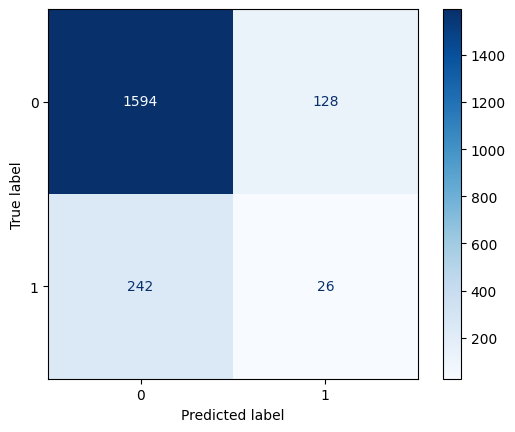

Accuracy: 0.8141
Precision: 0.1688
Recall: 0.0970
f1 score: 0.1232


In [199]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

Random Forest 모델은 모델에 기여한 특징 추출도를 추출할 수 있기 때문에 확인해봅니다.

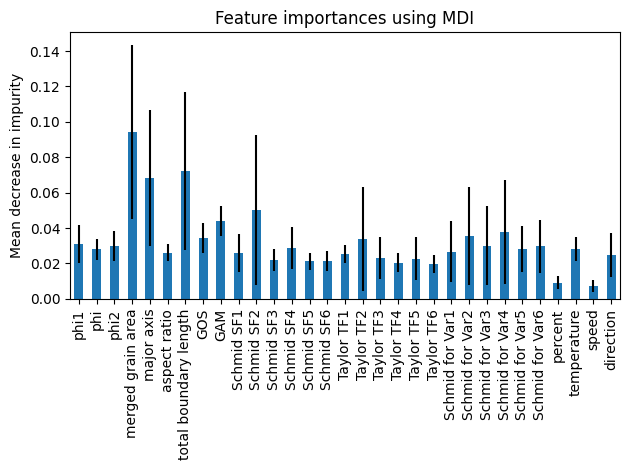

In [200]:
importances = rf_model.feature_importances_
forest_std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=COLS_TO_USE)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=forest_std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

위의 'feature importance' 추출 방법은 어떤 경우에 왜곡된 결과를 보여줄 수 있으므로 다른 방법을 사용한 특징 중요도를 추출해봅니다.
- 참고 링크 : https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-mean-decrease-in-impurity

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


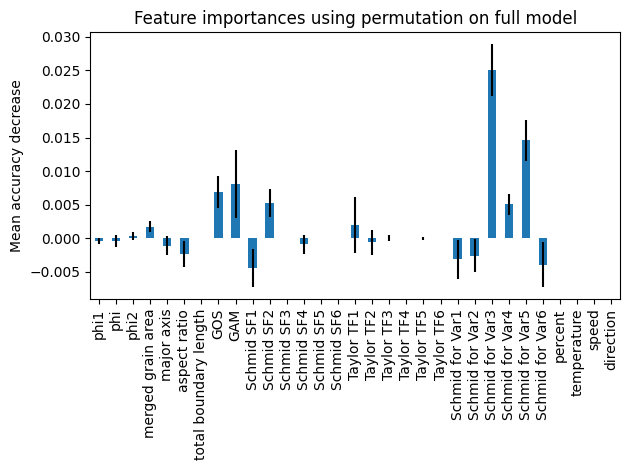

In [201]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=30, random_state=1105, n_jobs=3
)
pm_importances = pd.Series(result.importances_mean, index=COLS_TO_USE)

fig, ax = plt.subplots()
pm_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Logistic Regression 모델을의 성능을 확인합니다.

In [202]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


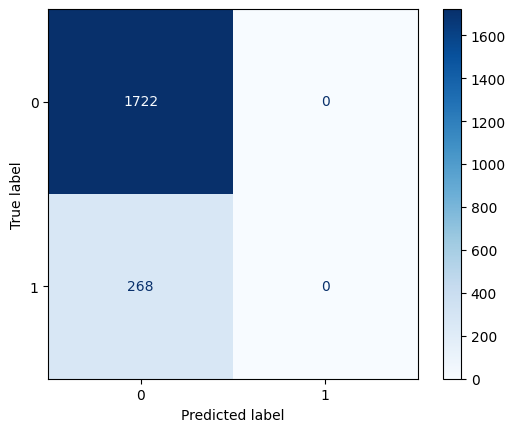

Accuracy: 0.8653
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [203]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

SVM 모델의 성능을 확인합니다.

In [204]:
from sklearn.svm import LinearSVC

# class_weight을 통해 클래스별 가중치를 줄 수 있습니다.
# 이는 클래스 불균형 시 도움이 될 수 있으나, 실험해봤을 때 경향에 큰 차이를 주지는 않았습니다.
class_weight = {
    0: 1.0,
    1: 10.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


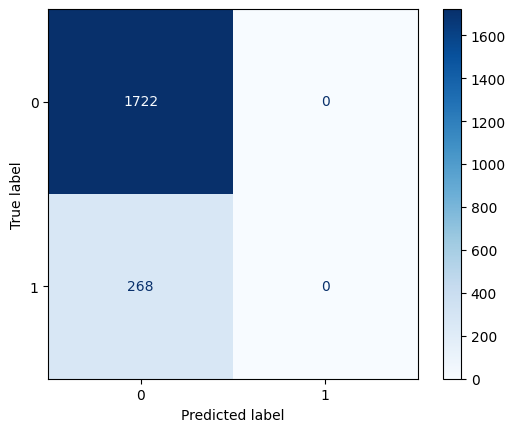

Accuracy: 0.8653
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [205]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

딥러닝 계열 모델의 성능을 확인합니다.

In [206]:
# 딥러닝 모델 파라미터 수를 계산하는 함수 정의
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

기본 Multilayer Perceptron으로만 구성된 `MLP` 모델을 정의하고 훈련합니다.
- 이 때 모델 구조 및 파라미터 수를 변경할 수 있습니다.
- 그러나 경향에 큰 차이를 주지는 않았습니다.

In [207]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 1)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

342,017
MLP model number of params: 342,017


In [208]:
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000

# overfitting 시 훈련 종료를 위해 사용하는 허용 epoch 수입니다.
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp).squeeze()  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp).squeeze()
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.8170 / Val_loss: 0.4073
Epoch: 002, Train_loss: 0.5628 / Val_loss: 0.4012
Epoch: 003, Train_loss: 0.4557 / Val_loss: 0.4168
Epoch: 004, Train_loss: 0.4212 / Val_loss: 0.4288
Epoch: 005, Train_loss: 0.4103 / Val_loss: 0.4361
Epoch: 006, Train_loss: 0.4131 / Val_loss: 0.4397
Epoch: 007, Train_loss: 0.4099 / Val_loss: 0.4406
Epoch: 008, Train_loss: 0.4146 / Val_loss: 0.4393
Epoch: 009, Train_loss: 0.4140 / Val_loss: 0.4362
Epoch: 010, Train_loss: 0.4163 / Val_loss: 0.4318
Epoch: 011, Train_loss: 0.4153 / Val_loss: 0.4265
Epoch: 012, Train_loss: 0.4135 / Val_loss: 0.4206
Epoch: 013, Train_loss: 0.4128 / Val_loss: 0.4147
Epoch: 014, Train_loss: 0.4098 / Val_loss: 0.4089
Epoch: 015, Train_loss: 0.4090 / Val_loss: 0.4037
Epoch: 016, Train_loss: 0.4060 / Val_loss: 0.3992
Epoch: 017, Train_loss: 0.4031 / Val_loss: 0.3958
Epoch: 018, Train_loss: 0.4011 / Val_loss: 0.3934
Epoch: 019, Train_loss: 0.3999 / Val_loss: 0.3919
Epoch: 020, Train_loss: 0.4019 / Val_loss: 0.3911


훈련 결과(loss)를 시각화합니다.

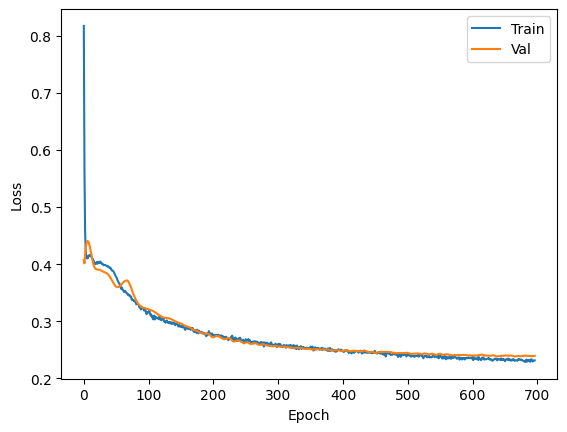

In [209]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

'평가'데이터셋으로 모델의 성능을 평가해봅니다.

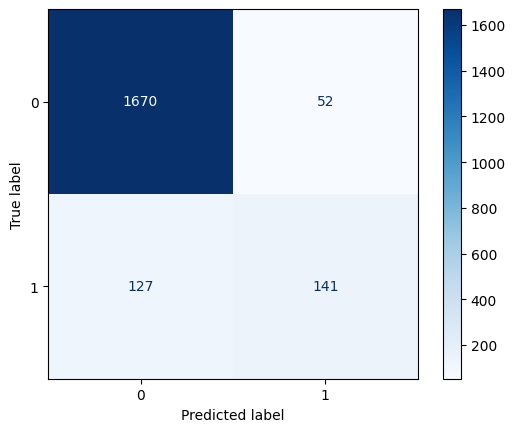

Accuracy: 0.9101
Precision: 0.7306
Recall: 0.5261
f1 score: 0.6117


In [210]:
model.eval()
with torch.no_grad():
    out_mlp = model(data.x[data.test_mask])
# pred = out.argmax(dim=1)  # Use the class with highest probability.
pred_mlp = F.sigmoid(out_mlp).round()

y_true = data.y[data.test_mask].numpy()
y_pred = pred_mlp.numpy()

cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()


print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

아직 아래의 코드가 진행되지 않았지만, 아래에서 GNN 모델을 훈련시키고 평가해보면 단순 MLP 모델보다 낮은 성능을 보여줍니다. 따라서 전체적으로 가장 높은 성능을 보이는 MLP 모델의 설명 가능성 확보를 위해 SHAPLY 값을 측정해봅니다.

In [211]:
import shap

shap.initjs()

shap_data = data.x[data.train_mask]

# 데이터 수가 많을수록 시간이 오래걸립니다.
background = shap_data[np.random.choice(shap_data.shape[0], 2000, replace=False)]
shap_test = data.x[data.test_mask][np.random.choice(data.x[data.test_mask].shape[0], 200, replace=False)]

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(shap_test, check_additivity=False)

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


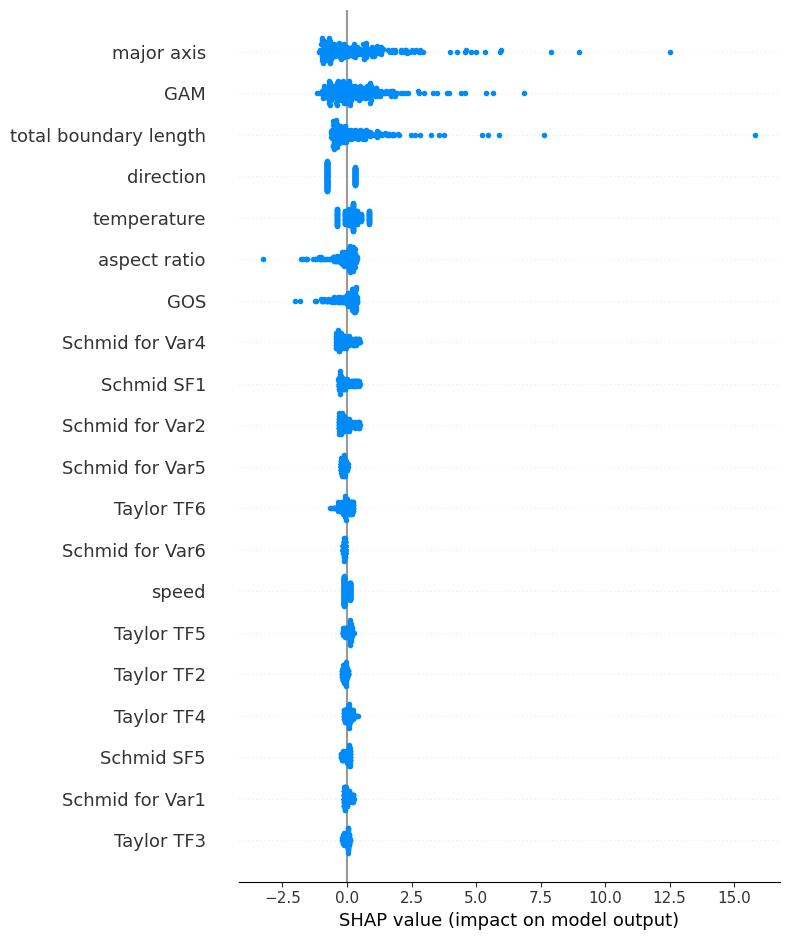

In [212]:
# exp = shap.Explanation(shap_values.squeeze(), feature_names=FEATURE_COLS)
# shap.plots.beeswarm(exp, color=['red', 'blue'])

shap.summary_plot(shap_values.squeeze(), feature_names=COLS_TO_USE)

인접 grain 정보를 포함하여 모델이 학습하게 하는 GNN 계열 모델을 정의하고 훈련합니다.

첫번째로 `GCNConv` 레이어를 사용한 모델의 성능을 확인해봅니다.

In [213]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

342,017
GCN model number of params: 342,017


In [214]:
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.5200 / Val_loss: 0.5193
Epoch: 002, Train_loss: 0.4676 / Val_loss: 0.4685
Epoch: 003, Train_loss: 0.4331 / Val_loss: 0.4253
Epoch: 004, Train_loss: 0.4343 / Val_loss: 0.4308
Epoch: 005, Train_loss: 0.4220 / Val_loss: 0.4192
Epoch: 006, Train_loss: 0.4212 / Val_loss: 0.4272
Epoch: 007, Train_loss: 0.4170 / Val_loss: 0.4196
Epoch: 008, Train_loss: 0.4118 / Val_loss: 0.4094
Epoch: 009, Train_loss: 0.4101 / Val_loss: 0.4069
Epoch: 010, Train_loss: 0.4109 / Val_loss: 0.4072
Epoch: 011, Train_loss: 0.4084 / Val_loss: 0.4057
Epoch: 012, Train_loss: 0.4072 / Val_loss: 0.4008
Epoch: 013, Train_loss: 0.4035 / Val_loss: 0.4077
Epoch: 014, Train_loss: 0.4029 / Val_loss: 0.4046
Epoch: 015, Train_loss: 0.4018 / Val_loss: 0.3998
Epoch: 016, Train_loss: 0.4018 / Val_loss: 0.3981
Epoch: 017, Train_loss: 0.3970 / Val_loss: 0.4061
Epoch: 018, Train_loss: 0.3980 / Val_loss: 0.3996
Epoch: 019, Train_loss: 0.3966 / Val_loss: 0.4007
Epoch: 020, Train_loss: 0.3955 / Val_loss: 0.3982


훈련 결과(loss)를 시각화합니다.

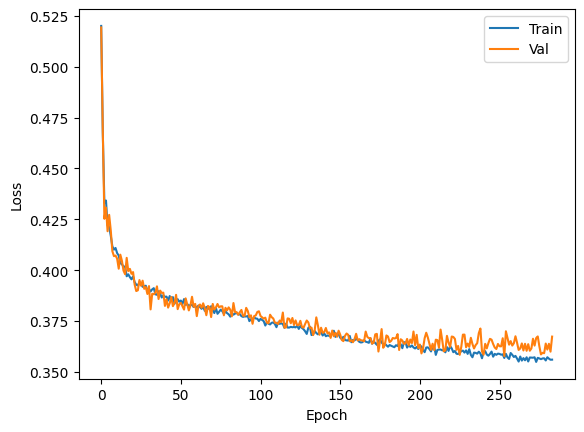

In [215]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

모델을 '평가'데이터셋에 평가하고 성능을 확인합니다.

In [216]:
model.eval()
# pred = out.argmax(dim=1)  # Use the class with highest probability.
with torch.no_grad():
    out_gcn = model(data.x, data.edge_index)
pred_gcn = F.sigmoid(out_gcn).round()

y_pred = pred_gcn[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

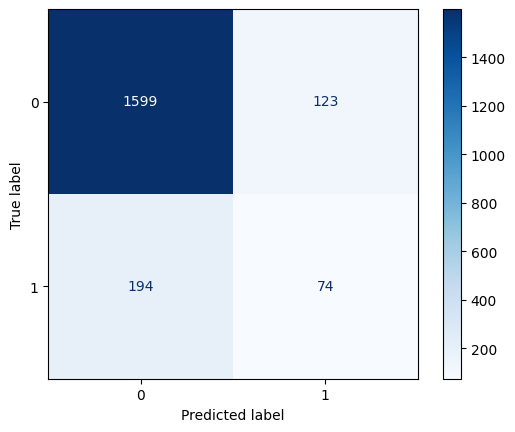

Accuracy: 0.8407
Precision: 0.3756
Recall: 0.2761
f1 score: 0.3183


In [217]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

두번째로 GNN계열에서 `GATConv` 레이어를 사용한 모델을 정의하고 훈련합니다.

In [218]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

344,707
GAT model number of params: 344,707


In [219]:
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.5611 / Val_loss: 0.5498
Epoch: 002, Train_loss: 0.4793 / Val_loss: 0.4816
Epoch: 003, Train_loss: 0.4710 / Val_loss: 0.4731
Epoch: 004, Train_loss: 0.4419 / Val_loss: 0.4385
Epoch: 005, Train_loss: 0.4242 / Val_loss: 0.4254
Epoch: 006, Train_loss: 0.3979 / Val_loss: 0.3921
Epoch: 007, Train_loss: 0.3968 / Val_loss: 0.3877
Epoch: 008, Train_loss: 0.3974 / Val_loss: 0.4014
Epoch: 009, Train_loss: 0.3886 / Val_loss: 0.3916
Epoch: 010, Train_loss: 0.4017 / Val_loss: 0.3977
Epoch: 011, Train_loss: 0.3907 / Val_loss: 0.4057
Epoch: 012, Train_loss: 0.3812 / Val_loss: 0.3810
Epoch: 013, Train_loss: 0.3762 / Val_loss: 0.3713
Epoch: 014, Train_loss: 0.3783 / Val_loss: 0.3729
Epoch: 015, Train_loss: 0.3775 / Val_loss: 0.3770
Epoch: 016, Train_loss: 0.3750 / Val_loss: 0.3712
Epoch: 017, Train_loss: 0.3722 / Val_loss: 0.3741
Epoch: 018, Train_loss: 0.3715 / Val_loss: 0.3721
Epoch: 019, Train_loss: 0.3703 / Val_loss: 0.3691
Epoch: 020, Train_loss: 0.3693 / Val_loss: 0.3716


훈련 결과(loss)를 시각화합니다.

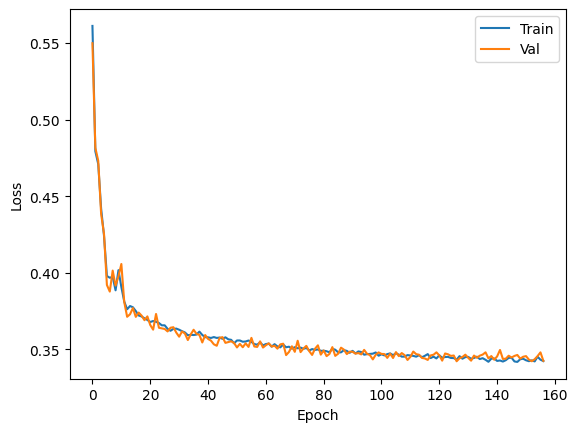

In [220]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

모델을 평가하고 성능을 정량적으로 확인합니다.

In [221]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

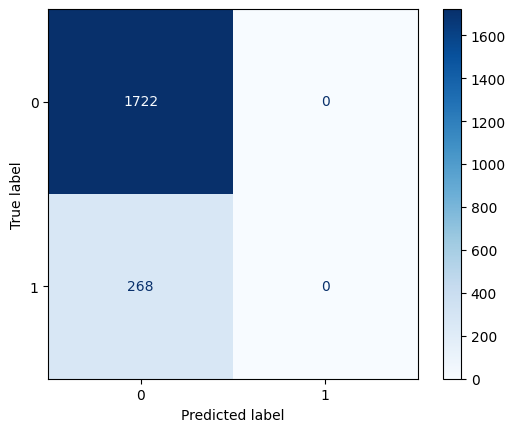

Accuracy: 0.8653
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [222]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

#### 4. 외곽선에 걸친 샘플 제거 후 성능 확인

- 현재까지 모델들이 보여준 모습에서는 인접 grain의 정보를 넣었던 안 넣었던 최적화되지 않은 모습을 보여줍니다.
- 데이터셋에서 외곽선에 걸친 샘플의 경우 `merged grain area` 같이 크기를 나타내는 특징이 실제와 다르게 왜곡됐을 가능성이 크므로 한 번 제거해보고 모델의 성능을 확인해봅니다.
- 이를 위해 1. 외곽선 샘플 제거 2. 연결 정보 재정비 3. 기존 모델에 동일하게 훈련하는 과정을 거칩니다.

In [58]:
# 외곽선에 걸치지 않은 데이터를 선별합니다.
BORDER_COL = 'border boundary length'
df_inside = df[df[BORDER_COL] == 0]
df_inside = df_inside.reset_index(drop=True)

In [59]:
df_inside.shape

(17123, 64)

인접 grain 연결 정보를 재정비합니다. 이 때 외곽선에 걸친 샘플을 제거함으로써 연결 정보가 사라진 샘플의 경우 동일하게 연결 정보에서 제외시킵니다.

In [61]:
edges_2 = []
edge_info_2 = df_inside[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info_2):
    df_set = df_inside[df_inside["set_num"] == df_inside.iloc[i]["set_num"]]
    indices_included = df_set["merged ID"].tolist()
    for e in e_list:
        if e in indices_included:
            idx = df_set.index[df_set["merged ID"] == e].tolist()[0]
            new = [i, idx]
            edges_2.append(new)
        
edge_index_2 = torch.Tensor(edges_2).to(dtype=torch.long).t()

In [64]:
# df_inside[df_inside["set_num"] == df_inside["set_num"].iloc[-1]][:10]

새로 만든 인접 정보를 검증해봅니다.

지금은 각각 연결 정보가 쌍으로 이루어져 있는지를 확인해봅니다.

각각 연결 정보가 정말로 제거되지 않은 샘플들만 갖고 있는지 확인도 필요하나, 해당 부분은 코드를 통해 진행하지 않아 생략합니다.(위의 코드를 debugging하며 확인해보았습니다.)

In [65]:
d = pd.DataFrame(edge_index_2.t())

sum(d.apply(lambda x: set(x), axis=1).value_counts() != 2)

0

새로운 `y`를 정의합니다.

In [66]:
y = (df_inside["daughter grains percent"] > 0).map(int).to_numpy()

현 시점부터 위와 동일한 방법으로 진행합니다.

- 데이터 숫자 측면에서는 제거된 샘플들이 있기 때문에 줄어든 것을 확인할 수 있습니다.

In [69]:
np.random.seed(1105)

train_ratio = 0.8

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 13698
len(val_indices) = 1712
len(test_indices) = 1713
split done!


In [71]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [72]:
X_train = df_inside.loc[train_mask.numpy(), COLS_TO_USE]
X_val = df_inside.loc[val_mask.numpy(), COLS_TO_USE]
X_test = df_inside.loc[test_mask.numpy(), COLS_TO_USE]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (13698, 31) / (1712, 31) / (1713, 31)
y_train.shape = (13698,) / (1712,) / (1713,)


In [73]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [74]:
X = np.zeros_like(df_inside[COLS_TO_USE])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [75]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index_2,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [76]:
data

Data(x=[17123, 31], edge_index=[2, 83670], y=[17123], train_mask=[17123], val_mask=[17123], test_mask=[17123])

In [77]:
pd.DataFrame(X, columns=COLS_TO_USE).describe()

phi1           phi          phi2  merged grain area  \
count  17123.000000  17123.000000  17123.000000       17123.000000   
mean       0.001247     -0.004302      0.002261          -0.001366   
std        1.013233      1.003241      1.010453           0.960895   
min       -1.153512     -2.383227     -1.058159          -0.369200   
25%       -0.665871      0.215617     -0.620479          -0.338280   
50%       -0.133036      0.422177     -0.153086          -0.252242   
75%        0.628865      0.520561      0.563285          -0.019670   
max       13.185208      0.588502     12.257063          38.756661   

         major axis  aspect ratio  total boundary length           GOS  \
count  17123.000000  17123.000000           17123.000000  17123.000000   
mean       0.002815     -0.000761               0.000668      0.000374   
std        0.991631      0.992812               0.977027      1.006495   
min       -0.915498     -0.943221              -0.719636     -0.999724   
25%       -0.626170     -0.549860              -0.509852     -0.665632   
50%       -0.280747     -0.258147              -0.268600     -0.345494   
75%        0.279216      0.211365               0.150968      0.288479   
max       12.119781     18.016565              16.744876     10.456394   

                GAM    Schmid SF1  ...  Schmid for Var1  Schmid for Var2  \
count  17123.000000  17123.000000  ...     17123.000000     17123.000000   
mean      -0.006179     -0.004808  ...        -0.003903        -0.004325   
std        0.999312      1.005182  ...         1.003102         1.002703   
min       -1.417834     -2.551531  ...        -2.622444        -2.618076   
25%       -0.687288     -0.715019  ...        -0.637807        -0.640419   
50%       -0.250010      0.270501  ...         0.260292         0.259910   
75%        0.368289      0.839146  ...         0.831064         0.828374   
max       12.645262      1.258680  ...         1.236967         1.233539   

       Schmid for Var3  Schmid for Var4  Schmid for Var5  Schmid for Var6  \
count     17123.000000     17123.000000     17123.000000     17123.000000   
mean         -0.003586        -0.003081        -0.003613        -0.003716   
std           1.001147         1.001258         1.001976         1.001952   
min          -2.492145        -2.489466        -2.377488        -2.383188   
25%          -0.623275        -0.623182        -0.725939        -0.717355   
50%           0.267200         0.264232         0.101540         0.097991   
75%           0.833159         0.830344         0.882289         0.887484   
max           1.220268         1.220195         1.454926         1.459671   

            percent   temperature         speed     direction  
count  17123.000000  17123.000000  17123.000000  17123.000000  
mean      -0.001667     -0.006024     -0.001186     -0.003235  
std        0.999898      1.003263      1.000343      1.000861  
min       -0.924984     -1.859039     -1.300039     -1.291950  
25%       -0.924984     -0.555475     -1.300039     -1.291950  
50%       -0.924984     -0.120954      0.769208      0.774024  
75%        1.081100      0.748088      0.769208      0.774024  
max        1.081100      1.617131      0.769208      0.774024  

[8 rows x 31 columns]

In [78]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


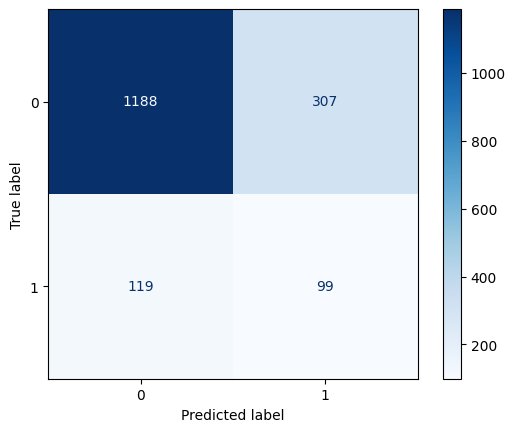

Accuracy: 0.7513
Precision: 0.2438
Recall: 0.4541
f1 score: 0.3173


In [79]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [80]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


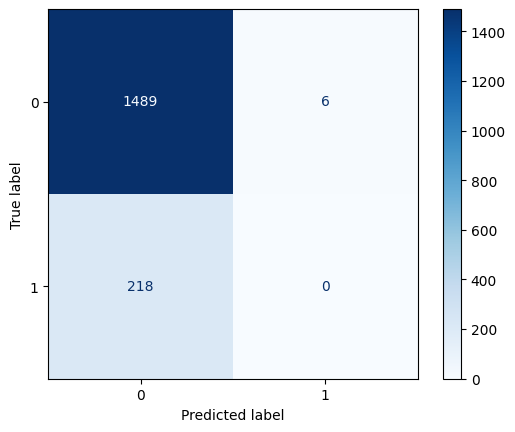

Accuracy: 0.8692
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


In [81]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [83]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 10.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


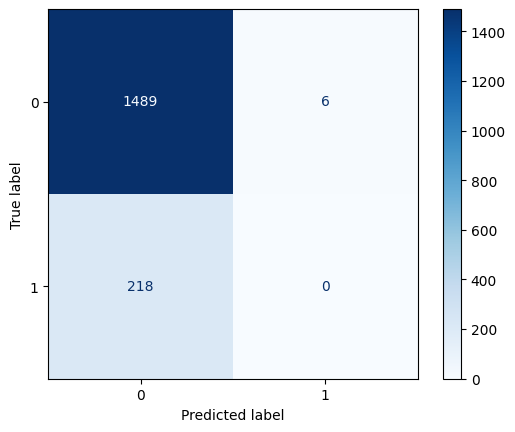

Accuracy: 0.8692
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


In [84]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [85]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [86]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 1)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

342,017
MLP model number of params: 342,017


In [87]:
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp).squeeze()  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp).squeeze()
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.8169 / Val_loss: 0.3964
Epoch: 002, Train_loss: 0.5611 / Val_loss: 0.3834
Epoch: 003, Train_loss: 0.4489 / Val_loss: 0.3964
Epoch: 004, Train_loss: 0.4132 / Val_loss: 0.4073
Epoch: 005, Train_loss: 0.3979 / Val_loss: 0.4144
Epoch: 006, Train_loss: 0.3943 / Val_loss: 0.4185
Epoch: 007, Train_loss: 0.3957 / Val_loss: 0.4202
Epoch: 008, Train_loss: 0.4011 / Val_loss: 0.4199
Epoch: 009, Train_loss: 0.3970 / Val_loss: 0.4181
Epoch: 010, Train_loss: 0.4025 / Val_loss: 0.4149
Epoch: 011, Train_loss: 0.3989 / Val_loss: 0.4107
Epoch: 012, Train_loss: 0.3979 / Val_loss: 0.4058
Epoch: 013, Train_loss: 0.3972 / Val_loss: 0.4007
Epoch: 014, Train_loss: 0.3960 / Val_loss: 0.3955
Epoch: 015, Train_loss: 0.3947 / Val_loss: 0.3906
Epoch: 016, Train_loss: 0.3951 / Val_loss: 0.3862
Epoch: 017, Train_loss: 0.3899 / Val_loss: 0.3825
Epoch: 018, Train_loss: 0.3896 / Val_loss: 0.3797
Epoch: 019, Train_loss: 0.3877 / Val_loss: 0.3777
Epoch: 020, Train_loss: 0.3882 / Val_loss: 0.3765


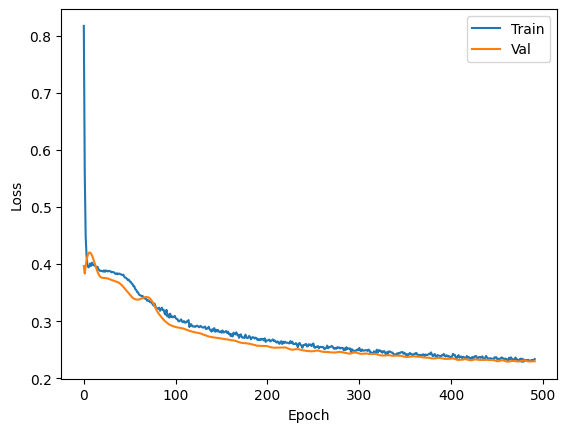

In [88]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

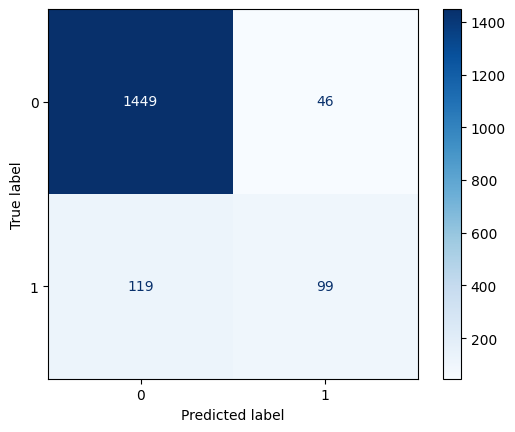

Accuracy: 0.9037
Precision: 0.6828
Recall: 0.4541
f1 score: 0.5455


In [89]:
model.eval()
X_tmp_test = data.x[data.test_mask]
y_tmp_test = data.y[data.test_mask]
with torch.no_grad():
    out = model(X_tmp_test)
# pred = out.argmax(dim=1)  # Use the class with highest probability.
pred = F.sigmoid(out).round()

cm = confusion_matrix(y_tmp_test, pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Precision: {precision_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Recall: {recall_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"f1 score: {f1_score(y_tmp_test.numpy(), pred.numpy()):.4f}")

In [90]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

342,017
GCN model number of params: 342,017


In [91]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.5013 / Val_loss: 0.4888
Epoch: 002, Train_loss: 0.4601 / Val_loss: 0.4492
Epoch: 003, Train_loss: 0.4190 / Val_loss: 0.4146
Epoch: 004, Train_loss: 0.4049 / Val_loss: 0.4062
Epoch: 005, Train_loss: 0.4106 / Val_loss: 0.4173
Epoch: 006, Train_loss: 0.3952 / Val_loss: 0.3982
Epoch: 007, Train_loss: 0.3963 / Val_loss: 0.3917
Epoch: 008, Train_loss: 0.3970 / Val_loss: 0.3905
Epoch: 009, Train_loss: 0.3953 / Val_loss: 0.3784
Epoch: 010, Train_loss: 0.3912 / Val_loss: 0.3757
Epoch: 011, Train_loss: 0.3878 / Val_loss: 0.3789
Epoch: 012, Train_loss: 0.3851 / Val_loss: 0.3769
Epoch: 013, Train_loss: 0.3899 / Val_loss: 0.3793
Epoch: 014, Train_loss: 0.3832 / Val_loss: 0.3747
Epoch: 015, Train_loss: 0.3786 / Val_loss: 0.3725
Epoch: 016, Train_loss: 0.3795 / Val_loss: 0.3724
Epoch: 017, Train_loss: 0.3828 / Val_loss: 0.3747
Epoch: 018, Train_loss: 0.3817 / Val_loss: 0.3694
Epoch: 019, Train_loss: 0.3804 / Val_loss: 0.3723
Epoch: 020, Train_loss: 0.3755 / Val_loss: 0.3717


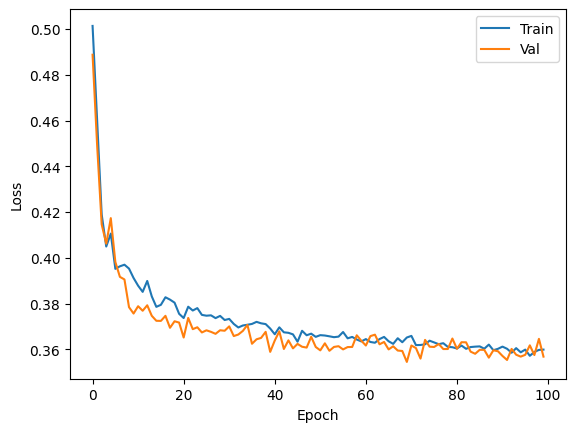

In [92]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [93]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

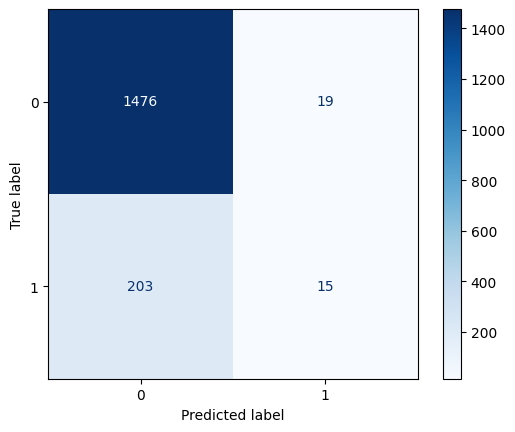

Accuracy: 0.8704
Precision: 0.4412
Recall: 0.0688
f1 score: 0.1190


In [94]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [95]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

344,707
GAT model number of params: 344,707


In [96]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight) # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.5875 / Val_loss: 0.5795
Epoch: 002, Train_loss: 0.4471 / Val_loss: 0.4427
Epoch: 003, Train_loss: 0.4535 / Val_loss: 0.4468
Epoch: 004, Train_loss: 0.4430 / Val_loss: 0.4355
Epoch: 005, Train_loss: 0.4194 / Val_loss: 0.4078
Epoch: 006, Train_loss: 0.3944 / Val_loss: 0.3858
Epoch: 007, Train_loss: 0.3792 / Val_loss: 0.3787
Epoch: 008, Train_loss: 0.3753 / Val_loss: 0.3714
Epoch: 009, Train_loss: 0.3721 / Val_loss: 0.3711
Epoch: 010, Train_loss: 0.3673 / Val_loss: 0.3698
Epoch: 011, Train_loss: 0.3710 / Val_loss: 0.3778
Epoch: 012, Train_loss: 0.3713 / Val_loss: 0.3692
Epoch: 013, Train_loss: 0.3639 / Val_loss: 0.3607
Epoch: 014, Train_loss: 0.3607 / Val_loss: 0.3568
Epoch: 015, Train_loss: 0.3614 / Val_loss: 0.3580
Epoch: 016, Train_loss: 0.3558 / Val_loss: 0.3565
Epoch: 017, Train_loss: 0.3579 / Val_loss: 0.3498
Epoch: 018, Train_loss: 0.3564 / Val_loss: 0.3586
Epoch: 019, Train_loss: 0.3563 / Val_loss: 0.3519
Epoch: 020, Train_loss: 0.3576 / Val_loss: 0.3501


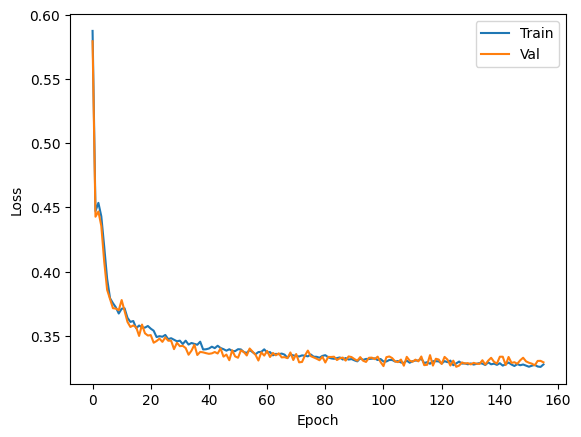

In [97]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

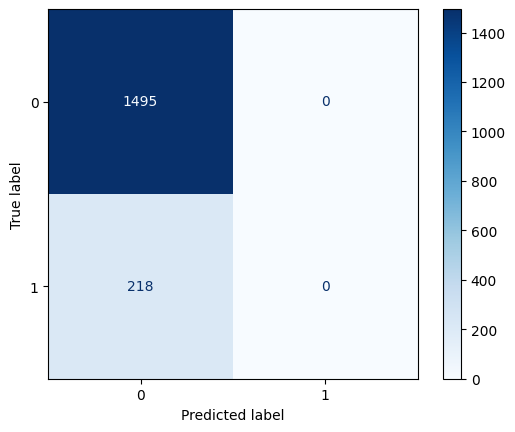

Accuracy: 0.8727
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [98]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [99]:
sum(y) / len(y)

np.float64(0.12702213397185072)

#### 5. `V0`과 `V90` 데이터를 나눠서 진행

- 현재까지는 `V0`과 `V90`데이터가 합쳐져서 진행되었습니다.
- 두 데이터가 굉장히 이질적일 수 있다는 조언을 기반으로 나눠서 모델에 학습 및 성능을 평가해봅니다.
- 초기 데이터 세팅만 다를 뿐, 모델 관련 코드는 위와 동일합니다.

In [105]:
df_v0 = df[df["direction"] == 0].reset_index(drop=True)
df_v90 = df[df["direction"] == 90].reset_index(drop=True)

assert len(df) == len(df_v0) + len(df_v90)

In [106]:
# 사용할 특징들 자료형 등 확인
df_v0[FEATURE_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   phi1                   7588 non-null   float64
 1   phi                    7588 non-null   float64
 2   phi2                   7588 non-null   float64
 3   merged grain area      7588 non-null   int64  
 4   major axis             7588 non-null   float64
 5   aspect ratio           7588 non-null   float64
 6   total boundary length  7588 non-null   int64  
 7   GOS                    7588 non-null   float64
 8   GAM                    7588 non-null   float64
 9   Schmid SF1             7588 non-null   float64
 10  Schmid SF2             7588 non-null   float64
 11  Schmid SF3             7588 non-null   float64
 12  Schmid SF4             7588 non-null   float64
 13  Schmid SF5             7588 non-null   float64
 14  Schmid SF6             7588 non-null   float64
 15  Tayl

In [107]:
# 사용할 특징들 기본 통계 수치 확인
df_v0[FEATURE_COLS].describe()

phi1          phi         phi2  merged grain area   major axis  \
count  7588.000000  7588.000000  7588.000000        7588.000000  7588.000000   
mean     28.785311   302.357322    29.250501         323.969689    20.594974   
std      19.799890   105.872413    22.397810         865.855106    18.697277   
min       0.056505     0.001946     0.027504          10.000000     3.758988   
25%      14.822545   320.258749    15.325455          35.000000     8.963182   
50%      27.748530   340.423036    27.587891         103.000000    15.219490   
75%      41.467053   351.054993    41.334535         280.000000    25.305854   
max     359.914579   359.990298   359.843825       29114.000000   235.423141   

       aspect ratio  total boundary length          GOS          GAM  \
count   7588.000000            7588.000000  7588.000000  7588.000000   
mean       1.910983              88.611624     1.066940     0.722938   
std        0.903193             100.942622     1.090687     0.287582   
min        1.009876              14.000000     0.070525     0.152375   
25%        1.392837              36.000000     0.360279     0.513304   
50%        1.680437              60.000000     0.658074     0.681093   
75%        2.136403             101.000000     1.317162     0.868853   
max       14.704146            1679.000000    11.669275     3.872301   

        Schmid SF1  ...  Schmid for Var1  Schmid for Var2  Schmid for Var3  \
count  7588.000000  ...      7588.000000      7588.000000      7588.000000   
mean      0.303005  ...        -0.000061        -0.000049        -0.024983   
std       0.145808  ...         0.274897         0.275205         0.284545   
min       0.000084  ...        -0.499920        -0.499964        -0.499985   
25%       0.182974  ...        -0.221296        -0.223813        -0.278674   
50%       0.332026  ...         0.009055         0.007559        -0.011066   
75%       0.435397  ...         0.221352         0.220333         0.205590   
max       0.499963  ...         0.499802         0.499907         0.499923   

       Schmid for Var4  Schmid for Var5  Schmid for Var6      percent  \
count      7588.000000      7588.000000      7588.000000  7588.000000   
mean         -0.025393         0.007657         0.008056     4.678967   
std           0.284023         0.237554         0.237492     1.974196   
min          -0.499807        -0.499510        -0.499496     3.000000   
25%          -0.280164        -0.157824        -0.156978     3.000000   
50%          -0.012297        -0.011503        -0.010810     3.000000   
75%           0.204267         0.169163         0.173446     7.000000   
max           0.499701         0.499892         0.499978     7.000000   

       temperature        speed  direction  
count  7588.000000  7588.000000     7588.0  
mean    253.498946     0.833553        0.0  
std     112.113668     0.372506        0.0  
min      25.000000     0.000000        0.0  
25%     175.000000     1.000000        0.0  
50%     275.000000     1.000000        0.0  
75%     325.000000     1.000000        0.0  
max     425.000000     1.000000        0.0  

[8 rows x 31 columns]

In [108]:
edges = []
edge_info = df_v0[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info):
    for e in e_list:
        df_set = df_v0[df_v0["set_num"] == df_v0.iloc[i]["set_num"]]
        node = df_set.index[df_set["merged ID"] == e].to_list()[0]
        
        new = [i, node]
        edges.append(new)
        
edge_index = torch.Tensor(edges).to(dtype=torch.long).t()

In [109]:
# 확인
edge_index

tensor([[   0,    0,    1,  ..., 7587, 7587, 7587],
        [ 454,  478,  456,  ..., 7547, 7548, 7585]])

In [111]:
y = (df_v0["daughter grains percent"] > 0).astype(int).to_numpy()

In [112]:
np.random.seed(1105)

train_ratio = 0.8

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 6070
len(val_indices) = 759
len(test_indices) = 759
split done!


In [113]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [114]:
COLS_TO_USE = FEATURE_COLS

X_train = df_v0.loc[train_mask.numpy(), COLS_TO_USE]
X_val = df_v0.loc[val_mask.numpy(), COLS_TO_USE]
X_test = df_v0.loc[test_mask.numpy(), COLS_TO_USE]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (6070, 31) / (759, 31) / (759, 31)
y_train.shape = (6070,) / (759,) / (759,)


In [115]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [116]:
X = np.zeros_like(df_v0[COLS_TO_USE])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [117]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [118]:
# 데이터 확인
data

Data(x=[7588, 31], edge_index=[2, 41296], y=[7588], train_mask=[7588], val_mask=[7588], test_mask=[7588])

In [119]:
pd.DataFrame(X, columns=COLS_TO_USE).describe()

phi1          phi         phi2  merged grain area   major axis  \
count  7588.000000  7588.000000  7588.000000        7588.000000  7588.000000   
mean      0.001713     0.005454     0.006386          -0.006149    -0.005825   
std       1.023153     0.994696     1.046254           0.970368     0.985776   
min      -1.482839    -2.835244    -1.358688          -0.358016    -0.893468   
25%      -0.719808     0.173642    -0.644085          -0.329998    -0.619087   
50%      -0.051862     0.363091    -0.071279          -0.253790    -0.289236   
75%       0.657039     0.462980     0.570859          -0.055426     0.242547   
max      17.112716     0.546930    15.449166          32.258988    11.320558   

       aspect ratio  total boundary length          GOS          GAM  \
count   7588.000000            7588.000000  7588.000000  7588.000000   
mean      -0.003598              -0.003889    -0.000386     0.002008   
std        0.988241               0.993849     0.988524     0.989351   
min       -0.989556              -0.738491    -0.903469    -1.960865   
25%       -0.570534              -0.521886    -0.640856    -0.719182   
50%       -0.255853              -0.285590    -0.370955    -0.141949   
75%        0.243049               0.118083     0.226397     0.503994   
max       13.994215              15.654567     9.608848    10.836588   

        Schmid SF1  ...  Schmid for Var1  Schmid for Var2  Schmid for Var3  \
count  7588.000000  ...      7588.000000      7588.000000      7588.000000   
mean      0.003037  ...        -0.000447         0.000287        -0.001721   
std       0.995659  ...         0.996915         0.997379         0.998527   
min      -2.065480  ...        -1.813185        -1.811474        -1.668604   
25%      -0.816608  ...        -0.802757        -0.810662        -0.891979   
50%       0.201206  ...         0.032612         0.027861         0.047113   
75%       0.907086  ...         0.802508         0.798984         0.807407   
max       1.347977  ...         1.812305         1.812198         1.840285   

       Schmid for Var4  Schmid for Var5  Schmid for Var6      percent  \
count      7588.000000      7588.000000      7588.000000  7588.000000   
mean         -0.002821        -0.005452        -0.004989     0.002616   
std           0.998009         1.002644         1.002539     1.000495   
min          -1.669830        -2.146048        -2.147554    -0.848261   
25%          -0.898041        -0.703897        -0.701661    -0.848261   
50%           0.043195        -0.086322        -0.084630    -0.848261   
75%           0.804166         0.676214         0.693179     1.178882   
max           1.842269         2.072117         2.071591     1.178882   

       temperature        speed  direction  
count  7588.000000  7588.000000     7588.0  
mean      0.011065     0.006450        0.0  
std       0.998848     0.994327        0.0  
min      -2.024688    -2.218547        0.0  
25%      -0.688301     0.450745        0.0  
50%       0.202623     0.450745        0.0  
75%       0.648085     0.450745        0.0  
max       1.539009     0.450745        0.0  

[8 rows x 31 columns]

In [120]:
# 필요 시 아래의 모델 하이퍼파라미터 부분 주석을 해제하여 사용합니다.
# 크게 다르지 않은 경향을 보여주었습니다.
rf_model = RandomForestClassifier(
    # n_estimators=30,
    # max_depth=10,
    # random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


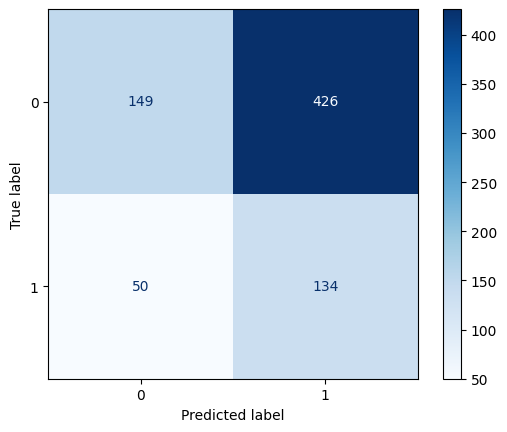

Accuracy: 0.3729
Precision: 0.2393
Recall: 0.7283
f1 score: 0.3602


In [121]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

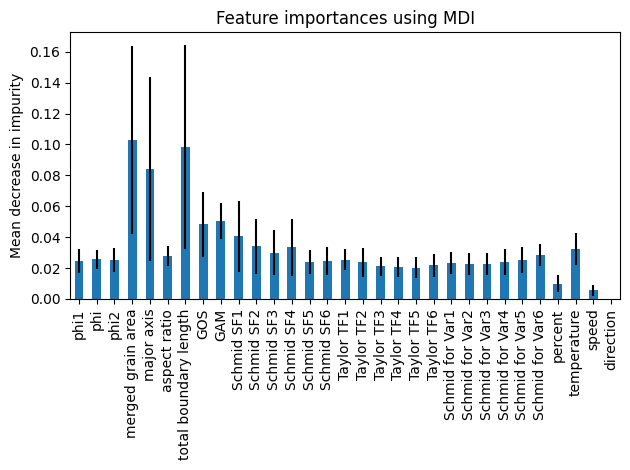

In [122]:
importances = rf_model.feature_importances_
forest_std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=COLS_TO_USE)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=forest_std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


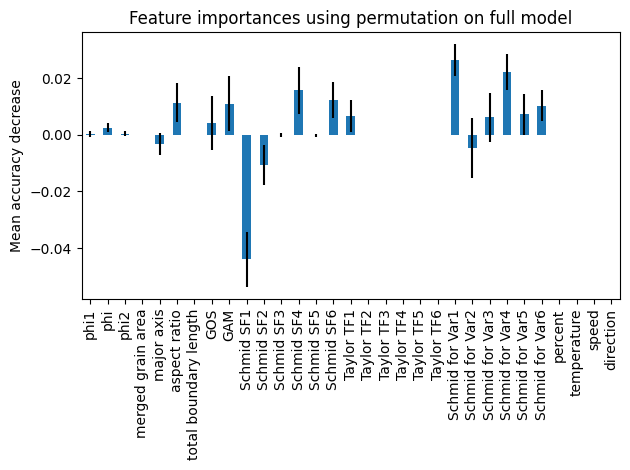

In [123]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=30, random_state=1105, n_jobs=3
)
pm_importances = pd.Series(result.importances_mean, index=COLS_TO_USE)

fig, ax = plt.subplots()
pm_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [124]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


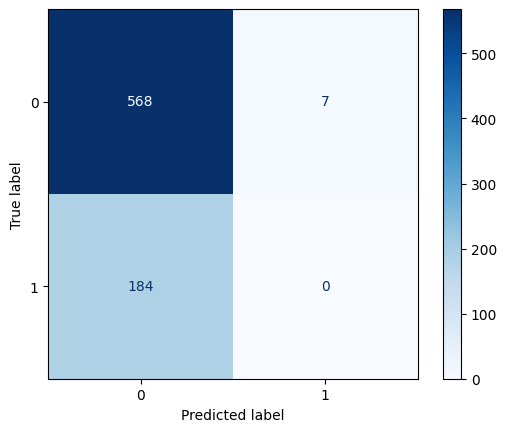

Accuracy: 0.7484
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


In [125]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [126]:
from sklearn.svm import LinearSVC

# class_weight을 통해 클래스별 가중치를 줄 수 있습니다.
# 이는 클래스 불균형 시 도움이 될 수 있으나, 실험해봤을 때 경향에 큰 차이를 주지는 않았습니다.
class_weight = {
    0: 1.0,
    1: 10.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


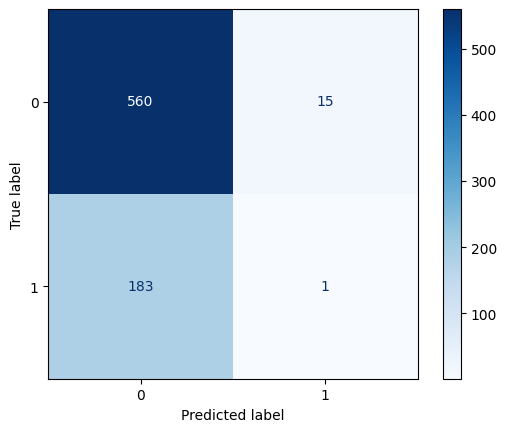

Accuracy: 0.7391
Precision: 0.0625
Recall: 0.0054
f1 score: 0.0100


In [127]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [128]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 1)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

342,017
MLP model number of params: 342,017


In [129]:
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000

# overfitting 시 훈련 종료를 위해 사용하는 허용 epoch 수입니다.
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp).squeeze()  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp).squeeze()
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.7960 / Val_loss: 0.5575
Epoch: 002, Train_loss: 0.6146 / Val_loss: 0.6187
Epoch: 003, Train_loss: 0.5788 / Val_loss: 0.6611
Epoch: 004, Train_loss: 0.5805 / Val_loss: 0.6734
Epoch: 005, Train_loss: 0.5890 / Val_loss: 0.6678
Epoch: 006, Train_loss: 0.5944 / Val_loss: 0.6517
Epoch: 007, Train_loss: 0.5889 / Val_loss: 0.6306
Epoch: 008, Train_loss: 0.5896 / Val_loss: 0.6080
Epoch: 009, Train_loss: 0.5733 / Val_loss: 0.5868
Epoch: 010, Train_loss: 0.5729 / Val_loss: 0.5691
Epoch: 011, Train_loss: 0.5652 / Val_loss: 0.5565
Epoch: 012, Train_loss: 0.5636 / Val_loss: 0.5492
Epoch: 013, Train_loss: 0.5589 / Val_loss: 0.5463
Epoch: 014, Train_loss: 0.5611 / Val_loss: 0.5463
Epoch: 015, Train_loss: 0.5648 / Val_loss: 0.5475
Epoch: 016, Train_loss: 0.5657 / Val_loss: 0.5486
Epoch: 017, Train_loss: 0.5637 / Val_loss: 0.5489
Epoch: 018, Train_loss: 0.5656 / Val_loss: 0.5485
Epoch: 019, Train_loss: 0.5655 / Val_loss: 0.5477
Epoch: 020, Train_loss: 0.5642 / Val_loss: 0.5465


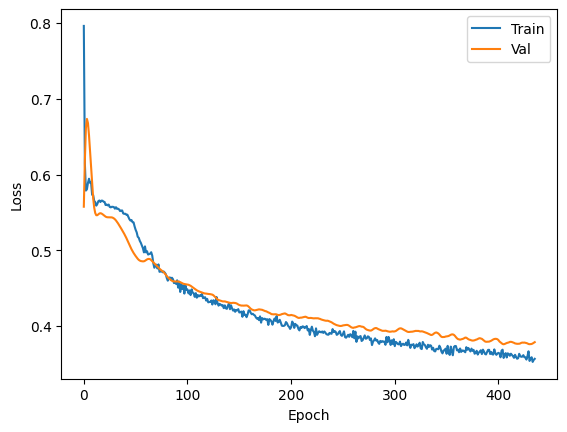

In [130]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

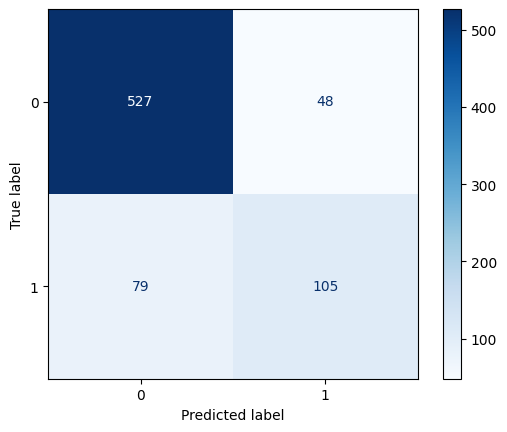

Accuracy: 0.8327
Precision: 0.6863
Recall: 0.5707
f1 score: 0.6231


In [131]:
model.eval()
with torch.no_grad():
    out_mlp = model(data.x[data.test_mask])
# pred = out.argmax(dim=1)  # Use the class with highest probability.
pred_mlp = F.sigmoid(out_mlp).round()

y_true = data.y[data.test_mask].numpy()
y_pred = pred_mlp.numpy()

cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()


print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [132]:
import shap

shap.initjs()

shap_data = data.x[data.train_mask]

# 데이터 수가 많을수록 시간이 오래걸립니다.
background = shap_data[np.random.choice(shap_data.shape[0], 2000, replace=False)]
shap_test = data.x[data.test_mask][np.random.choice(data.x[data.test_mask].shape[0], 200, replace=False)]

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(shap_test, check_additivity=False)

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


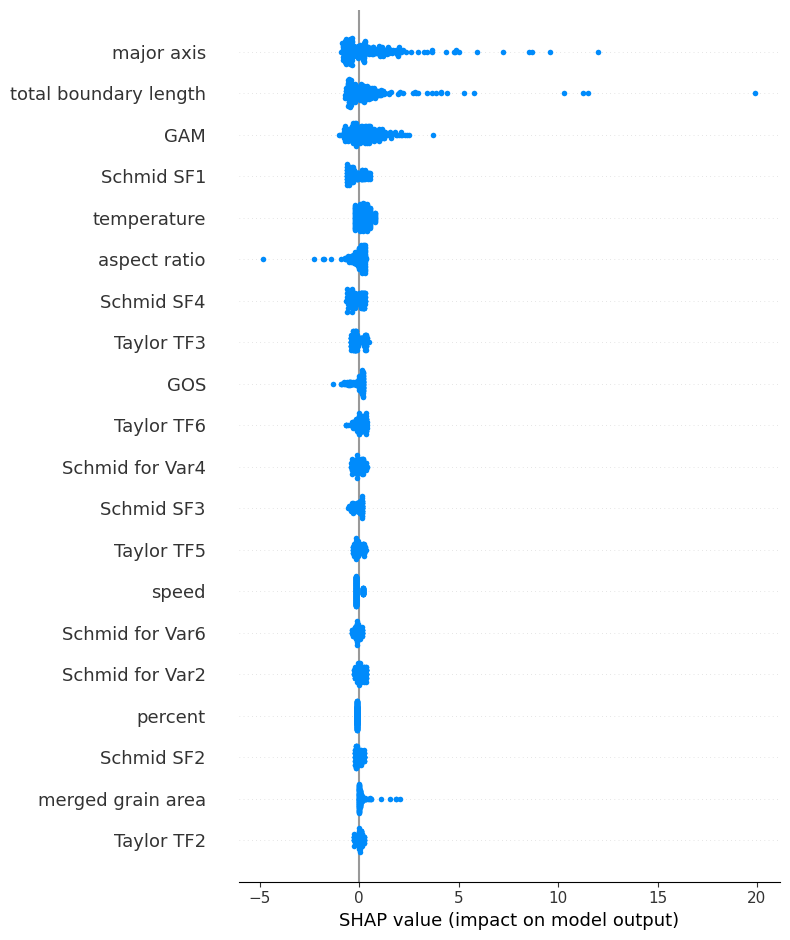

In [133]:
# exp = shap.Explanation(shap_values.squeeze(), feature_names=FEATURE_COLS)
# shap.plots.beeswarm(exp, color=['red', 'blue'])

shap.summary_plot(shap_values.squeeze(), feature_names=COLS_TO_USE)

In [134]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

342,017
GCN model number of params: 342,017


In [135]:
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.7054 / Val_loss: 0.7106
Epoch: 002, Train_loss: 0.8768 / Val_loss: 0.8773
Epoch: 003, Train_loss: 0.6406 / Val_loss: 0.6534
Epoch: 004, Train_loss: 0.6292 / Val_loss: 0.6336
Epoch: 005, Train_loss: 0.6641 / Val_loss: 0.6702
Epoch: 006, Train_loss: 0.6643 / Val_loss: 0.6750
Epoch: 007, Train_loss: 0.6437 / Val_loss: 0.6630
Epoch: 008, Train_loss: 0.6094 / Val_loss: 0.6141
Epoch: 009, Train_loss: 0.5969 / Val_loss: 0.5950
Epoch: 010, Train_loss: 0.6049 / Val_loss: 0.6079
Epoch: 011, Train_loss: 0.6091 / Val_loss: 0.6087
Epoch: 012, Train_loss: 0.6103 / Val_loss: 0.6174
Epoch: 013, Train_loss: 0.6081 / Val_loss: 0.6005
Epoch: 014, Train_loss: 0.6039 / Val_loss: 0.6061
Epoch: 015, Train_loss: 0.5904 / Val_loss: 0.5861
Epoch: 016, Train_loss: 0.5859 / Val_loss: 0.5893
Epoch: 017, Train_loss: 0.5854 / Val_loss: 0.5940
Epoch: 018, Train_loss: 0.5917 / Val_loss: 0.5920
Epoch: 019, Train_loss: 0.5958 / Val_loss: 0.5910
Epoch: 020, Train_loss: 0.5918 / Val_loss: 0.5931


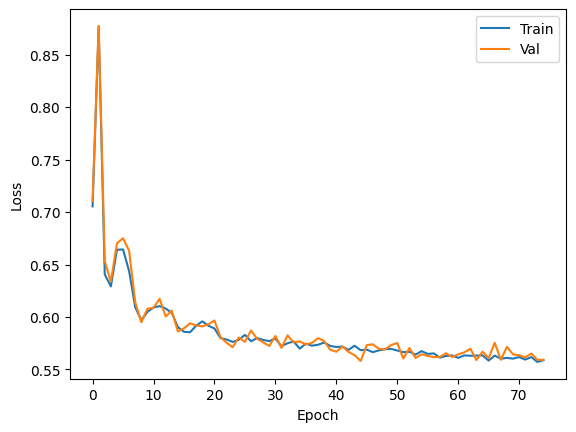

In [136]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [137]:
model.eval()
# pred = out.argmax(dim=1)  # Use the class with highest probability.
with torch.no_grad():
    out_gcn = model(data.x, data.edge_index)
pred_gcn = F.sigmoid(out_gcn).round()

y_pred = pred_gcn[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

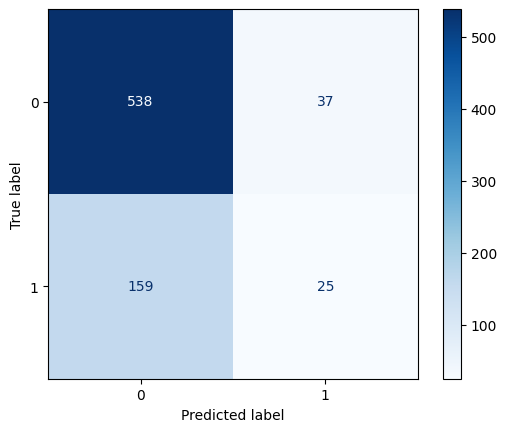

Accuracy: 0.7418
Precision: 0.4032
Recall: 0.1359
f1 score: 0.2033


In [138]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [139]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

344,707
GAT model number of params: 344,707


In [140]:
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.6349 / Val_loss: 0.6623
Epoch: 002, Train_loss: 0.6781 / Val_loss: 0.6885
Epoch: 003, Train_loss: 0.6288 / Val_loss: 0.5890
Epoch: 004, Train_loss: 0.6138 / Val_loss: 0.6423
Epoch: 005, Train_loss: 0.6000 / Val_loss: 0.6165
Epoch: 006, Train_loss: 0.6048 / Val_loss: 0.6016
Epoch: 007, Train_loss: 0.6076 / Val_loss: 0.5959
Epoch: 008, Train_loss: 0.5849 / Val_loss: 0.5920
Epoch: 009, Train_loss: 0.5689 / Val_loss: 0.5691
Epoch: 010, Train_loss: 0.5704 / Val_loss: 0.5746
Epoch: 011, Train_loss: 0.5755 / Val_loss: 0.5747
Epoch: 012, Train_loss: 0.5707 / Val_loss: 0.5756
Epoch: 013, Train_loss: 0.5608 / Val_loss: 0.5690
Epoch: 014, Train_loss: 0.5580 / Val_loss: 0.5618
Epoch: 015, Train_loss: 0.5584 / Val_loss: 0.5555
Epoch: 016, Train_loss: 0.5617 / Val_loss: 0.5720
Epoch: 017, Train_loss: 0.5613 / Val_loss: 0.5579
Epoch: 018, Train_loss: 0.5600 / Val_loss: 0.5551
Epoch: 019, Train_loss: 0.5523 / Val_loss: 0.5659
Epoch: 020, Train_loss: 0.5522 / Val_loss: 0.5592


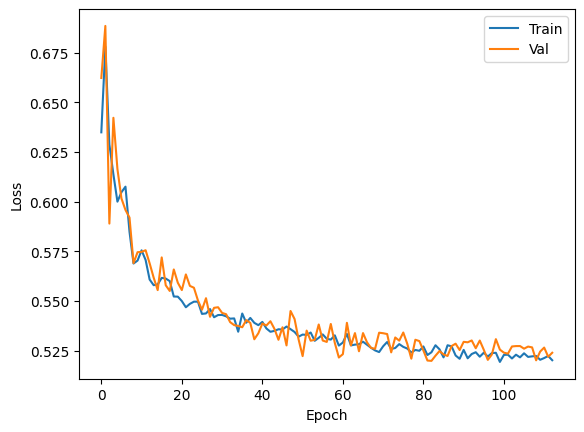

In [141]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [142]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

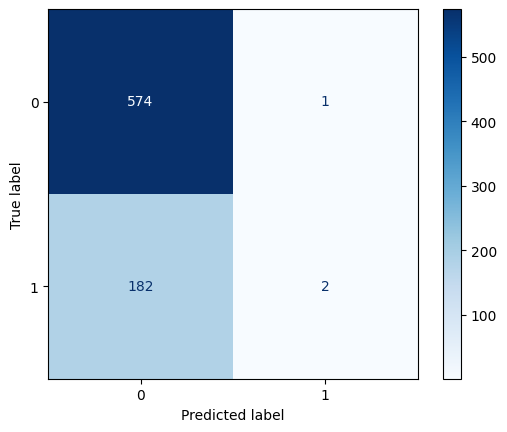

Accuracy: 0.7589
Precision: 0.6667
Recall: 0.0109
f1 score: 0.0214


In [143]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

`V90`을 활용하여 모델을 훈련 및 성능을 평가합니다.

In [144]:
# 사용할 특징들 자료형 등 확인
df_v90[FEATURE_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12307 entries, 0 to 12306
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   phi1                   12307 non-null  float64
 1   phi                    12307 non-null  float64
 2   phi2                   12307 non-null  float64
 3   merged grain area      12307 non-null  int64  
 4   major axis             12307 non-null  float64
 5   aspect ratio           12307 non-null  float64
 6   total boundary length  12307 non-null  int64  
 7   GOS                    12307 non-null  float64
 8   GAM                    12307 non-null  float64
 9   Schmid SF1             12307 non-null  float64
 10  Schmid SF2             12307 non-null  float64
 11  Schmid SF3             12307 non-null  float64
 12  Schmid SF4             12307 non-null  float64
 13  Schmid SF5             12307 non-null  float64
 14  Schmid SF6             12307 non-null  float64
 15  Ta

In [145]:
# 사용할 특징들 기본 통계 수치 확인
df_v90[FEATURE_COLS].describe()

phi1           phi          phi2  merged grain area  \
count  12307.000000  12307.000000  12307.000000       12307.000000   
mean      29.327688    279.545020     28.574805         326.848460   
std       29.802933    129.233214     31.465159         849.629385   
min        0.001707      0.003442      0.023277          10.000000   
25%       10.878823    311.523632     10.291727          34.000000   
50%       23.498590    339.053111     21.884090         103.000000   
75%       47.308728    352.236914     46.101220         291.000000   
max      359.975532    359.998335    359.990164       17931.000000   

         major axis  aspect ratio  total boundary length           GOS  \
count  12307.000000  12307.000000           12307.000000  12307.000000   
mean      21.645039      2.109751              87.440725      1.384319   
std       20.293471      1.160637             109.597780      1.257762   
min        3.685321      1.000000              14.000000      0.073730   
25%        9.229709      1.441825              33.000000      0.545042   
50%       15.775999      1.785983              58.000000      0.954953   
75%       26.622334      2.355701              99.000000      1.785729   
max      246.901174     20.813044            2365.000000     13.286989   

                GAM    Schmid SF1  ...  Schmid for Var1  Schmid for Var2  \
count  12307.000000  12307.000000  ...     12307.000000     12307.000000   
mean       0.954272      0.350650  ...         0.288637         0.288966   
std        0.597687      0.119692  ...         0.178513         0.178991   
min        0.129033      0.000385  ...        -0.373746        -0.374390   
25%        0.519467      0.273192  ...         0.189786         0.190821   
50%        0.816853      0.383132  ...         0.338206         0.337440   
75%        1.228477      0.448277  ...         0.429503         0.430335   
max        7.579747      0.499994  ...         0.499829         0.499822   

       Schmid for Var3  Schmid for Var4  Schmid for Var5  Schmid for Var6  \
count     12307.000000     12307.000000     12307.000000     12307.000000   
mean          0.289052         0.289272         0.189593         0.189043   
std           0.178311         0.178521         0.252092         0.251340   
min          -0.370984        -0.373891        -0.499997        -0.498906   
25%           0.191734         0.189894         0.033589         0.035536   
50%           0.339100         0.339255         0.256642         0.257426   
75%           0.429080         0.430330         0.395111         0.393196   
max           0.499677         0.499828         0.499997         0.499994   

            percent   temperature         speed  direction  
count  12307.000000  12307.000000  12307.000000    12307.0  
mean       4.941009    228.745836      0.504916       90.0  
std        1.999211    116.251141      0.499996        0.0  
min        3.000000     25.000000      0.000000       90.0  
25%        3.000000    175.000000      0.000000       90.0  
50%        3.000000    225.000000      1.000000       90.0  
75%        7.000000    325.000000      1.000000       90.0  
max        7.000000    425.000000      1.000000       90.0  

[8 rows x 31 columns]

In [146]:
edges = []
edge_info = df_v90[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info):
    for e in e_list:
        df_set = df_v90[df_v90["set_num"] == df_v90.iloc[i]["set_num"]]
        node = df_set.index[df_set["merged ID"] == e].to_list()[0]
        
        new = [i, node]
        edges.append(new)
        
edge_index = torch.Tensor(edges).to(dtype=torch.long).t()

In [147]:
# 확인
edge_index

tensor([[    0,     0,     0,  ..., 12305, 12305, 12306],
        [   12,    60,   174,  ..., 12241, 12303, 12279]])

In [149]:
y = (df_v90["daughter grains percent"] > 0).astype(int).to_numpy()

In [150]:
np.random.seed(1105)

train_ratio = 0.8

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 9845
len(val_indices) = 1231
len(test_indices) = 1231
split done!


In [151]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [152]:
COLS_TO_USE = FEATURE_COLS

X_train = df_v90.loc[train_mask.numpy(), COLS_TO_USE]
X_val = df_v90.loc[val_mask.numpy(), COLS_TO_USE]
X_test = df_v90.loc[test_mask.numpy(), COLS_TO_USE]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (9845, 31) / (1231, 31) / (1231, 31)
y_train.shape = (9845,) / (1231,) / (1231,)


In [153]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [154]:
X = np.zeros_like(df_v90[COLS_TO_USE])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [155]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [156]:
# 데이터 확인
data

Data(x=[12307, 31], edge_index=[2, 66188], y=[12307], train_mask=[12307], val_mask=[12307], test_mask=[12307])

In [157]:
pd.DataFrame(X, columns=COLS_TO_USE).describe()

phi1           phi          phi2  merged grain area  \
count  12307.000000  12307.000000  12307.000000       12307.000000   
mean       0.005260      0.006733     -0.002604           0.006098   
std        1.010406      0.994639      0.990917           1.002433   
min       -0.988976     -2.144750     -0.901763          -0.367735   
25%       -0.620210      0.252856     -0.578384          -0.339418   
50%       -0.192364      0.464735     -0.213311          -0.258009   
75%        0.614869      0.566204      0.549347          -0.036198   
max       11.215180      0.625940     10.434498          20.776304   

         major axis  aspect ratio  total boundary length           GOS  \
count  12307.000000  12307.000000           12307.000000  12307.000000   
mean       0.012743      0.002479               0.007178      0.006415   
std        1.012772      0.996648               1.000527      1.001907   
min       -0.883561     -0.950472              -0.663269     -1.037573   
25%       -0.606861     -0.571074              -0.489816     -0.662136   
50%       -0.280160     -0.275543              -0.261589     -0.335609   
75%        0.261141      0.213679               0.112704      0.326169   
max       11.254443     16.063133              20.799207      9.487831   

                GAM    Schmid SF1  ...  Schmid for Var1  Schmid for Var2  \
count  12307.000000  12307.000000  ...     12307.000000     12307.000000   
mean      -0.000906     -0.002809  ...         0.000575         0.000105   
std        1.001666      0.998290  ...         0.999697         1.000577   
min       -1.383929     -2.924200  ...        -3.708865        -3.708114   
25%       -0.729597     -0.648852  ...        -0.553006        -0.548534   
50%       -0.231206      0.268106  ...         0.278170         0.271081   
75%        0.458636      0.811446  ...         0.789443         0.790369   
max       11.102767      1.242788  ...         1.183279         1.178810   

       Schmid for Var3  Schmid for Var4  Schmid for Var5  Schmid for Var6  \
count     12307.000000     12307.000000     12307.000000     12307.000000   
mean         -0.002267        -0.002018        -0.000936        -0.000778   
std           1.005634         1.006099         1.003879         1.002700   
min          -3.724727        -3.739436        -2.747015        -2.745289   
25%          -0.551115        -0.562091        -0.622171        -0.613183   
50%           0.279994         0.279672         0.266068         0.272030   
75%           0.787466         0.792947         0.817478         0.813670   
max           1.185618         1.184622         1.235154         1.239732   

            percent   temperature         speed  direction  
count  12307.000000  12307.000000  12307.000000    12307.0  
mean      -0.002173     -0.008836     -0.004897        0.0  
std        0.999979      0.994173      1.000101        0.0  
min       -0.973040     -1.751260     -1.014838        0.0  
25%       -0.973040     -0.468468     -1.014838        0.0  
50%       -0.973040     -0.040870      0.985379        0.0  
75%        1.027707      0.814324      0.985379        0.0  
max        1.027707      1.669519      0.985379        0.0  

[8 rows x 31 columns]

In [158]:
# 필요 시 아래의 모델 하이퍼파라미터 부분 주석을 해제하여 사용합니다.
# 크게 다르지 않은 경향을 보여주었습니다.
rf_model = RandomForestClassifier(
    # n_estimators=30,
    # max_depth=10,
    # random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


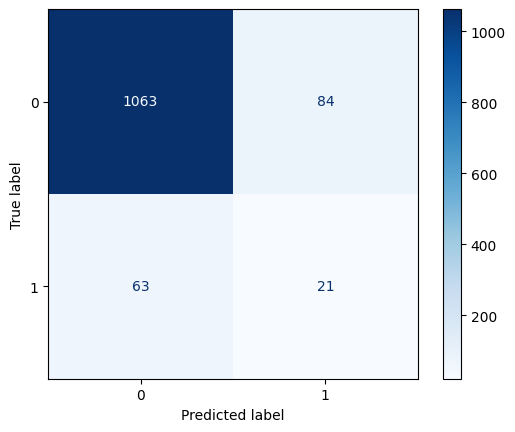

Accuracy: 0.8806
Precision: 0.2000
Recall: 0.2500
f1 score: 0.2222


In [159]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

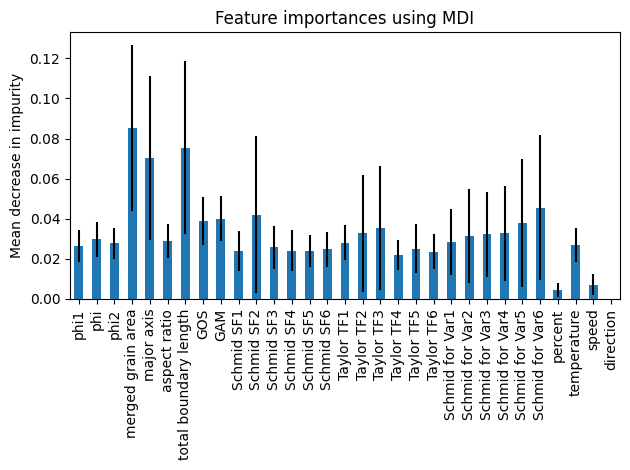

In [160]:
importances = rf_model.feature_importances_
forest_std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=COLS_TO_USE)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=forest_std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


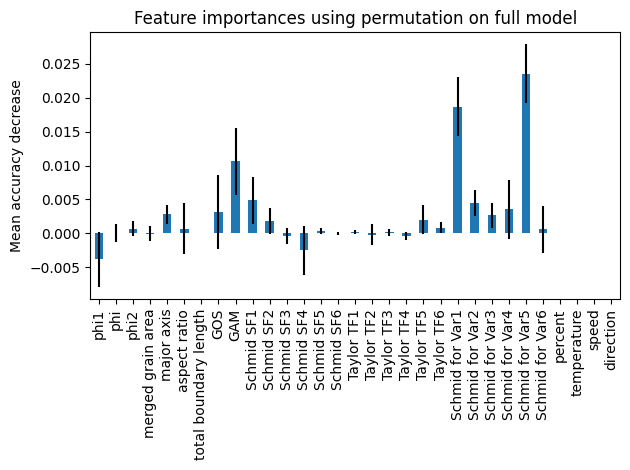

In [161]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=30, random_state=1105, n_jobs=3
)
pm_importances = pd.Series(result.importances_mean, index=COLS_TO_USE)

fig, ax = plt.subplots()
pm_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [162]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


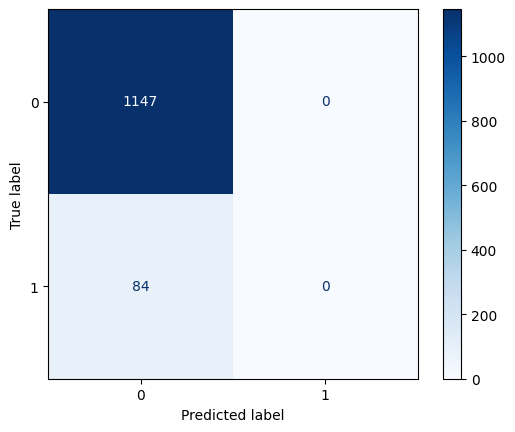

Accuracy: 0.9318
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [163]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [164]:
from sklearn.svm import LinearSVC

# class_weight을 통해 클래스별 가중치를 줄 수 있습니다.
# 이는 클래스 불균형 시 도움이 될 수 있으나, 실험해봤을 때 경향에 큰 차이를 주지는 않았습니다.
class_weight = {
    0: 1.0,
    1: 10.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


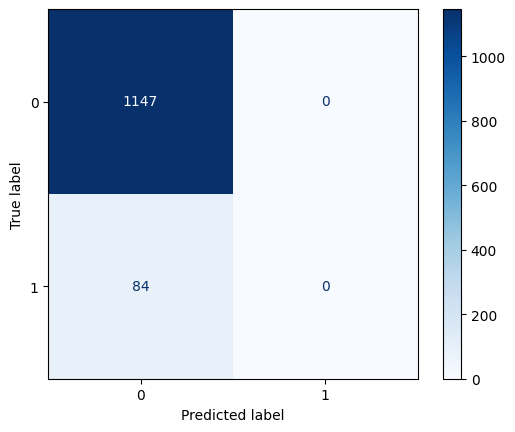

Accuracy: 0.9318
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [165]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [166]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 1)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

342,017
MLP model number of params: 342,017


In [167]:
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000

# overfitting 시 훈련 종료를 위해 사용하는 허용 epoch 수입니다.
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp).squeeze()  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp).squeeze()
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.8325 / Val_loss: 0.3140
Epoch: 002, Train_loss: 0.5286 / Val_loss: 0.2585
Epoch: 003, Train_loss: 0.3794 / Val_loss: 0.2510
Epoch: 004, Train_loss: 0.3155 / Val_loss: 0.2507
Epoch: 005, Train_loss: 0.2862 / Val_loss: 0.2520
Epoch: 006, Train_loss: 0.2702 / Val_loss: 0.2538
Epoch: 007, Train_loss: 0.2622 / Val_loss: 0.2556
Epoch: 008, Train_loss: 0.2599 / Val_loss: 0.2572
Epoch: 009, Train_loss: 0.2601 / Val_loss: 0.2587
Epoch: 010, Train_loss: 0.2605 / Val_loss: 0.2598
Epoch: 011, Train_loss: 0.2541 / Val_loss: 0.2607
Epoch: 012, Train_loss: 0.2586 / Val_loss: 0.2614
Epoch: 013, Train_loss: 0.2609 / Val_loss: 0.2619
Epoch: 014, Train_loss: 0.2597 / Val_loss: 0.2622
Epoch: 015, Train_loss: 0.2609 / Val_loss: 0.2623
Epoch: 016, Train_loss: 0.2605 / Val_loss: 0.2622
Epoch: 017, Train_loss: 0.2594 / Val_loss: 0.2619
Epoch: 018, Train_loss: 0.2596 / Val_loss: 0.2615
Epoch: 019, Train_loss: 0.2558 / Val_loss: 0.2609
Epoch: 020, Train_loss: 0.2585 / Val_loss: 0.2602


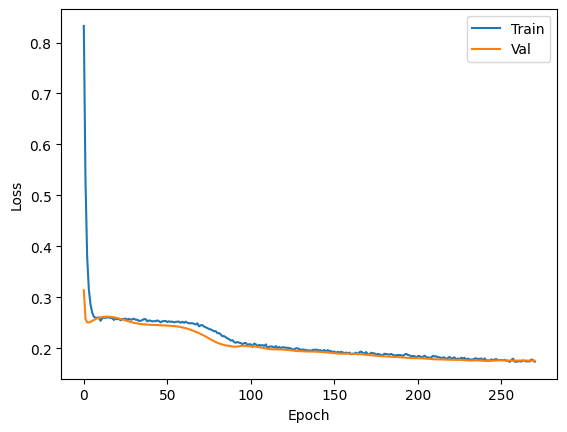

In [168]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

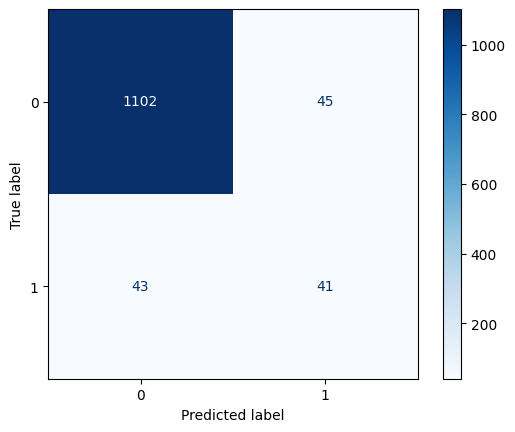

Accuracy: 0.9285
Precision: 0.4767
Recall: 0.4881
f1 score: 0.4824


In [169]:
model.eval()
with torch.no_grad():
    out_mlp = model(data.x[data.test_mask])
# pred = out.argmax(dim=1)  # Use the class with highest probability.
pred_mlp = F.sigmoid(out_mlp).round()

y_true = data.y[data.test_mask].numpy()
y_pred = pred_mlp.numpy()

cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()


print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [170]:
import shap

shap.initjs()

shap_data = data.x[data.train_mask]

# 데이터 수가 많을수록 시간이 오래걸립니다.
background = shap_data[np.random.choice(shap_data.shape[0], 2000, replace=False)]
shap_test = data.x[data.test_mask][np.random.choice(data.x[data.test_mask].shape[0], 200, replace=False)]

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(shap_test, check_additivity=False)

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


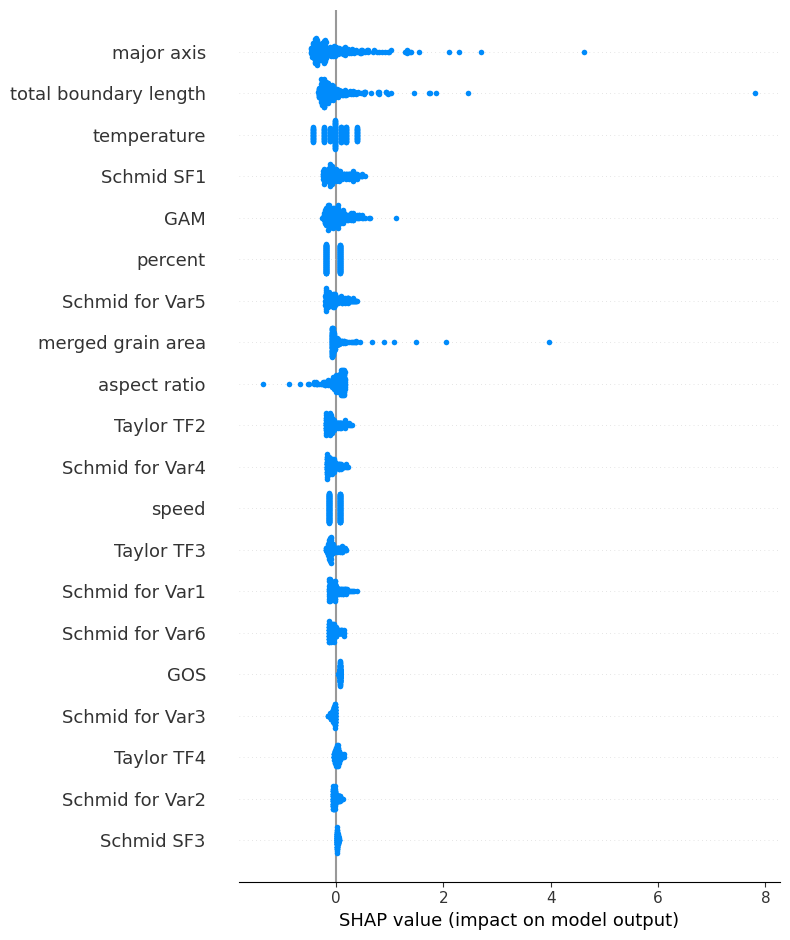

In [171]:
# exp = shap.Explanation(shap_values.squeeze(), feature_names=FEATURE_COLS)
# shap.plots.beeswarm(exp, color=['red', 'blue'])

shap.summary_plot(shap_values.squeeze(), feature_names=COLS_TO_USE)

In [172]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

342,017
GCN model number of params: 342,017


In [173]:
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.3363 / Val_loss: 0.3373
Epoch: 002, Train_loss: 0.3475 / Val_loss: 0.3621
Epoch: 003, Train_loss: 0.3427 / Val_loss: 0.3540
Epoch: 004, Train_loss: 0.3142 / Val_loss: 0.3283
Epoch: 005, Train_loss: 0.2921 / Val_loss: 0.3029
Epoch: 006, Train_loss: 0.2895 / Val_loss: 0.3009
Epoch: 007, Train_loss: 0.3002 / Val_loss: 0.3109
Epoch: 008, Train_loss: 0.2930 / Val_loss: 0.3063
Epoch: 009, Train_loss: 0.2878 / Val_loss: 0.2866
Epoch: 010, Train_loss: 0.2834 / Val_loss: 0.2937
Epoch: 011, Train_loss: 0.2829 / Val_loss: 0.2960
Epoch: 012, Train_loss: 0.2827 / Val_loss: 0.2865
Epoch: 013, Train_loss: 0.2848 / Val_loss: 0.2856
Epoch: 014, Train_loss: 0.2855 / Val_loss: 0.2978
Epoch: 015, Train_loss: 0.2838 / Val_loss: 0.2941
Epoch: 016, Train_loss: 0.2821 / Val_loss: 0.2810
Epoch: 017, Train_loss: 0.2783 / Val_loss: 0.2825
Epoch: 018, Train_loss: 0.2762 / Val_loss: 0.2830
Epoch: 019, Train_loss: 0.2778 / Val_loss: 0.2862
Epoch: 020, Train_loss: 0.2780 / Val_loss: 0.2815


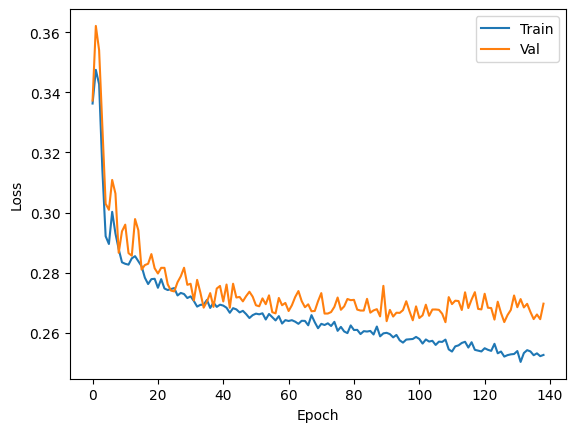

In [174]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [175]:
model.eval()
# pred = out.argmax(dim=1)  # Use the class with highest probability.
with torch.no_grad():
    out_gcn = model(data.x, data.edge_index)
pred_gcn = F.sigmoid(out_gcn).round()

y_pred = pred_gcn[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

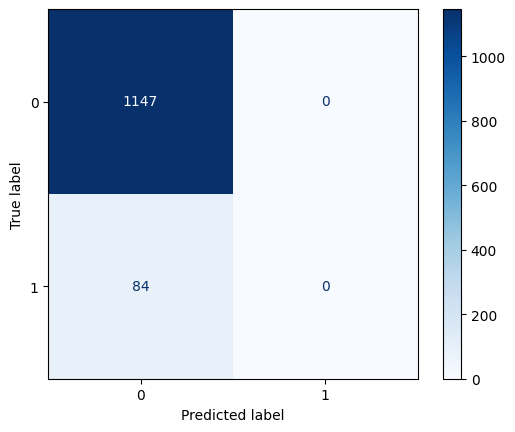

Accuracy: 0.9318
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [176]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [177]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

344,707
GAT model number of params: 344,707


In [178]:
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.5028 / Val_loss: 0.5008
Epoch: 002, Train_loss: 0.2976 / Val_loss: 0.3251
Epoch: 003, Train_loss: 0.2915 / Val_loss: 0.3070
Epoch: 004, Train_loss: 0.3168 / Val_loss: 0.3197
Epoch: 005, Train_loss: 0.3132 / Val_loss: 0.3235
Epoch: 006, Train_loss: 0.3101 / Val_loss: 0.3124
Epoch: 007, Train_loss: 0.2995 / Val_loss: 0.3063
Epoch: 008, Train_loss: 0.2869 / Val_loss: 0.2876
Epoch: 009, Train_loss: 0.2768 / Val_loss: 0.2797
Epoch: 010, Train_loss: 0.2699 / Val_loss: 0.2753
Epoch: 011, Train_loss: 0.2592 / Val_loss: 0.2578
Epoch: 012, Train_loss: 0.2588 / Val_loss: 0.2659
Epoch: 013, Train_loss: 0.2577 / Val_loss: 0.2598
Epoch: 014, Train_loss: 0.2601 / Val_loss: 0.2681
Epoch: 015, Train_loss: 0.2638 / Val_loss: 0.2715
Epoch: 016, Train_loss: 0.2617 / Val_loss: 0.2687
Epoch: 017, Train_loss: 0.2589 / Val_loss: 0.2593
Epoch: 018, Train_loss: 0.2589 / Val_loss: 0.2660
Epoch: 019, Train_loss: 0.2562 / Val_loss: 0.2614
Epoch: 020, Train_loss: 0.2499 / Val_loss: 0.2503


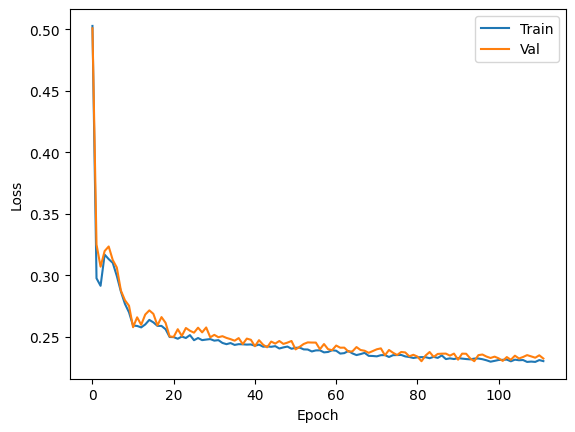

In [179]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [180]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

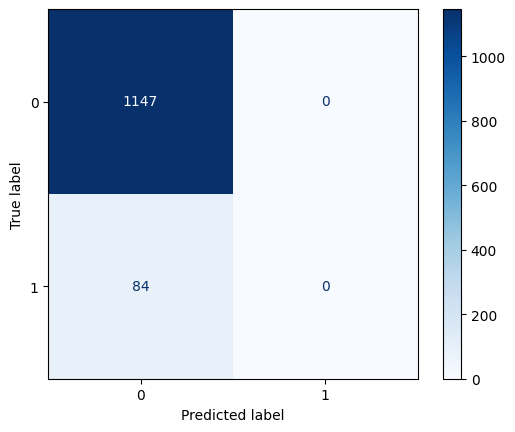

Accuracy: 0.9318
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [181]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

#### 6. 데이터 분석
- 데이터 자체에 대한 분석을 실시합니다.
- 또한, '인접 grain의 정보를 더했을 경우 모델의 쌍정 여부 예측 성능이 더 나아질 것이다.'라는 가설과 반대되는 결과가 나온 이유에 대해서 살펴봅니다. 이를 위해 `MLP`모델과 `GCN`모델이 틀린 샘플들을 비교합니다.
- 현재 분석 코드는 `df_v0`이나 `df_v90`등 데이터의 부분집합에 대한 분석이 아닌 전체 데이터 즉, `df`에 관해 나눠진 '훈련', '검증', '평가' 데이터셋에 대해 분석합니다.
- 이를 위해 해당 노트북의 상위에 있는 `df` 관련 데이터셋 정의 및 모델 훈련 & 평가 코드를 다시 진행했습니다.

우선, 특징 간 상관관계를 확인해봅니다.

In [283]:
# new df with the answer
df_with_y = pd.concat([df, pd.Series(y, name="twin_or_not")], axis=1)

# delete columns that cannot be calculated in correlation analysis
df_with_y = df_with_y._get_numeric_data()

df_with_y.head()

merged ID  original grain id       phi1         phi       phi2  \
0          1                  1  51.992588  340.060929   7.927710   
1          2                  2  48.614823  347.530536  19.772951   
2          3                  5  40.321865  353.327411  25.271908   
3          4                  7  44.155840  351.273455  10.917894   
4          5                 10  18.402519  309.171717  18.854361   

   merged grain area  parent Area  daughter Area  other area  \
0                 13           13              0           0   
1                 18           18              0           0   
2                 27           27              0           0   
3                 14           14              0           0   
4                 30           30              0           0   

   no. of parent grains  ...  Rank for Var4  Rank for Var5  Rank for Var6  \
0                     1  ...              4              6              5   
1                     1  ...              2              6              5   
2                     1  ...              5              6              4   
3                     1  ...              3              1              2   
4                     1  ...              2              5              6   

   neighbor grains count  percent  temperature  speed  direction  set_num  \
0                      2        3          125      0          0        0   
1                      3        3          125      0          0        0   
2                      3        3          125      0          0        0   
3                      2        3          125      0          0        0   
4                      2        3          125      0          0        0   

   twin_or_not  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 64 columns]

데이터 전체가 서로 간의 어떤 상관관계를 갖는지 보여줍니다.

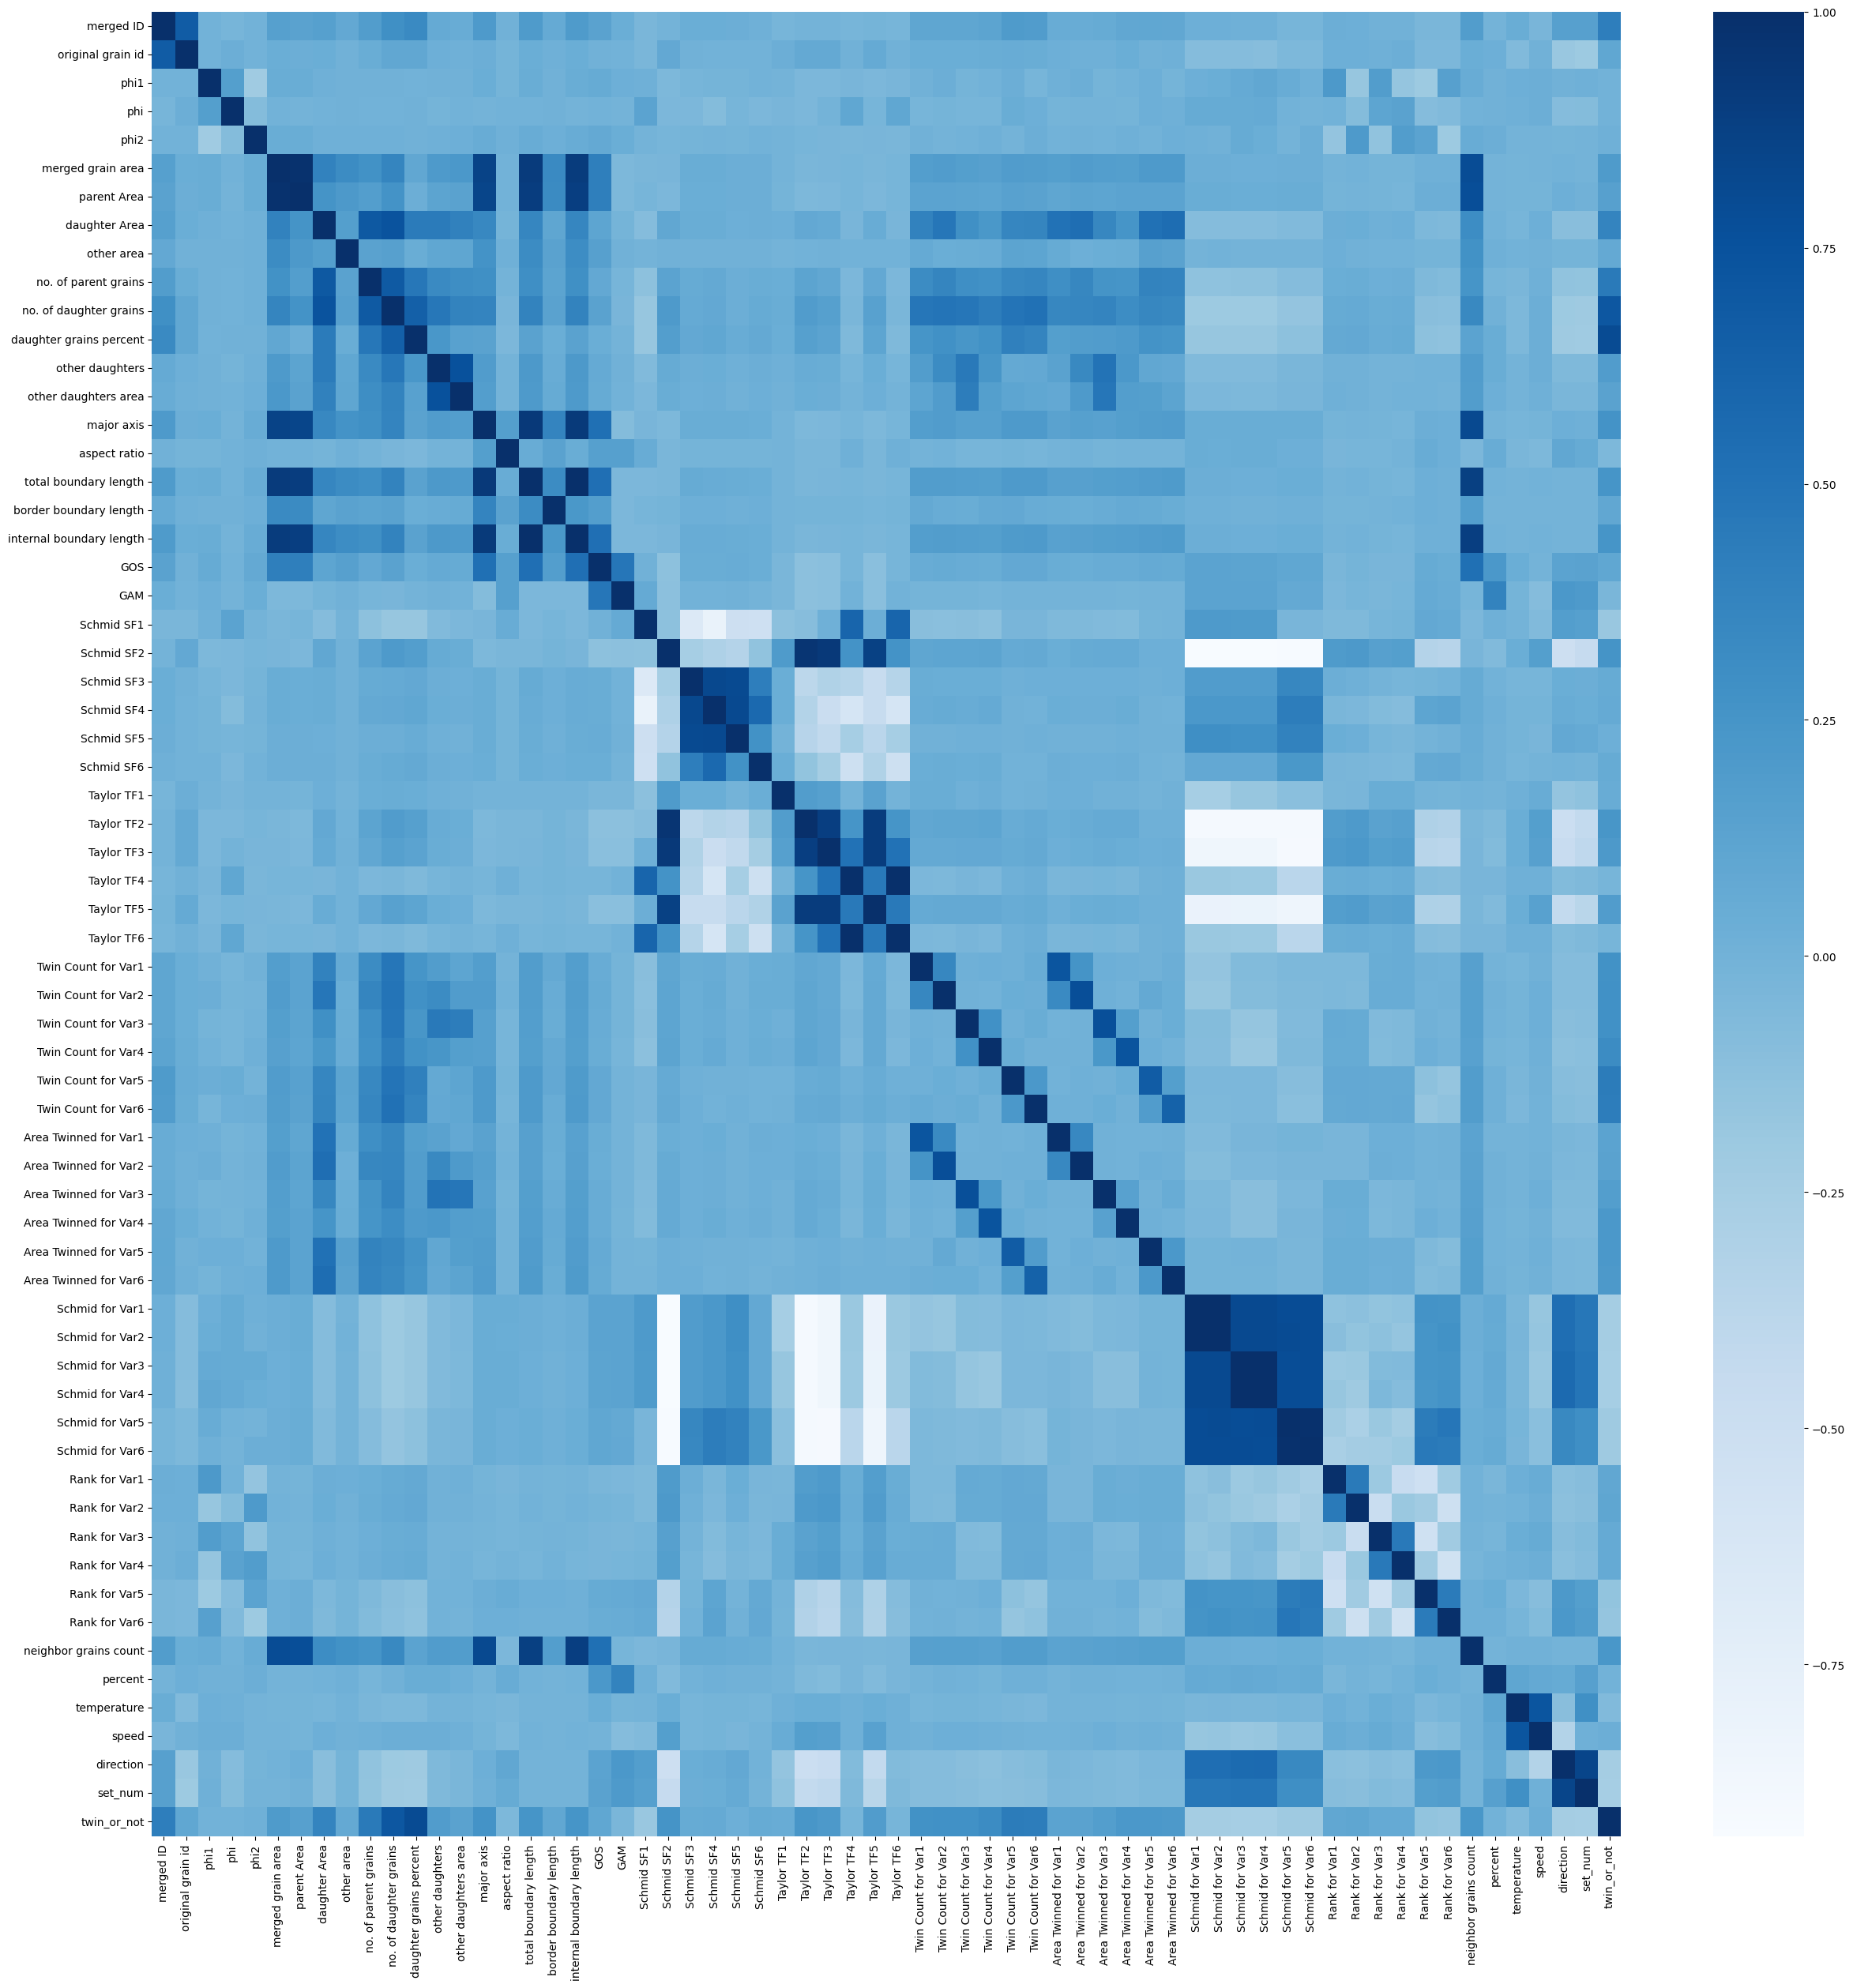

In [284]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_with_y.corr(), cmap="Blues")
plt.show()

이 중, 쌍정 여부(`twin_or_not`) 컬럼과의 상관관계만 분리해서 확인해봅니다. 또한, `merged grain area` 컬럼과 다른 특징들 간의 상관관계도 확인해봅니다.

`merged grain area` 컬럼은 결정립의 크기를 나타내는 특징으로서 쌍정 여부 예측에 큰 영향을 끼칠 것으로 생각되어 왔습니다. 그러나 위에서 확인해본 SHAPLY 값에서 상위권에 속하지 않았고, 오히려 결정립의 크기를 나타내는 다른 특징들 `total boundary length`, `major axis`는 모델의 분류에 영향을 끼친 것으로 나와서 과연 '`merged grain area`는 쌍정 여부와 관계가 없는 것인가?'에 대한 질문을 확인해보려 합니다.

먼저 사후에만 추출 가능한 특징들(예: `daughter Area`, `no. of daughter grains` 등)도 포함하여 상관관계를 확인합니다.

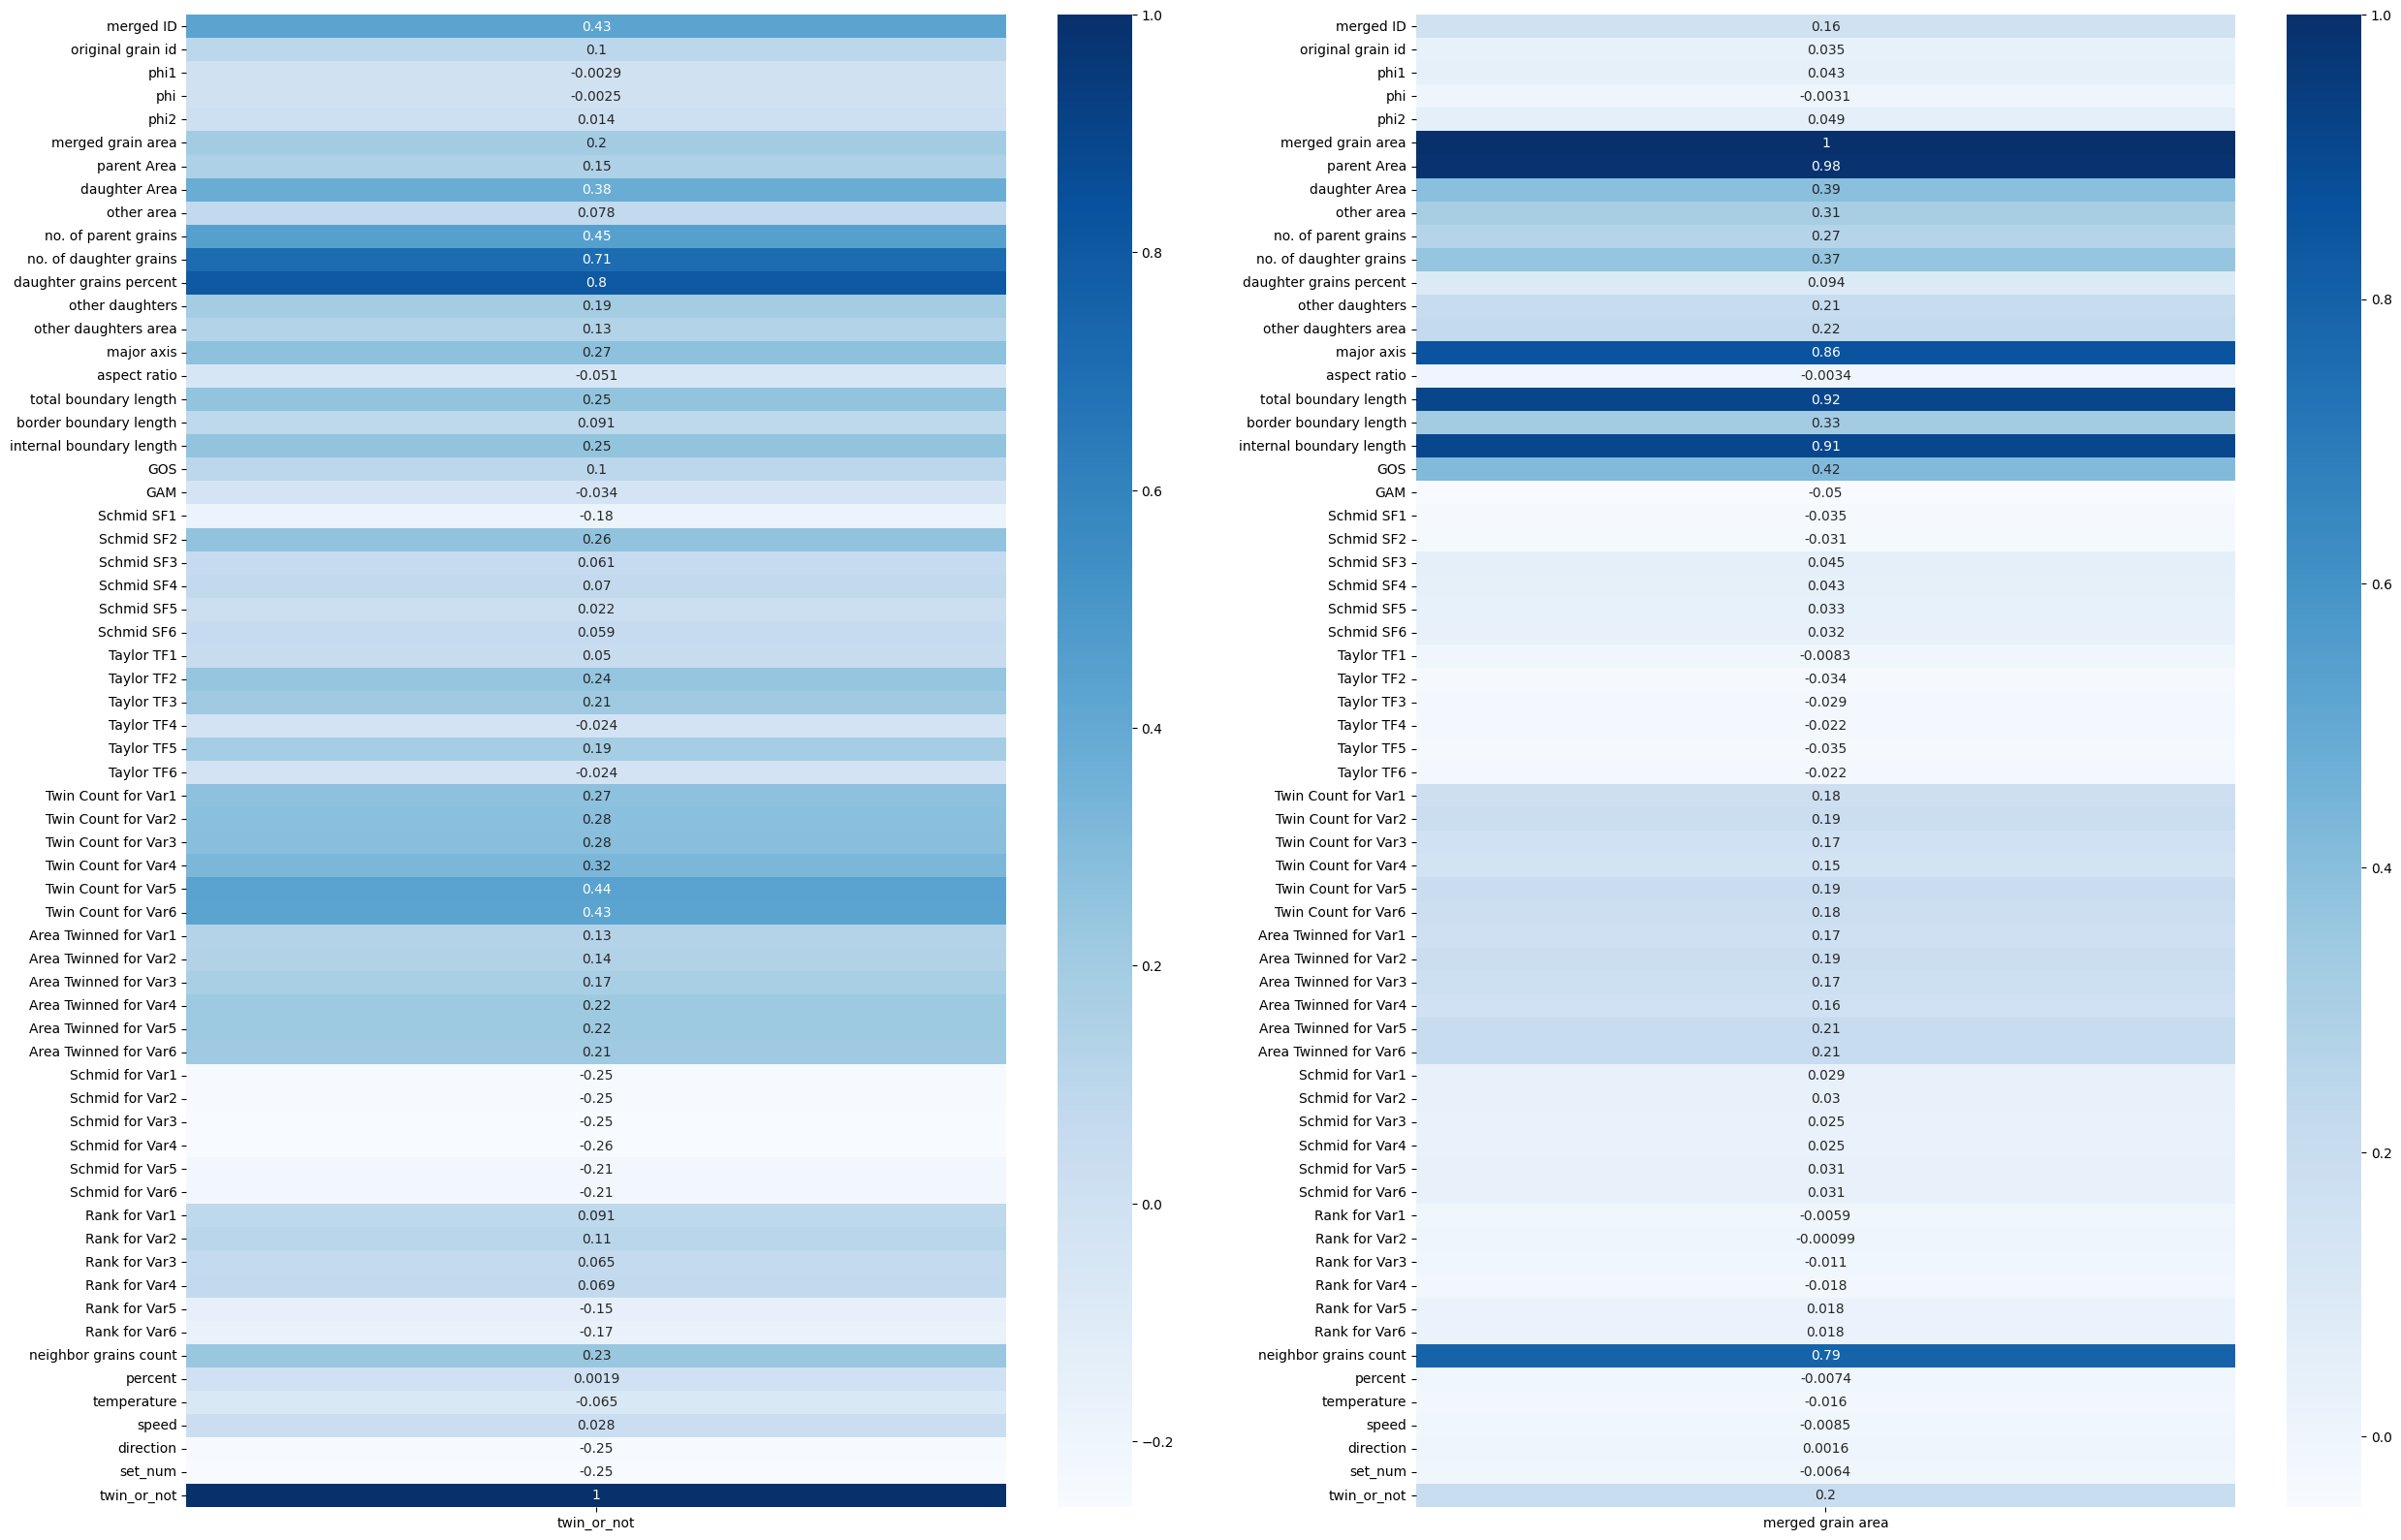

In [286]:
heatmap_data = df_with_y.corr()
h_1 = pd.DataFrame(heatmap_data["twin_or_not"])
h_2 = pd.DataFrame(heatmap_data["merged grain area"])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(30, 20)
sns.heatmap(h_1, cmap="Blues", annot=True, ax=axes[0])
sns.heatmap(h_2, cmap="Blues", annot=True, ax=axes[1])

file_name = "correlation.png"
plt.savefig(file_name, bbox_inches="tight")

plt.show()

다시 사전 추출 특징들로만 구성된 상관관계 그래프를 뽑아냅니다. 상관관계 숫자가 위와 달라지지는 않습니다.

결론적으로 상관관계를 확인해보면, `merged grain area`는 크기를 나타내는 다른 특징들 `total boundary length`나 `major axis`와 상관관계가 매우 높아서 마찬가지로 크기를 나타내는 특징으로 봐도 무방합니다. 하지만, 쌍정 여부(`twin_or_not`)와는 상대적으로 다소 낮은 상관관계를 보여서 SHAPLY 값에서 보였던 것과 마찬가지로 쌍정 여부에는 큰 영향을 미치지 않는 특징으로 확인이 되었습니다.

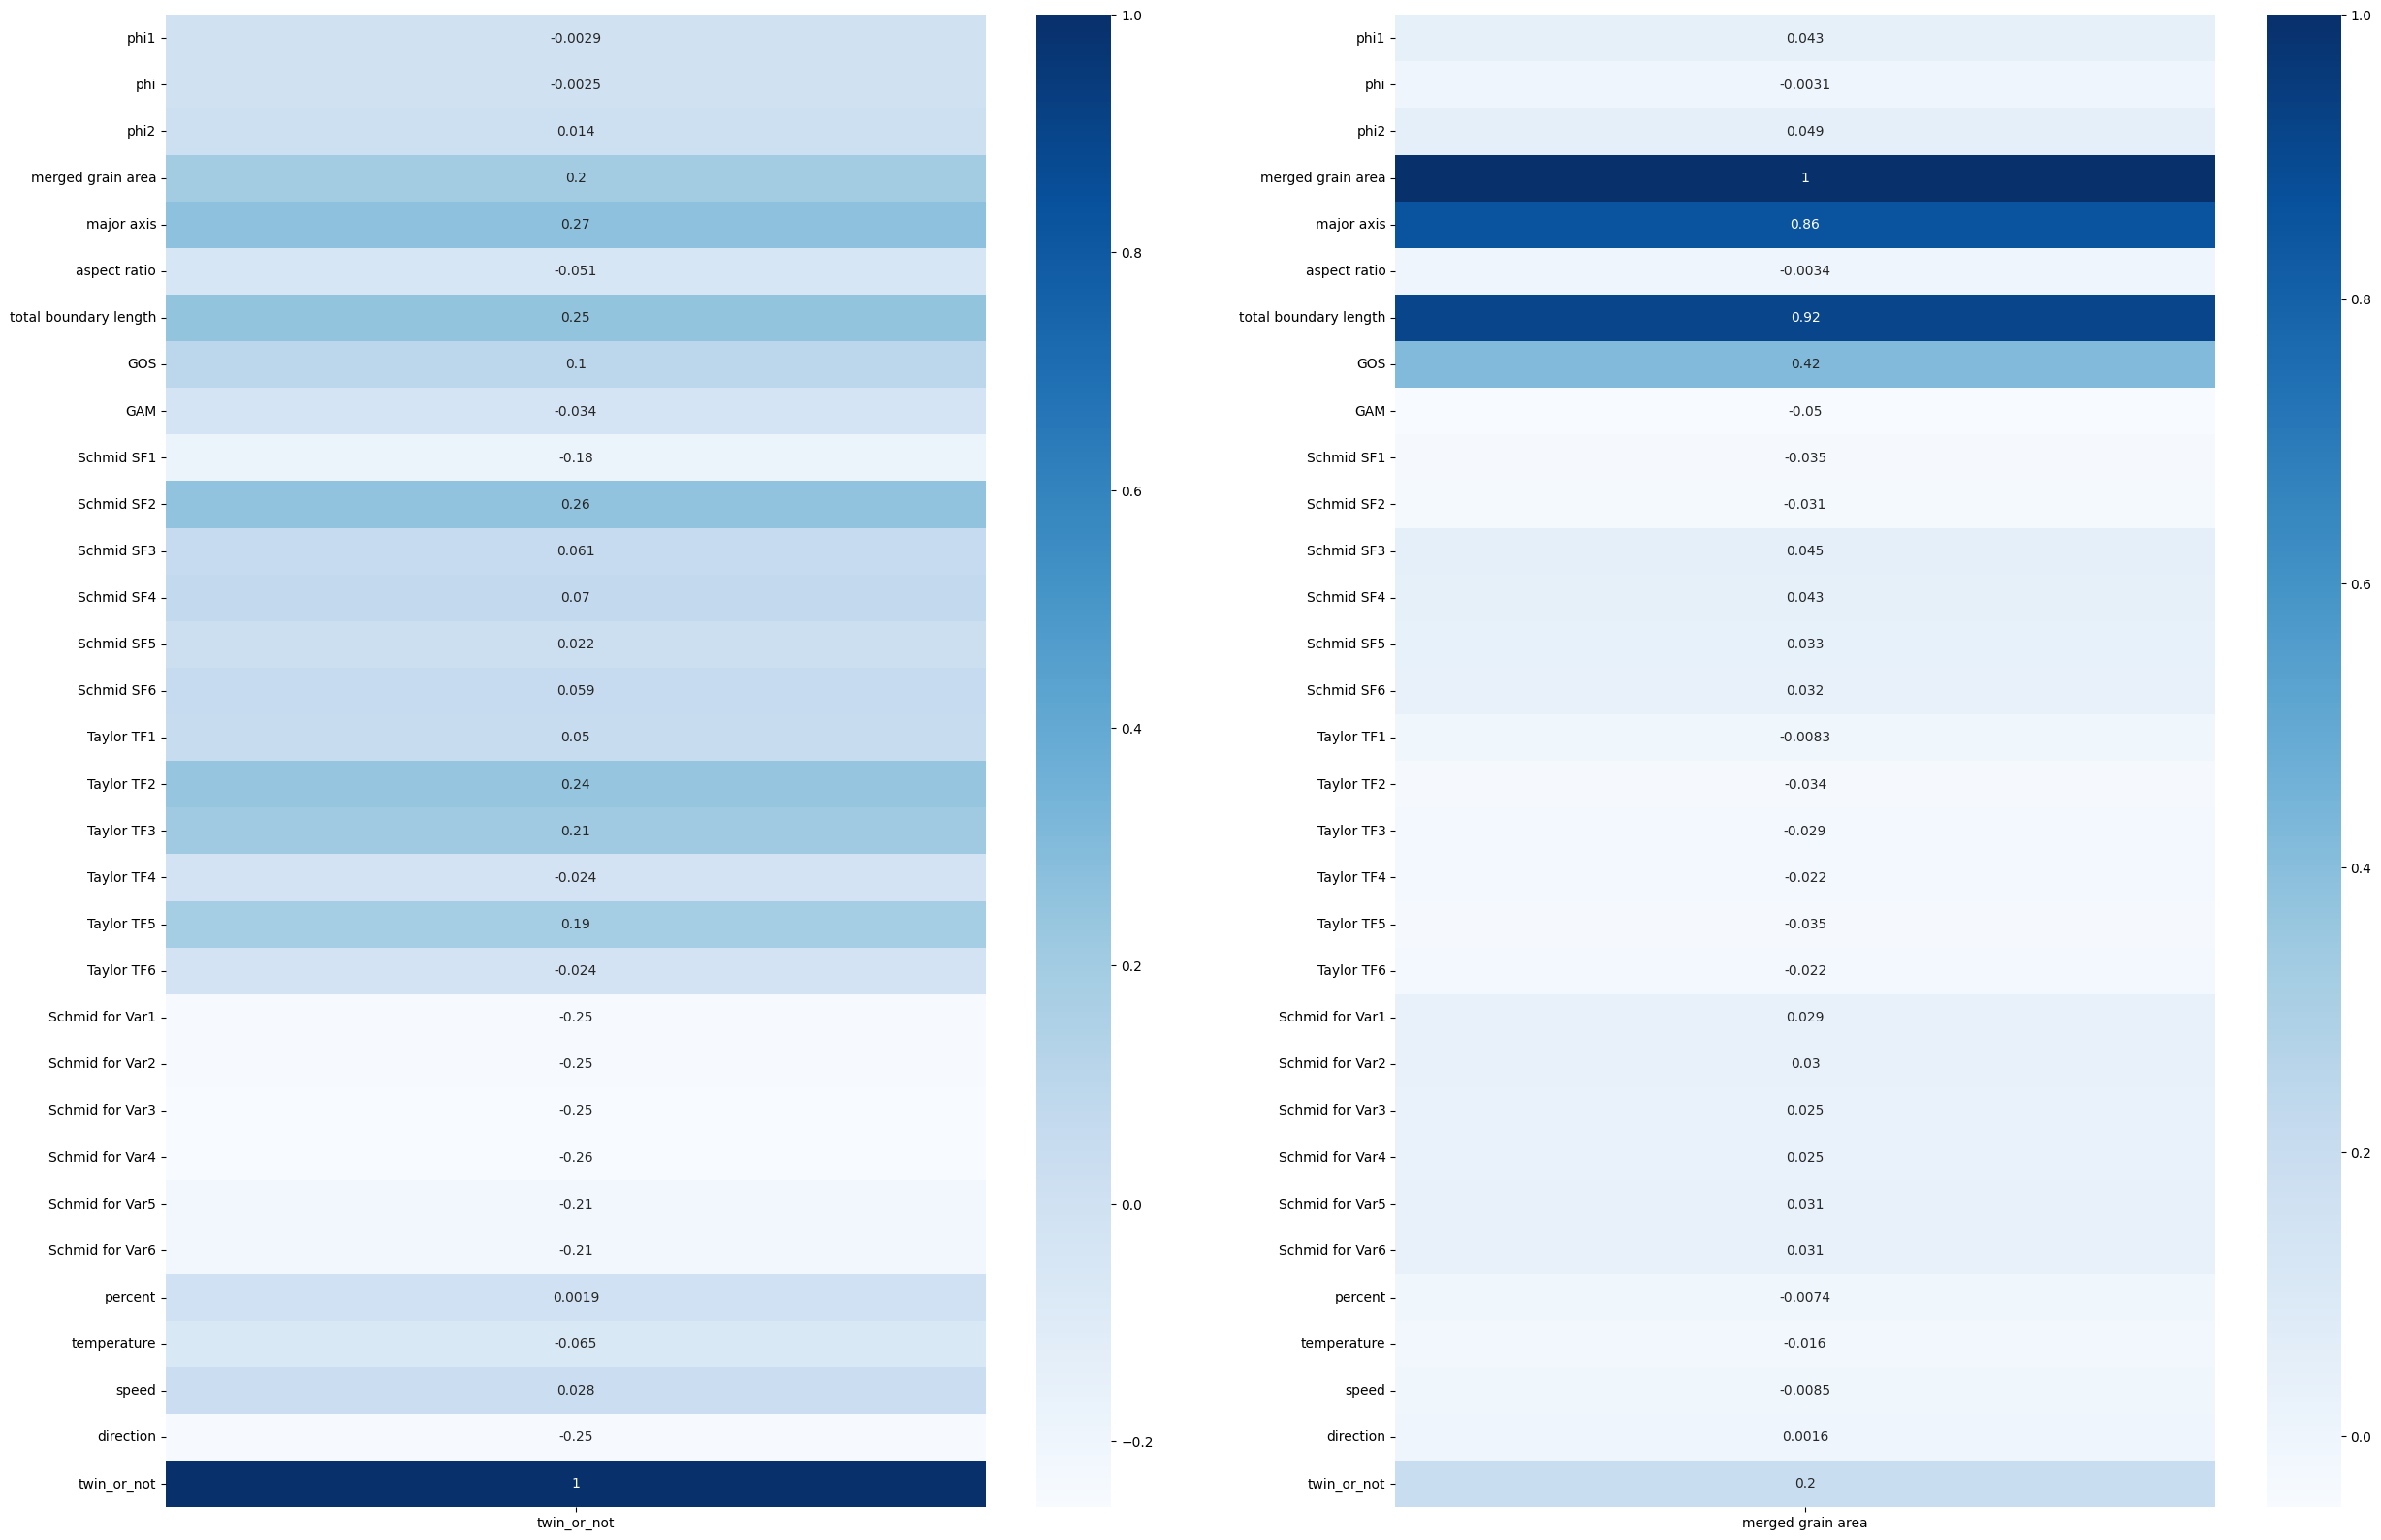

In [287]:
df_with_y_and_deleted_impactful_columns = df_with_y[FEATURE_COLS + ["twin_or_not"]]
heatmap_data = df_with_y_and_deleted_impactful_columns.corr()

h_1 = pd.DataFrame(heatmap_data["twin_or_not"])
h_2 = pd.DataFrame(heatmap_data["merged grain area"])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(30, 20)
sns.heatmap(h_1, cmap="Blues", annot=True, ax=axes[0])
sns.heatmap(h_2, cmap="Blues", annot=True, ax=axes[1])

file_name = "correlation_without_impactful_columns.png"
plt.savefig(file_name, bbox_inches="tight")

plt.show()

상관관계를 보았으니, 각각 모델이 틀린 샘플들과 관련한 데이터 분석을 진행합니다.

우선, MLP, GCN 각 모델이 틀린 샘플들을 추출합니다.

In [ ]:
# 테스트 데이터셋의 개수를 확인합니다.
y_true.shape

(1990,)

In [224]:
# MLP 모델의 아웃풋 개수를 확인합니다.
pred_mlp.shape

torch.Size([1990, 1])

In [225]:
# GCN 모델의 아웃풋 개수를 확인합니다.
pred_gcn[data.test_mask].shape

torch.Size([1990])

MLP 모델이 틀린 샘플 전체와 그 중에 `False Negative`, `False Postive` 샘플들을 변수에 할당합니다.

In [229]:
mlp = pred_mlp.squeeze().numpy()

mlp_fn = np.where(
    (y_true == 1) &
    (mlp == 0)
)[0]

mlp_fp = np.where(
    (y_true == 0) &
    (mlp == 1)
)[0]

mlp_f = np.where(
    y_true != mlp
)[0]
print(mlp_f)

# the number of wrong predictions shoule be 179
assert len(mlp_f) == 179
assert len(mlp_f) == len(mlp_fn) + len(mlp_fp)
assert len(set(mlp_fp).intersection(set(mlp_fn))) == 0

[  10   30   39   43   53   67   70  111  112  122  133  140  145  151
  156  158  159  160  162  166  167  173  176  178  183  184  190  192
  193  230  234  236  238  240  242  243  253  258  260  282  286  287
  297  298  310  312  320  349  351  355  359  361  380  386  412  414
  415  418  423  425  427  431  444  448  464  470  480  481  483  484
  494  495  496  497  498  499  500  502  508  509  511  523  534  543
  550  557  564  565  566  568  569  571  580  588  600  601  602  603
  604  605  608  609  611  612  613  614  617  618  630  656  658  660
  662  663  664  665  666  669  745  768  811  812  814  815  818  819
  886  888  889  890  891  947  977 1046 1047 1048 1049 1050 1051 1054
 1055 1056 1058 1141 1144 1145 1219 1220 1222 1223 1300 1301 1302 1337
 1384 1387 1388 1389 1443 1444 1445 1526 1528 1533 1583 1622 1623 1625
 1673 1674 1760 1763 1821 1822 1823 1897 1898 1899 1902]


GCN 모델이 틀린 샘플 전체와 그 중에 `False Negative`, `False Positive` 샘플들을 변수에 할당합니다.

In [230]:
gcn = pred_gcn[data.test_mask].numpy()

gcn_fn = np.where(
    (y_true == 1) &
    (gcn == 0)
)[0]

gcn_fp = np.where(
    (y_true == 0) &
    (gcn == 1)
)[0]

gcn_f = np.where(
    y_true != gcn
)[0]
print(gcn_f)

# the number of wrong predictions shoule be 317
assert len(gcn_f) == 317
assert len(gcn_f) == len(gcn_fn) + len(gcn_fp)
assert len(set(gcn_fp).intersection(set(gcn_fn))) == 0

[   1    3    4    5    6    7    8    9   12   13   17   18   19   20
   22   23   24   25   27   28   29   30   31   32   33   35   36   44
   53   76   80   87   91   94   95   97   98   99  111  112  113  114
  117  118  119  120  121  122  123  124  130  131  132  136  143  150
  152  160  165  166  167  168  170  171  173  174  176  177  178  183
  189  196  207  213  224  226  228  230  232  233  234  235  236  242
  244  250  255  258  260  261  263  264  265  267  268  272  278  285
  286  287  288  289  291  294  297  299  300  312  314  318  319  320
  336  349  350  351  352  354  356  357  360  361  363  377  378  379
  381  390  397  399  400  412  413  414  415  416  417  418  419  420
  422  423  424  427  428  429  430  431  432  440  442  444  445  447
  448  449  451  452  456  457  458  461  462  480  487  489  491  492
  494  495  496  497  498  501  502  503  504  505  508  509  512  514
  531  554  556  564  565  569  570  573  580  585  590  592  594  596
  597 

두 모델이 같이 틀린 샘플 개수를 확인합니다.

In [231]:
len(set(mlp_f.tolist()).difference(set(gcn_f.tolist())))

57

MLP 모델은 맞추고, GCN 모델이 틀린 샘플 개수를 확인합니다.

In [232]:
len(set(gcn_f.tolist()).difference(set(mlp_f.tolist())))

195

GCN 모델은 맞추고, MLP 모델이 틀린 샘플 개수를 확인합니다.

In [233]:
len(set(mlp_f.tolist()).intersection(set(gcn_f.tolist())))

122

추후 쌍정여부(정답 `y`)와 상관관계 등의 통계 수치 추출을 위해 `df`에 `y`컬럼을 추가한 변수를 만듭니다.

In [234]:
df_with_y_again = pd.concat([df, pd.Series(y, name="twin_or_not")], axis=1)
df_with_y_again

merged ID  original grain id       phi1         phi       phi2  \
0              1                  1  51.992588  340.060929   7.927710   
1              2                  2  48.614823  347.530536  19.772951   
2              3                  5  40.321865  353.327411  25.271908   
3              4                  7  44.155840  351.273455  10.917894   
4              5                 10  18.402519  309.171717  18.854361   
...          ...                ...        ...         ...        ...   
19890        919                538  39.399561  347.935385  17.936780   
19891        920                746  16.728591    0.639074  36.101943   
19892        921                754  41.199993  358.019199  15.227974   
19893        922                803  29.561427    1.504001  18.417803   
19894        923                839  49.563917  336.054992   6.881720   

       merged grain area  parent Area  daughter Area  other area  \
0                     13           13              0           0   
1                     18           18              0           0   
2                     27           27              0           0   
3                     14           14              0           0   
4                     30           30              0           0   
...                  ...          ...            ...         ...   
19890                 52           30              0          22   
19891                309          233             76           0   
19892                772          590            182           0   
19893               1600         1068              0         532   
19894                 35           21             14           0   

       no. of parent grains  ...  Rank for Var5  Rank for Var6  \
0                         1  ...              6              5   
1                         1  ...              6              5   
2                         1  ...              6              4   
3                         1  ...              1              2   
4                         1  ...              5              6   
...                     ...  ...            ...            ...   
19890                     1  ...              5              6   
19891                     1  ...              2              1   
19892                     1  ...              4              6   
19893                     1  ...              5              6   
19894                     1  ...              6              3   

       neighbor grains count  \
0                          2   
1                          3   
2                          3   
3                          2   
4                          2   
...                      ...   
19890                      3   
19891                      7   
19892                      9   
19893                     18   
19894                      1   

                                      neighbor grain ids  percent  \
0                                                455,479        3   
1                                            457,462,552        3   
2                                               8,11,459        3   
3                                                461,463        3   
4                                                458,481        3   
...                                                  ...      ...   
19890                                        532,545,547        7   
19891                        696,698,705,724,728,746,922        7   
19892                679,682,686,707,711,720,723,763,808        7   
19893  687,692,698,706,715,728,735,739,766,769,770,77...        7   
19894                                                896        7   

       temperature  speed  direction  set_num  twin_or_not  
0              125      0          0        0            0  
1              125      0          0        0            0  
2              125      0          0        0            0  
3              125      0          0        0            0  
4

GCN 모델은 맞추고 MLP 모델이 틀린 샘플들의 실제 데이터와, MLP 모델은 맞추고 GCN 모델은 틀린 샘플들의 실제 데이터들을 확인해봅니다. 이를 위해 테스트 데이터셋에 대한 인덱스를 추출하고 그 인덱스를 활용하여 실제 데이터의 인덱스를 뽑아냅니다.

In [236]:
test_indices_arr = torch.where(data.test_mask == True)[0].numpy()
only_mlp_got_right_indices_for_indices = list(set(gcn_f.tolist()).difference(set(mlp_f.tolist())))
only_mlp_got_right = test_indices_arr[only_mlp_got_right_indices_for_indices]

only_gcn_got_right_indices_for_indices = list(set(mlp_f.tolist()).difference(set(gcn_f.tolist())))
only_gcn_got_right = test_indices_arr[only_gcn_got_right_indices_for_indices]

In [237]:
# MLP만 맞춘 데이터 확인
df_with_y_again.iloc[only_mlp_got_right]

merged ID  original grain id       phi1         phi       phi2  \
5078          48                 96  38.946765  341.612387  32.864185   
20            21                 68  25.738989  340.820804  46.377058   
5102          72                136  27.407944  339.788286  44.473190   
39            40                130  26.945316   10.288850  20.015697   
55            56                190  44.263149  332.250381  15.586187   
...          ...                ...        ...         ...        ...   
5007         703               1456   4.967168  328.975805  47.537274   
5019         715               1496  56.893544  353.814662   1.683632   
15200        710                477  52.252208  340.049560  11.079468   
15206        716                496  45.204426  328.026948  14.663868   
15223        733                711   8.522937   25.820689  46.627534   

       merged grain area  parent Area  daughter Area  other area  \
5078                  11           11              0           0   
20                   342          342              0           0   
5102                 316          316              0           0   
39                    43           43              0           0   
55                    12           12              0           0   
...                  ...          ...            ...         ...   
5007                 786          604            182           0   
5019                 857          562            276           0   
15200               3010         2816            114          80   
15206                333          143            190           0   
15223                485          443             42           0   

       no. of parent grains  ...  Rank for Var5  Rank for Var6  \
5078                      1  ...              6              3   
20                        1  ...              5              6   
5102                      1  ...              5              6   
39                        1  ...              3              4   
55                        1  ...              4              3   
...                     ...  ...            ...            ...   
5007                      1  ...              6              5   
5019                      2  ...              5              6   
15200                     1  ...              6              5   
15206                     1  ...              2              1   
15223                     1  ...              4              6   

       neighbor grains count  \
5078                       4   
20                         5   
5102                      11   
39                         7   
55                         4   
...                      ...   
5007                      17   
5019                      14   
15200                     14   
15206                      4   
15223                      5   

                                      neighbor grain ids  percent  \
5078                                        44,52,72,487        3   
20                                      44,48,66,458,481        3   
5102               46,48,49,52,59,78,112,487,496,501,513        3   
39                              31,42,49,469,480,485,486        3   
55                                        53,102,487,492        3   
...                                                  ...      ...   
5007   393,402,404,407,416,418,420,429,431,435,440,44...        7   
5019   392,409,447,448,449,450,678,685,686,696,702,70...        7   
15200  281,282,283,293,299,310,312,328,331,343,703,70...        7   
15206                                    318,327,341,729        7   
15223                                419,421,435,734,738        7   

       temperature  speed  direction  set_num  twin_or_not  
5078           325      1          0        8            0  
20             125      0          0        0            0  
5102           325      1          0        8            0  
39             125      0          0        0            0  
5

In [238]:
# GCN만 맞춘 데이터 확인
df_with_y_again.iloc[only_gcn_got_right]

merged ID  original grain id       phi1         phi       phi2  \
7890         303                388   8.632781    2.170229  20.421722   
3876         276                669  33.553765  336.363348  26.670082   
1523         120                498  12.954536  306.875335  17.070824   
97            98                327  23.214725  316.667229  29.033981   
5185         155                335  12.950816  319.462275  36.480869   
1560         157                642   8.470975  312.147318  30.230196   
1638         235                951   4.128451  341.119357  53.048989   
5255         225                487  28.630288  340.455923  33.488492   
1701         298               1126  29.122365  344.455550  46.440187   
6774         519                646  23.429394  327.875759  41.202237   
6778         523                666  55.851520  351.050075   1.379537   
2855         350               1280  30.651555    7.858752   3.957122   
1747         344               1253  22.729881  350.777942   5.137925   
6790         535                757   8.114234  332.772034  49.666973   
1760         357               1290   4.165013  355.305920  56.815292   
5341         311                667  11.781204  321.409463  40.004746   
1765         362               1303   7.042093  318.105679  38.362219   
1793         390                195  22.786462  350.879709  23.548758   
5402         372                781  29.118005  337.302832  38.372700   
487          488                181  35.712563  358.285475  17.197177   
4257         657                913  56.934579  355.012759   0.600443   
3008         503               1046  56.470978  351.695211   4.970032   
512          513                373   6.589349  332.926761  49.664431   
5440         410                864  28.260176  336.361605  35.405211   
15802        530                575  51.263346  336.797387   9.630967   
9572         515                628  25.415492  310.713799  12.630403   
5521         491                115  26.209442  357.752907  46.592230   
3088          44                108  11.919313  319.284587  38.507009   
5572         542                480  39.969720  338.763410  29.678178   
1990          39                 59  54.931774  343.959670   2.788490   
13187        269                408  22.535834  323.223347  35.614426   
5643         613               1008  36.226821  345.637813  25.823844   
2021          70                110   5.542343  346.368275  54.096166   
2040          89                161   2.411605    7.833567  55.528347   
2045          94                172   5.697632    7.138437  55.522300   
790           84                160   1.405458  351.683109  56.635478   
830          124                247  55.209009  351.135192   8.470454   
5874         230                663   5.226312  321.023299  41.549273   
4611         307               1008  22.154679  324.630622  35.635160   
4659         355               1208  40.952836  333.437514  21.075365   
6056         412                 49  19.672872  337.583303  43.211565   
6095         451                267  11.189754  315.306398  33.927066   
6109         465                346   8.692984  321.611937  41.631240   
4780         476                140  32.801898  358.183215   4.734322   
3546         502                437  56.024688  352.840322   9.367789   
6171         527                750  46.154435    0.538043   5.899125   
4827         523                368   0.544147  355.197310  56.300259   
4832         528                414   2.927278  317.183208  37.959902   
3582         538                721  23.844088  355.250290  17.319208   
2458         507                689   5.296389   23.702358  51.206311   
2469         518                748  48.151937  343.449147   9.556365   
2496         545                910   7.714421  348.386894  55.427256   
4982         678               1306  35.670723    1.407419   6.054578   
4992         688               1362   8.840512  313.362401  31.91

MLP만 틀린 샘플, GCN만 틀림 샘플, 각각 틀린 샘플들은 혹시 '쌍정만 틀렸는지' 확인을 해봅니다. 클래스 불균형을 가진 데이터셋이기 때문에 모델이 한 쪽으로 치우친 학습을 했는지 시각화를 통해 확인합니다.

우선 GCN만 틀린 샘플들 내 '쌍정', '비쌍정' 샘플 개수입니다.

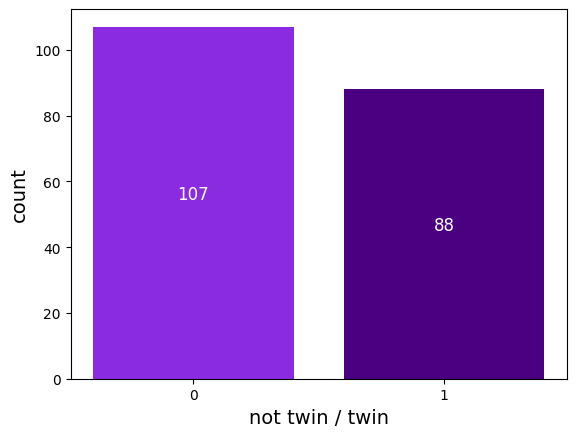

In [103]:
bar_y = df_with_y_again.iloc[only_mlp_got_right]["twin_or_not"].value_counts()
bar_x = [0, 1]
bar_colours = ["blueviolet", "indigo"]

plt.figure()
bars = plt.bar(bar_x, bar_y, color=bar_colours)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
             f'{bar.get_height():d}', ha='center', va='bottom', fontsize=12, c="white")
plt.xticks(bar_x)
plt.xlabel("not twin / twin", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.show()

MLP만 틀린 샘플들 내 '쌍정', '비쌍정' 샘플 개수입니다.

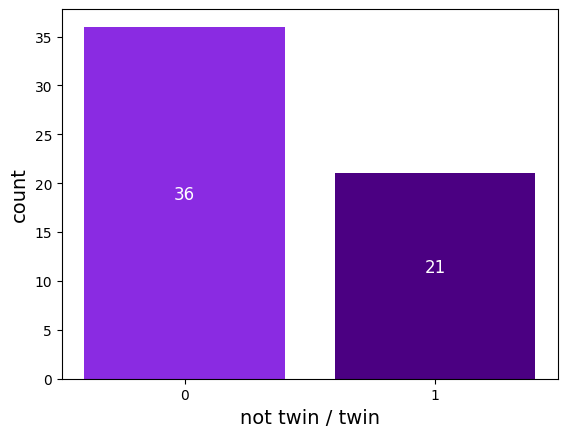

In [104]:
bar_y = df_with_y_again.iloc[only_gcn_got_right]["twin_or_not"].value_counts()
bar_x = [0, 1]
bar_colours = ["blueviolet", "indigo"]

plt.figure()
bars = plt.bar(bar_x, bar_y, color=bar_colours)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
             f'{bar.get_height():d}', ha='center', va='bottom', fontsize=12, c="white")
plt.xticks(bar_x)
plt.xlabel("not twin / twin", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.show()

각각 틀린 샘플들을 실제 이미지 자료에서 확인해서 실제 데이터의 생김새, 특징 등을 파악해볼 예정입니다. 이를 위해 GCN만 틀린 샘플들이 가장 많이 분포한 파일이 어느 파일인지 확인해봅니다.

확인 결과, 엑셀 파일을 읽어들일 때 가장 첫번째로 읽어들인 파일 `V0_125_0083_3pct.xlsx`에서 27개의 오류가 발생했음을 확인할 수 있습니다. 해당 파일과 연관된 시각 자료를 통해 결정립들의 모양새 등을 확인해봅니다.

In [239]:
df_with_y_again.iloc[only_mlp_got_right]["set_num"].value_counts()

set_num
0     27
6     20
7     20
4     17
1     16
2     15
9     12
3     11
5     10
10     9
21     6
8      6
17     5
14     4
15     3
24     3
12     3
19     2
16     2
22     1
23     1
13     1
26     1
Name: count, dtype: int64

MLP만 틀린 샘플들은 어떤 파일에 분포하고 있는지 확인해봅니다.

In [240]:
df_with_y_again.iloc[only_gcn_got_right]["set_num"].value_counts()

set_num
8     9
2     8
3     7
7     7
9     5
10    3
6     3
0     3
4     3
5     3
1     2
12    1
14    1
22    1
19    1
Name: count, dtype: int64

각각 `set_num`이 어떤 파일명과 일치하는지 확인해봅니다.

In [241]:
file_path_list = list(folder.glob("*/*/*/MergedGrainsData*"))

GCN만 틀린 샘플들이 많이 분포한 순서대로 파일명을 나열합니다.

In [242]:
file_path_arr = np.array(["_".join(p.parts[-1].split("_")[1:]) for p in file_path_list])
gcn_wrong_file_names = file_path_arr[df_with_y_again.iloc[only_mlp_got_right]["set_num"].value_counts().index.tolist()]
pd.DataFrame({
    "file_name": gcn_wrong_file_names, 
    "wrong_count": df_with_y_again.iloc[only_mlp_got_right]["set_num"].value_counts().values
    })

file_name  wrong_count
0    V0_125_0083_3pct.xlsx           27
1    V0_275_1666_3pct.xlsx           20
2    V0_275_1666_7pct.xlsx           20
3    V0_225_1666_7pct.xlsx           17
4    V0_175_1666_3pct.xlsx           16
5    V0_175_1666_7pct.xlsx           15
6    V0_325_1666_7pct.xlsx           12
7    V0_225_1666_3pct.xlsx           11
8     V0_25_0083_3pct.xlsx           10
9    V0_425_1666_3pct.xlsx            9
10   V90_25_0083_7pct.xlsx            6
11   V0_325_1666_3pct.xlsx            6
12  V90_225_1666_7pct.xlsx            5
13  V90_175_0083_3pct.xlsx            4
14  V90_175_0083_7pct.xlsx            3
15  V90_325_1666_3pct.xlsx            3
16  V90_125_0083_3pct.xlsx            3
17  V90_225_0083_7pct.xlsx            2
18  V90_225_1666_3pct.xlsx            2
19  V90_275_1666_3pct.xlsx            1
20  V90_275_1666_7pct.xlsx            1
21  V90_125_0083_7pct.xlsx            1
22  V90_425_1666_3pct.xlsx            1

MLP만 틀린 샘플들이 많이 분포한 순서대로 파일명을 나열합니다.

In [243]:
mlp_wrong_file_names = file_path_arr[df_with_y_again.iloc[only_gcn_got_right]["set_num"].value_counts().index.tolist()]
pd.DataFrame({
    "file_name": mlp_wrong_file_names, 
    "wrong_count": df_with_y_again.iloc[only_gcn_got_right]["set_num"].value_counts().values
    })

file_name  wrong_count
0    V0_325_1666_3pct.xlsx            9
1    V0_175_1666_7pct.xlsx            8
2    V0_225_1666_3pct.xlsx            7
3    V0_275_1666_7pct.xlsx            7
4    V0_325_1666_7pct.xlsx            5
5    V0_425_1666_3pct.xlsx            3
6    V0_275_1666_3pct.xlsx            3
7    V0_125_0083_3pct.xlsx            3
8    V0_225_1666_7pct.xlsx            3
9     V0_25_0083_3pct.xlsx            3
10   V0_175_1666_3pct.xlsx            2
11  V90_125_0083_3pct.xlsx            1
12  V90_175_0083_3pct.xlsx            1
13  V90_275_1666_3pct.xlsx            1
14  V90_225_0083_7pct.xlsx            1

GCN만 틀린 샘플들이 가장 많이 분포한 `set_num`이 0인 파일에서 해당 오류 샘플들의 실제 데이터를 확인해봅니다.

In [246]:
df_with_y_again.iloc[only_mlp_got_right][df_with_y_again["set_num"] == 0]

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\4242567659.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_with_y_again.iloc[only_mlp_got_right][df_with_y_again["set_num"] == 0]


merged ID  original grain id       phi1         phi       phi2  \
20          21                 68  25.738989  340.820804  46.377058   
39          40                130  26.945316   10.288850  20.015697   
55          56                190  44.263149  332.250381  15.586187   
60          61                209  55.933664  359.048066   1.726641   
62          63                221   6.835051  341.401550  51.297011   
70          71                243  13.002316  318.953790  36.558308   
75          76                257  51.322023  351.511419   2.936762   
92          93                319  38.453701  356.823542   5.886166   
121        122                403  34.786781  340.969236  36.346856   
122        123                406  25.207710  331.711226  40.267839   
206        207                702  35.842313  326.044311  28.991053   
232        233                807  17.275707  324.966317  41.440027   
234        235                811  14.453775  359.604723  11.637619   
249        250                896  48.139838  349.800661  25.268907   
265        266                972   5.347762  316.504910  36.884966   
276        277               1004   7.223550  331.881272  49.015698   
308        309               1109  27.307794  332.073103  40.474214   
324        325               1137  37.036876  346.729803  16.508557   
361        362               1243  53.414020  345.549961   4.185492   
364        365               1246  23.289285  358.273442  11.012571   
387        388               1348  31.661180  326.287383  29.109441   
413        414               1432  13.260103  306.364096  14.967223   
426        427               1463  14.857137  305.699194  10.394788   
436        437               1502   8.783210  352.300421  55.981564   
452        453               1544  34.514296  344.873071  41.139090   
453        454               1545  16.321335    9.816729  30.011088   
530        531                485  17.785409    4.997191  12.736961   

     merged grain area  parent Area  daughter Area  other area  \
20                 342          342              0           0   
39                  43           43              0           0   
55                  12           12              0           0   
60                  13           13              0           0   
62                 190          190              0           0   
70                  59           59              0           0   
75                  11           11              0           0   
92                  20           20              0           0   
121                 37           37              0           0   
122                 66           66              0           0   
206                 41           41              0           0   
232                 47           47              0           0   
234                 18           18              0           0   
249                202          202              0           0   
265                 23           23              0           0   
276                 13           13              0           0   
308                 11           11              0           0   
324                 76           76              0           0   
361                 42           42              0           0   
364                 39           39              0           0   
387                188          188              0           0   
413                 72           72              0           0   
426                 94           94              0           0   
436                 57           57              0           0   
452                 12           12              0           0   
453                 24           24              0           0   
530                244          191             53           0   

     no. of parent grains  ...  Rank for Var5  Rank for Var6  \
20                      1  ...              5              6   
39                      1  ...         

GCN, MLP 모델 둘 다 틀린 샘플들을 확인해봅니다. 이를 위해 인덱스를 추출합니다.

In [247]:
both_wrong_indices_for_indices = list(set(mlp_f.tolist()).intersection(set(gcn_f.tolist())))
both_wrong = test_indices_arr[both_wrong_indices_for_indices]

In [248]:
both_wrong

array([ 5050, 10443, 10448, 10450, 10460, 10465, 10479, 10500,   409,
       10507, 10505, 10515,  5517,  5519,   630,  5580,  5789, 16064,
       16077,  6082, 16082,  6105,  6112,  6134,  6150,  6165,  6172,
        6180,  6198,  6204,  1258,  1261, 11252,  6424, 11266, 11271,
        1398, 16598, 16606,  6709,  6718,  6728,  6756,  6760,  6776,
        1780,  1846,  1848,  1909,  1927,  1948,  1977, 12047, 12054,
       12071, 12084, 17451, 17471,  2399,  7576,  2428,  2448,  2495,
        2649,  2672, 12887, 12900, 12901, 18112,  2922,  2946, 18114,
       18127,  3006,  8238,  8246,  8268,  8274,  8294,  8298,  3100,
        3189,  3482,  3494, 13693,  3587, 18929, 13726, 13732, 13734,
       18936, 18953, 18969,  8976,  9012,  9026,  9034,  9055,  4125,
        4146,  4151,  4161, 14423, 14426, 14430,  4210,  4271,  4285,
        4369,  4425,  9834,  4770,  4944,  4957,  4962,  4965,  4971,
        5002, 15185, 15196,  5047, 15254])

GCN, MLP 두 모델 다 틀린 샘플들이 어떤 파일에 주로 분포하는지 확인합니다.

In [249]:
both_wrong_file_names = file_path_arr[df_with_y_again.iloc[both_wrong]["set_num"].value_counts().index.tolist()]
pd.DataFrame({
    "file_name": both_wrong_file_names, 
    "wrong_count": df_with_y_again.iloc[both_wrong]["set_num"].value_counts().values
    })

file_name  wrong_count
0    V0_325_1666_7pct.xlsx           11
1   V90_175_0083_7pct.xlsx           10
2    V0_275_1666_7pct.xlsx            9
3    V0_275_1666_3pct.xlsx            7
4    V0_425_1666_3pct.xlsx            7
5    V0_175_1666_7pct.xlsx            6
6   V90_125_0083_3pct.xlsx            6
7    V0_225_1666_7pct.xlsx            5
8    V0_325_1666_3pct.xlsx            5
9    V0_225_1666_3pct.xlsx            5
10    V0_25_0083_3pct.xlsx            5
11  V90_125_0083_7pct.xlsx            5
12  V90_225_0083_7pct.xlsx            4
13  V90_425_1666_3pct.xlsx            4
14  V90_225_1666_7pct.xlsx            4
15  V90_225_1666_3pct.xlsx            3
16   V90_25_0083_3pct.xlsx            3
17   V0_175_1666_3pct.xlsx            3
18  V90_275_1666_3pct.xlsx            3
19   V90_25_0083_7pct.xlsx            3
20  V90_325_1666_7pct.xlsx            3
21  V90_225_0083_3pct.xlsx            3
22   V0_125_0083_3pct.xlsx            2
23  V90_275_1666_7pct.xlsx            2
24  V90_325_1666_3pct.xlsx            2
25   V0_425_1666_7pct.xlsx            1
26  V90_175_0083_3pct.xlsx            1

GCN, MLP 둘 다 틀린 샘플들은 '쌍정', '비쌍정' 관련 어떤 분포를 띄는지 시각화를 통하여 확인해봅니다.

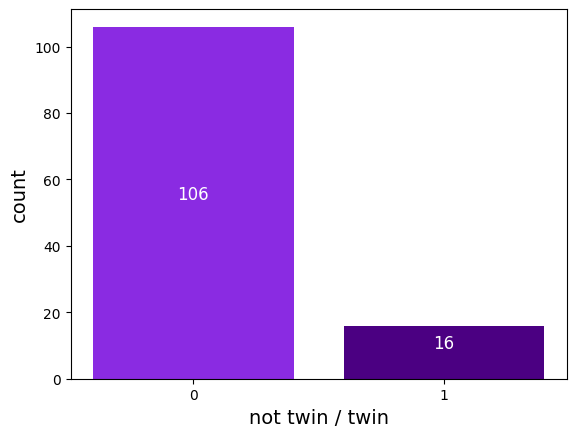

In [250]:
bar_y = df_with_y_again.iloc[both_wrong]["twin_or_not"].value_counts()
bar_x = [0, 1]
bar_colours = ["blueviolet", "indigo"]

plt.figure()
bars = plt.bar(bar_x, bar_y, color=bar_colours)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
             f'{bar.get_height():d}', ha='center', va='bottom', fontsize=12, c="white")
plt.xticks(bar_x)
plt.xlabel("not twin / twin", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.show()

두 모델 다 틀린 샘플이 가장 많이 분포한 `set_num`이 `9`인 파일 내 실제 틀린 샘플들 데이터를 확인합니다.

In [251]:
df_with_y_again.iloc[both_wrong][df_with_y_again["set_num"] == 9]

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\2505358332.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_with_y_again.iloc[both_wrong][df_with_y_again["set_num"] == 9]


merged ID  original grain id       phi1         phi       phi2  \
5789        145                421  21.493375  336.179140  44.441888   
6082        438                222  27.312808  316.913179  23.870763   
6105        461                325  14.835622  327.762344  44.213081   
6112        468                361  48.132226  340.714945  19.537067   
6134        490                496   5.222317  313.488180  33.047275   
6150        506                594  46.379806  342.033012  22.399574   
6165        521                695  18.551084    2.458167  14.797086   
6172        528                758  31.727560  336.919045  41.684184   
6180        536                799   8.355522  315.874130  34.868970   
6198        554                874  36.338893    0.759024   4.831754   
6204        560                921  46.767278  346.282248  30.034808   

      merged grain area  parent Area  daughter Area  other area  \
5789               2095         2095              0           0   
6082                377          352             25           0   
6105                546          266            280           0   
6112                 89           79             10           0   
6134                142           64             78           0   
6150                 62           31             31           0   
6165                177           58             90           0   
6172                132          115             17           0   
6180                 52           39             13           0   
6198                225          140             85           0   
6204                 46           25             21           0   

      no. of parent grains  ...  Rank for Var5  Rank for Var6  \
5789                     1  ...              5              6   
6082                     1  ...              1              2   
6105                     2  ...              3              1   
6112                     1  ...              4              3   
6134                     1  ...              4              3   
6150                     1  ...              5              3   
6165                     1  ...              5              6   
6172                     2  ...              4              6   
6180                     1  ...              2              1   
6198                     1  ...              3              4   
6204                     1  ...              6              4   

      neighbor grains count                        neighbor grain ids  \
5789                     10    92,120,153,157,186,446,459,464,471,474   
6082                      8               69,75,85,86,441,442,447,452   
6105                     11  87,89,95,101,102,116,125,130,454,475,477   
6112                      6                   115,122,128,470,472,481   
6134                      6                   156,158,167,172,198,499   
6150                      5                       195,204,223,502,511   
6165                      6                   227,253,254,266,514,520   
6172                      6                   249,264,277,536,541,561   
6180                      5                       264,277,290,528,541   
6198                      6                   293,300,303,543,551,587   
6204                      6                   311,320,332,555,563,579   

      percent  temperature  speed  direction  set_num  twin_or_not  
5789        7          325      1          0        9            0  
6082        7          325      1          0        9            1  
6105        7          325      1          0        9            1  
6112        7          325      1          0        9            1  
6134        7          325      1          0        9            1  
6150        7          325      1          0        9            1  
6165        7          325      1          0        9            1  
6172        7          325      1          0        9            1  
6180        7          325      1          0        9    

효율적인 데이터 분석을 위해 GCN 모델, MLP 모델 각각 예측 결과의 정답 여부를 담은 컬럼들을 기존 데이터프레임에 추가합니다.

In [253]:
gcn_result = pd.Series(["NA"] * df.shape[0], name="gcn_result")
mlp_result = pd.Series(["NA"] * df.shape[0], name="mlp_result")

df_whole_data = pd.concat([df_with_y_again, gcn_result, mlp_result], axis=1)

# 테스트 데이터만 부분만 추려내어 우선 'right'으로 값을 할당합니다.
df_whole_data.loc[data.test_mask.numpy(), "gcn_result"] = "right"
df_whole_data.loc[data.test_mask.numpy(), "mlp_result"] = "right"

# 'right'으로 할당된 테스트 데이터 부분에서 GCN, MLP 각각 틀린 부분에 대해서는 'wrong'으로 덮어쓰어 할당합니다.
df_whole_data.loc[test_indices_arr[list(set(gcn_f.tolist()))], "gcn_result"] = "wrong"
df_whole_data.loc[test_indices_arr[list(set(mlp_f.tolist()))], "mlp_result"] = "wrong"

테스트 데이터 중 `mlp_result` 컬럼에서 틀린 샘플일 경우 `wrong`으로 값이 할당되지 않은 부분이 있는지 확인합니다.

In [254]:
df_whole_data.loc[test_indices_arr[list(set(mlp_f.tolist()))], "mlp_result"].map(lambda x: x != "wrong").sum()

np.int64(0)

테스트 데이터 중 `gcn_result` 컬럼에서 틀린 샘플일 경우 `wrong`으로 값이 할당되지 않은 부분이 있는지 확인합니다.

In [255]:
df_whole_data.loc[test_indices_arr[list(set(gcn_f.tolist()))], "gcn_result"].map(lambda x: x != "wrong").sum()

np.int64(0)

시각화를 통하여 각각 모델이 틀린 샘플들이 어떤 분포 형태를 띄는지 확인해봅니다.
- 이를 위해 `seaborn` 라이브러리를 활용해봅니다.

우선 쌍정 여부와 가장 밀접하게 연관되어 있는 특징 중 하나로 파악되는 `major axis` 특징을 기준으로 분포를 살펴봅니다.

GCN 모델이 맞춘 샘플과 틀린 샘플들의 `major axis` 분포입니다.

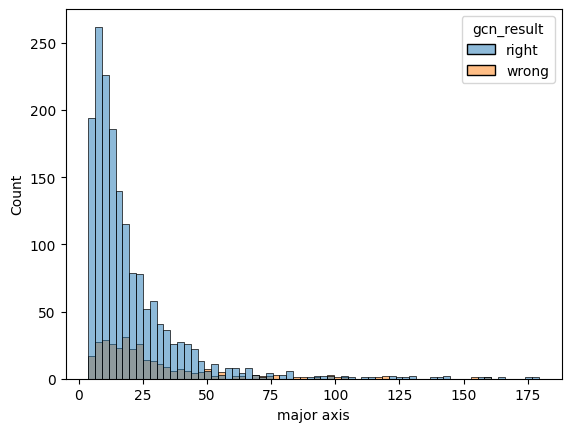

In [258]:
plt.figure()
hue = "gcn_result"
sns_data = df_whole_data[df_whole_data[hue] != "NA"][["major axis", hue]]
sns.histplot(data=sns_data, x="major axis", hue=hue, stat="count")
plt.show()

MLP 모델이 맞춤 샘플과 틀린 샘플들의 `major axis` 분포입니다.

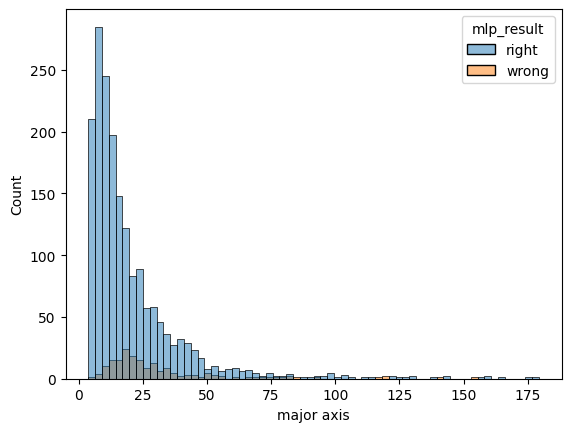

In [259]:
plt.figure()
hue = "mlp_result"
sns_data = df_whole_data[df_whole_data[hue] != "NA"][["major axis", hue]]
sns.histplot(data=sns_data, x="major axis", hue=hue, stat="count")
plt.show()

위와 같은 방법으로는 `right` 샘플이 절대적인 숫자에서 `wrong`보다 더 많기 때문에 시각적으로 유의미한 차이를 판단하기가 어렵습니다. 절대적인 숫자가 아닌 각각 정규화된 수치로서 같은 범위를 갖도록 조정 후 시각화해봅니다.

이를 위해 테스트 데이터에서 각각의 모델이 맞거나 틀린 샘플들만 따로 떼어내어 데이터프레임으로 만듭니다.

In [261]:
df_test_only = df_whole_data.loc[data.test_mask.numpy()]
df_train_only = df_whole_data[data.train_mask.numpy()]

GCN만 틀린 샘플 195개에 대한 데이터프레임을 만듭니다.

In [265]:
cond_gcn_right = df_test_only["gcn_result"] == "right"
cond_mlp_right = df_test_only["mlp_result"] == "right"

both_right_count = int((cond_gcn_right.astype(int) + cond_mlp_right.astype(int)).value_counts()[2])

df_both_right = df_test_only[cond_gcn_right & cond_mlp_right]
assert df_both_right.shape[0] == both_right_count

df_only_gcn_wrong = df_test_only[~cond_gcn_right & cond_mlp_right]
assert df_only_gcn_wrong.shape[0] == 195

GCN만 틀린 샘플들의 특징별 통계적인 수치를 확인합니다.

In [266]:
df_only_gcn_wrong[FEATURE_COLS].describe()

phi1         phi        phi2  merged grain area  major axis  \
count  195.000000  195.000000  195.000000         195.000000  195.000000   
mean    28.231760  281.416611   27.488017         495.748718   25.535685   
std     15.175400  125.916025   15.498381        1002.348502   22.883567   
min      2.172034    0.206117    1.683632          10.000000    3.983038   
25%     15.024550  314.713416   13.525300          45.500000    9.779586   
50%     28.399905  333.950456   26.534495         175.000000   19.642061   
75%     40.517317  348.412098   40.438972         450.500000   31.278784   
max     56.893544  359.760969   56.694707        7407.000000  159.211116   

       aspect ratio  total boundary length         GOS         GAM  \
count    195.000000             195.000000  195.000000  195.000000   
mean       1.843204             117.046154    1.338756    0.782860   
std        0.732656             130.061218    1.274815    0.308184   
min        1.032286              18.000000    0.104807    0.222790   
25%        1.366065              39.000000    0.459629    0.557831   
50%        1.653906              78.000000    0.891880    0.723906   
75%        2.036272             132.500000    1.858390    0.948466   
max        5.745296             875.000000    8.890322    2.390908   

       Schmid SF1  ...  Schmid for Var1  Schmid for Var2  Schmid for Var3  \
count  195.000000  ...       195.000000       195.000000       195.000000   
mean     0.275093  ...        -0.003493        -0.003800        -0.036259   
std      0.151741  ...         0.269634         0.266578         0.297053   
min      0.001684  ...        -0.495013        -0.497541        -0.498144   
25%      0.153583  ...        -0.223109        -0.209149        -0.312575   
50%      0.286647  ...        -0.005091        -0.010845        -0.014550   
75%      0.421164  ...         0.190003         0.203352         0.205574   
max      0.497235  ...         0.494561         0.499905         0.499020   

       Schmid for Var4  Schmid for Var5  Schmid for Var6     percent  \
count       195.000000       195.000000       195.000000  195.000000   
mean         -0.036953        -0.038510        -0.037509    4.682051   
std           0.296723         0.259699         0.263706    1.979648   
min          -0.499807        -0.476339        -0.491739    3.000000   
25%          -0.309410        -0.241141        -0.225651    3.000000   
50%          -0.019439        -0.053899        -0.053789    3.000000   
75%           0.197277         0.104419         0.116558    7.000000   
max           0.496885         0.499385         0.496176    7.000000   

       temperature       speed   direction  
count   195.000000  195.000000  195.000000  
mean    214.743590    0.712821   14.769231  
std      94.691229    0.453611   33.418975  
min      25.000000    0.000000    0.000000  
25%     175.000000    0.000000    0.000000  
50%     225.000000    1.000000    0.000000  
75%     275.000000    1.000000    0.000000  
max     425.000000    1.000000   90.000000  

[8 rows x 31 columns]

두 모델 다 맞춘 샘플들의 특징별 통계적인 수치를 확인합니다.

In [267]:
df_both_right[FEATURE_COLS].describe()

phi1          phi         phi2  merged grain area   major axis  \
count  1616.000000  1616.000000  1616.000000        1616.000000  1616.000000   
mean     28.202094   285.833963    28.426472         288.668936    19.599151   
std      26.767562   123.064624    24.059452         805.200441    19.189467   
min       0.048926     0.026795     0.129533          10.000000     3.754717   
25%      11.288036   312.918896    11.699695          29.000000     8.467764   
50%      23.708694   339.048632    25.236292          76.000000    13.377787   
75%      44.346379   351.816292    44.547960         238.000000    23.683515   
max     359.914579   359.995988   359.432667       10391.000000   179.459525   

       aspect ratio  total boundary length          GOS          GAM  \
count   1616.000000            1616.000000  1616.000000  1616.000000   
mean       2.091425              79.063119     1.202430     0.883268   
std        1.212778              97.216861     1.099715     0.539958   
min        1.024631              15.000000     0.070525     0.163840   
25%        1.428990              31.000000     0.461343     0.509489   
50%        1.750271              51.000000     0.831971     0.751415   
75%        2.280615              90.000000     1.502253     1.074965   
max       20.813044            1367.000000     7.520485     4.340393   

        Schmid SF1  ...  Schmid for Var1  Schmid for Var2  Schmid for Var3  \
count  1616.000000  ...      1616.000000      1616.000000      1616.000000   
mean      0.342024  ...         0.221657         0.221017         0.209349   
std       0.126166  ...         0.238164         0.238827         0.256210   
min       0.001220  ...        -0.491262        -0.492837        -0.499918   
25%       0.250512  ...         0.091655         0.082510         0.072319   
50%       0.377617  ...         0.288985         0.292715         0.287448   
75%       0.447387  ...         0.411112         0.409658         0.413123   
max       0.499848  ...         0.499740         0.499234         0.499750   

       Schmid for Var4  Schmid for Var5  Schmid for Var6     percent  \
count      1616.000000      1616.000000      1616.000000  1616.00000   
mean          0.208758         0.157024         0.158254     4.84901   
std           0.255209         0.248760         0.248316     1.99491   
min          -0.498974        -0.497236        -0.490940     3.00000   
25%           0.073346        -0.022052        -0.021922     3.00000   
50%           0.285297         0.206454         0.205446     3.00000   
75%           0.409049         0.370989         0.375099     7.00000   
max           0.499426         0.499785         0.499955     7.00000   

       temperature        speed    direction  
count  1616.000000  1616.000000  1616.000000  
mean    239.449257     0.610149    64.158416  
std     116.356210     0.487867    40.730599  
min      25.000000     0.000000     0.000000  
25%     175.000000     0.000000     0.000000  
50%     225.000000     1.000000    90.000000  
75%     325.000000     1.000000    90.000000  
max     425.000000     1.000000    90.000000  

[8 rows x 31 columns]

두 모델 다 맞은 샘플들과 GCN 모델만 틀린 샘플들의 특징별 분포를 시각화하여 확인해봅니다. 이를 위해 두 분류의 데이터만 모아놓은 새로운 데이터프레임을 만듭니다.

In [272]:
df_2 = pd.concat([df_both_right, df_only_gcn_wrong])
df_2

merged ID  original grain id       phi1         phi       phi2  \
5              6                 15   5.647723    0.121668  17.860995   
32            33                111   8.477407  322.794289  42.719571   
98            99                331   7.389812  306.667009  19.496556   
177          178                615  35.515692  325.047335  27.762558   
184          185                644   8.895618  345.197913  47.864597   
...          ...                ...        ...         ...        ...   
16590        505                192  38.527122  327.305060  26.534495   
17439        822                298  25.913967  329.656889  39.118657   
17452        835                550  31.407294  314.286901  12.951540   
17453        836                552  45.706970  335.059713  21.128272   
18958        789                645  30.356023    4.758644  34.833031   

       merged grain area  parent Area  daughter Area  other area  \
5                     54           54              0           0   
32                    27           27              0           0   
98                    15           15              0           0   
177                   30           30              0           0   
184                   19           19              0           0   
...                  ...          ...            ...         ...   
16590                488          476             12           0   
17439               1979         1739            240           0   
17452               1229         1122             77          30   
17453               1069         1012             57           0   
18958                300          188            112           0   

       no. of parent grains  ...  neighbor grains count  \
5                         1  ...                      4   
32                        1  ...                      4   
98                        1  ...                      2   
177                       1  ...                      2   
184                       1  ...                      3   
...                     ...  ...                    ...   
16590                     1  ...                      7   
17439                     1  ...                     10   
17452                     2  ...                     20   
17453                     1  ...                      8   
18958                     2  ...                      7   

                                      neighbor grain ids  percent  \
5                                           11,15,34,466        3   
32                                        28,466,478,539        3   
98                                                89,111        3   
177                                              183,202        3   
184                                          194,552,562        3   
...                                                  ...      ...   
16590                        133,153,154,168,177,502,509        7   
17439            168,173,184,192,257,275,283,814,816,830        3   
17452  294,298,320,323,338,339,347,353,355,359,361,36...        3   
17453                    365,374,402,413,432,446,830,845        3   
18958                        531,546,553,560,673,788,792        3   

       temperature  speed  direction  set_num  twin_or_not  gcn_result  \
5              125      0          0        0            0       right   
32             125      0          0        0            0       right   
98             125      0          0        0            0       right   
177            125      0          0        0            0       right   
184            125      0          0        0            0       right   
...            ...    ...        ...      ...          ...         ...   
16590          275      1         90       23            1       wrong   
17439          325      1         90       24            1       wrong   
17452          325      1         90       24            1       wrong   
17453          325      1         9

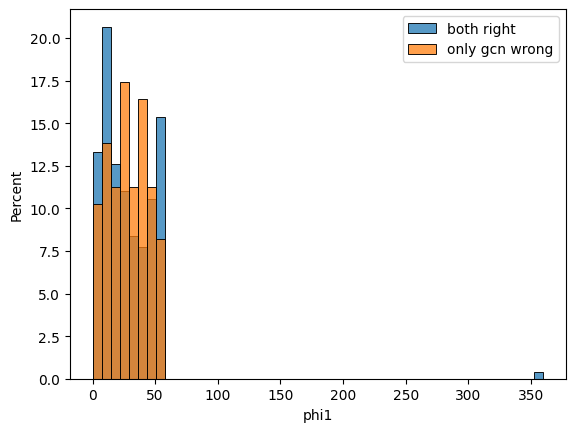

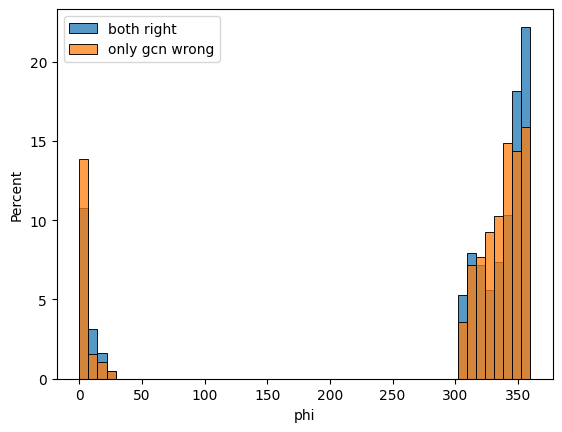

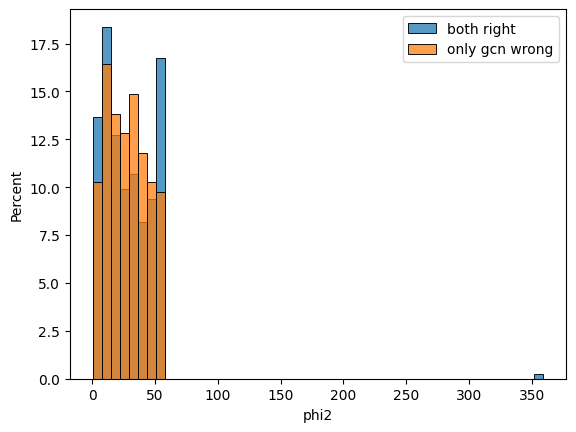

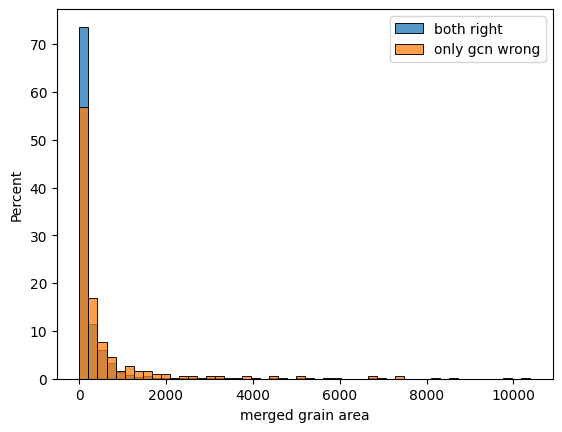

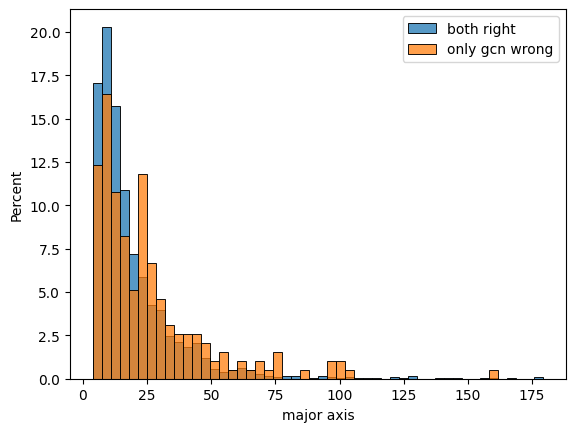

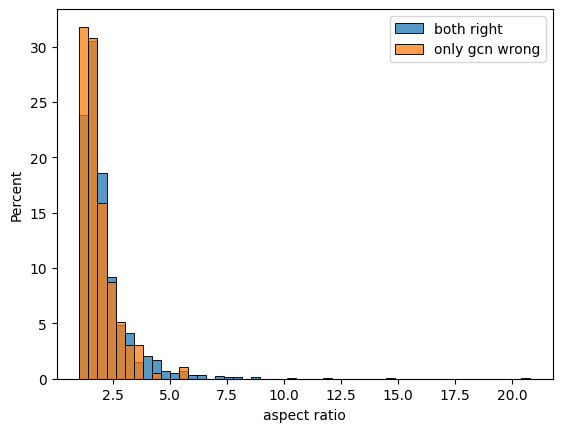

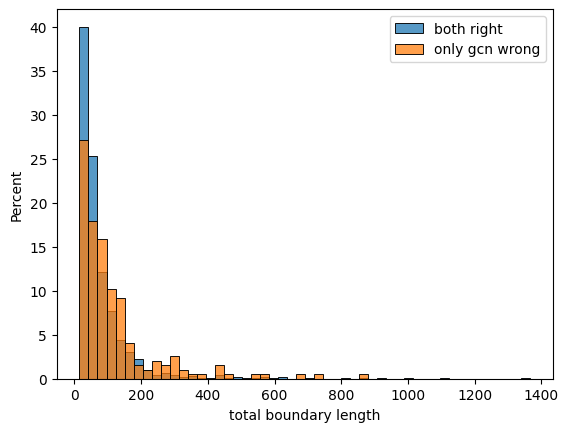

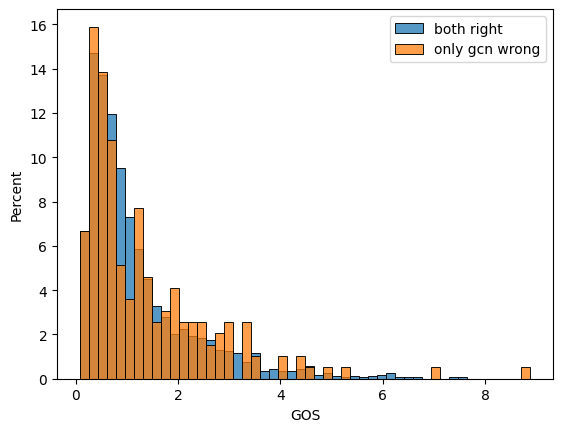

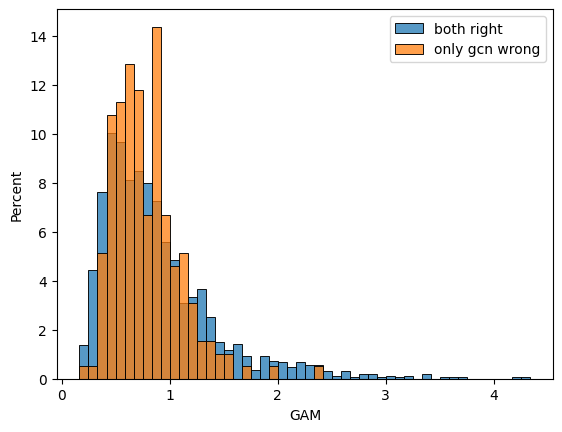

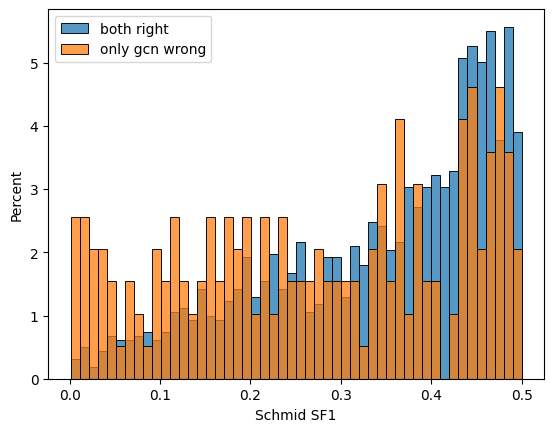

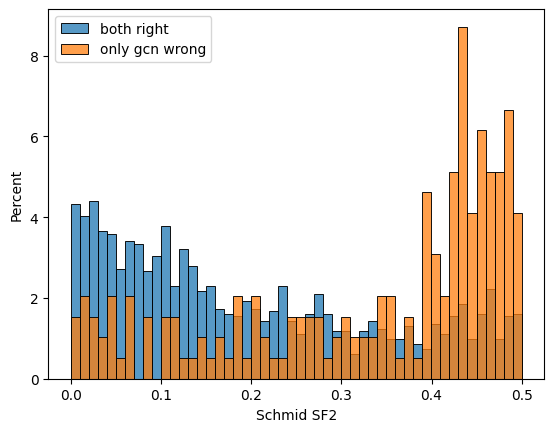

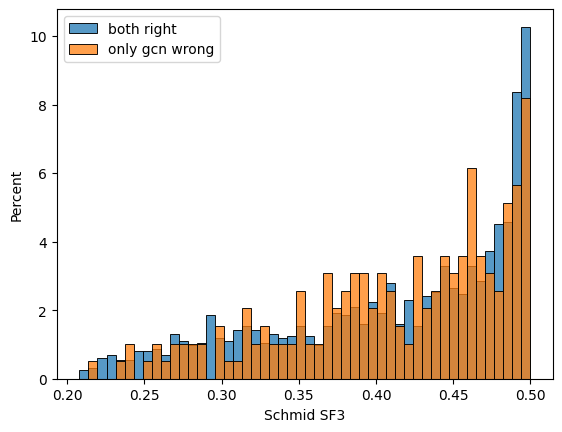

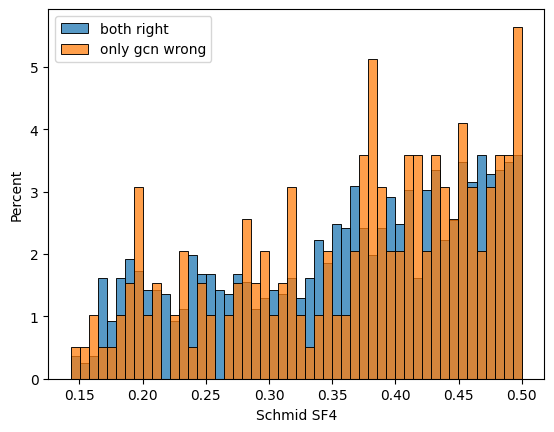

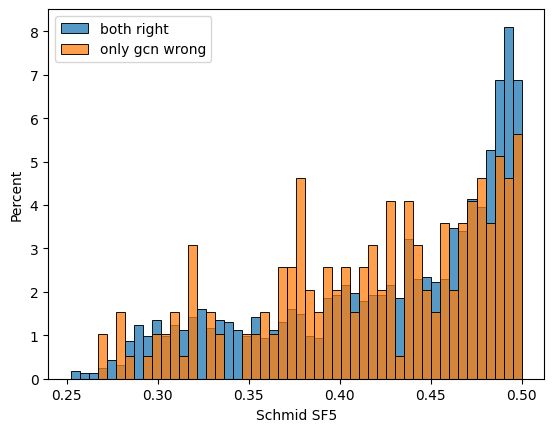

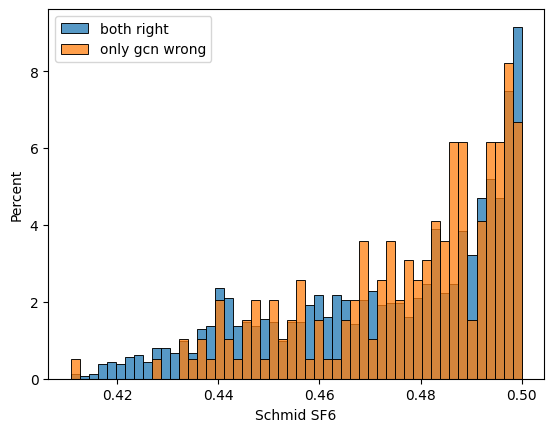

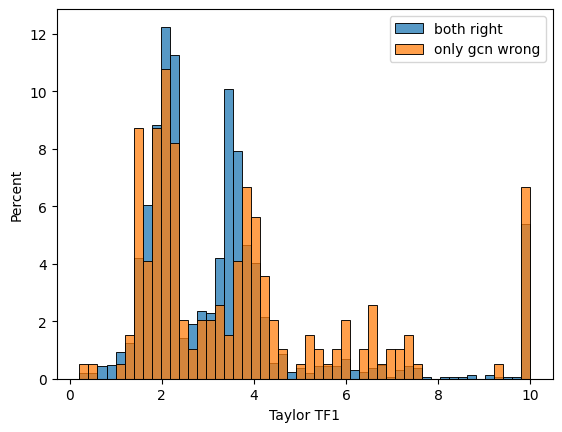

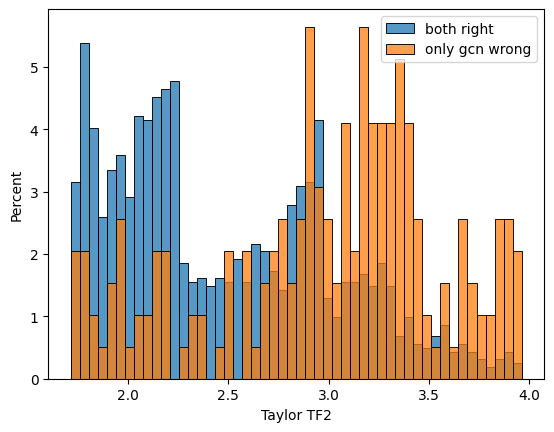

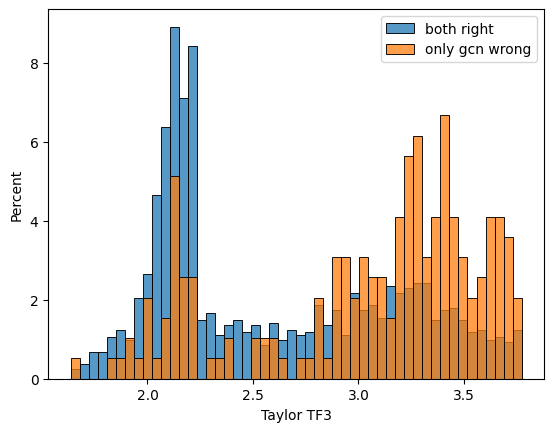

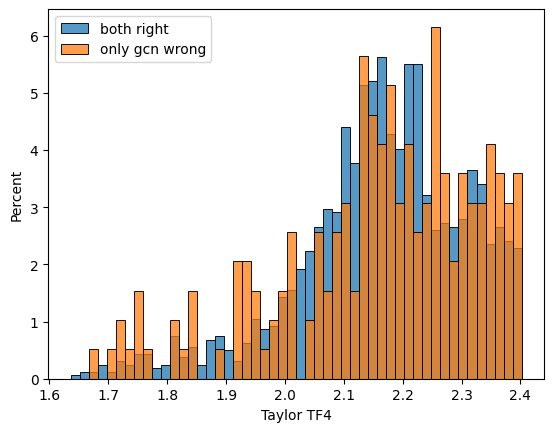

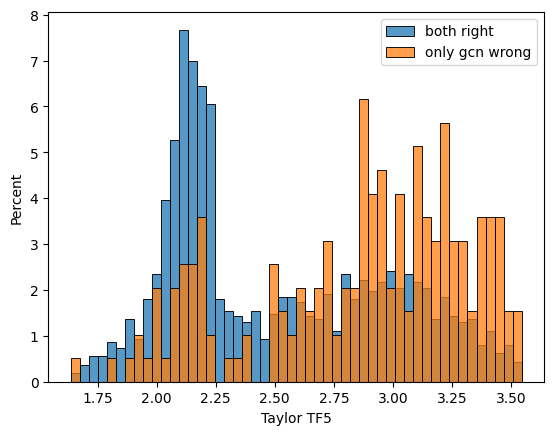

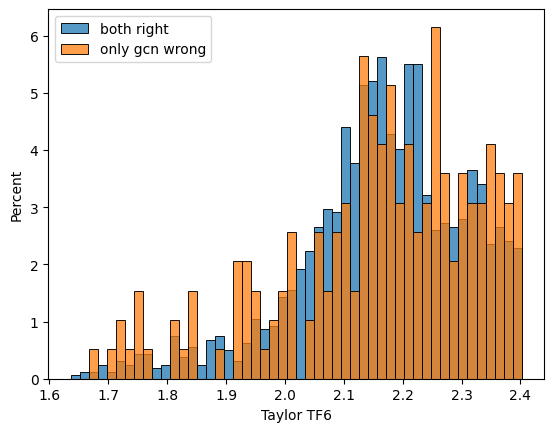

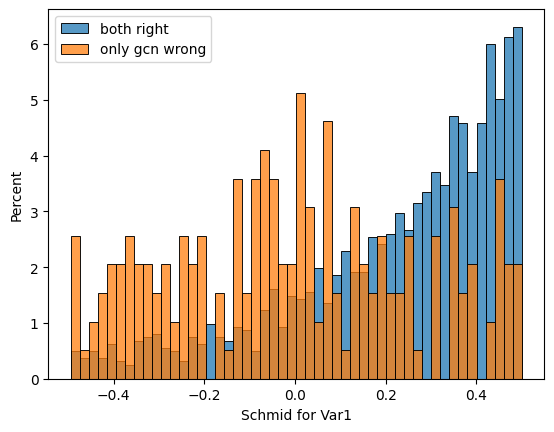

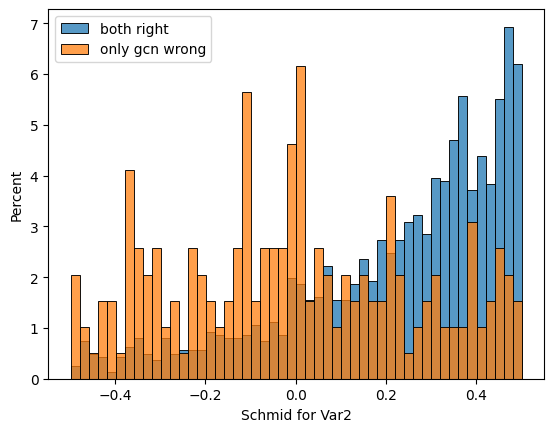

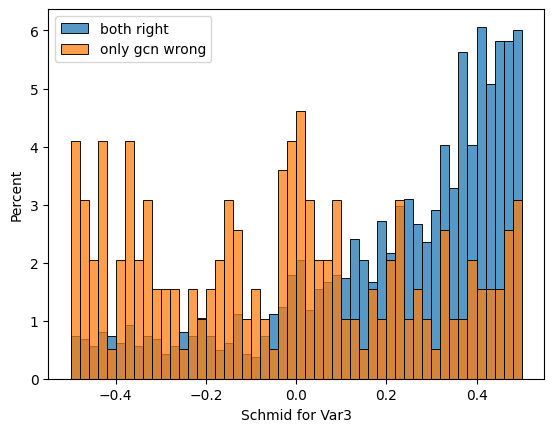

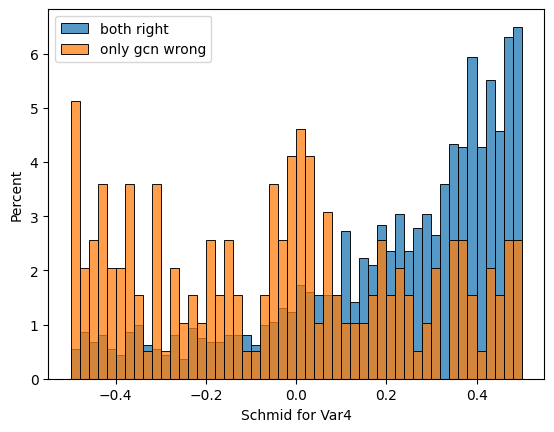

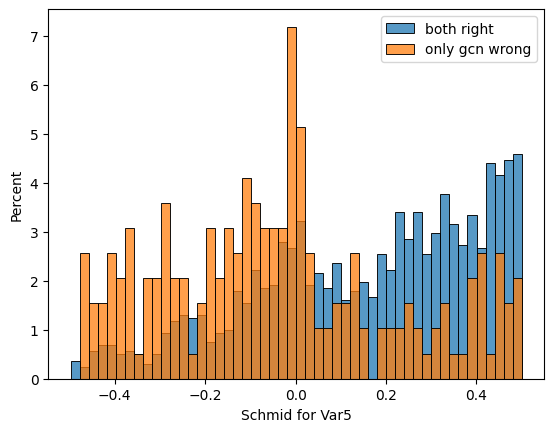

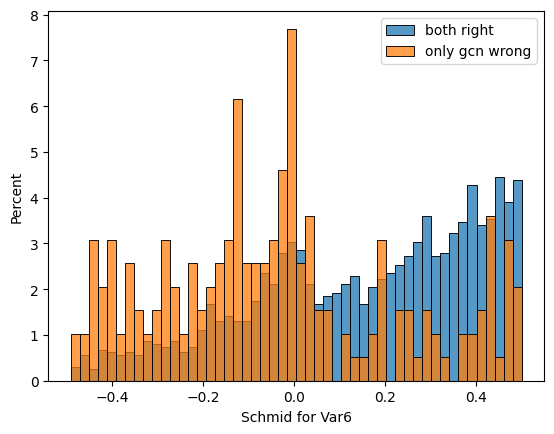

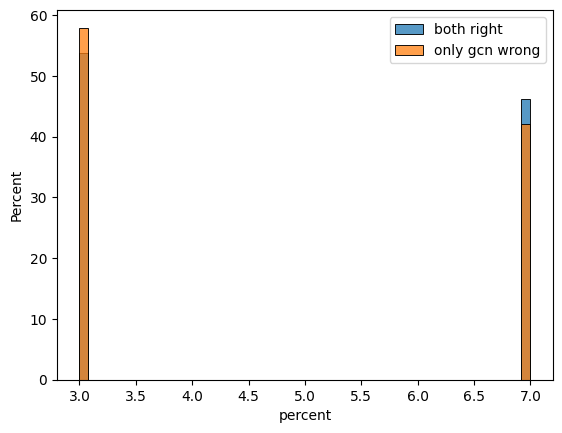

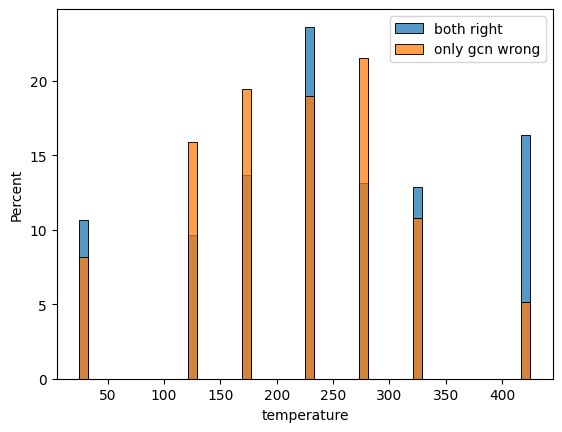

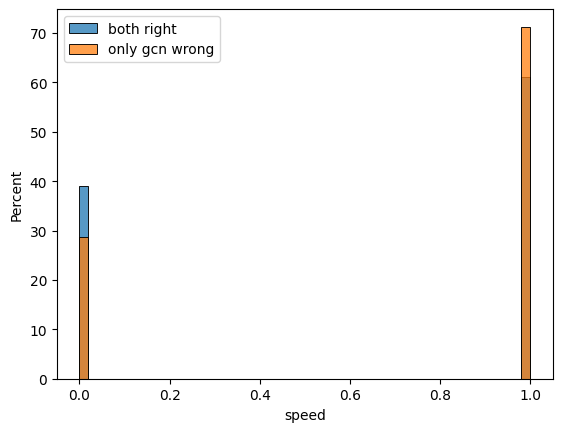

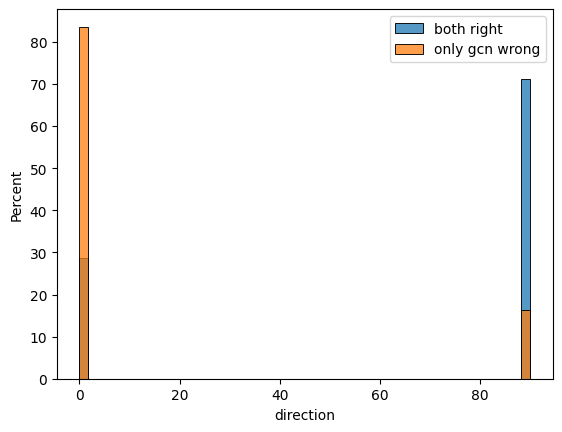

In [273]:
for col in FEATURE_COLS:
    plt.figure()
    bin_range = [df_2[col].min(), df_2[col].max()]
    sns.histplot(data=df_both_right, x=col, binrange=bin_range, bins=50, stat="percent")
    sns.histplot(data=df_only_gcn_wrong, x=col, binrange=bin_range, bins=50, stat="percent")
    plt.legend(["both right", "only gcn wrong"])
    
    # 저장을 원할 경우 아래의 주석을 해제합니다.
    # plt.savefig(f"analysis_1_{col}.png")
    plt.show()

혹시 인접 grain 숫자가 '쌍정', '미쌍정' 여부에 영향을 주는지 분포를 시각화하여 차이를 확인해봅니다.

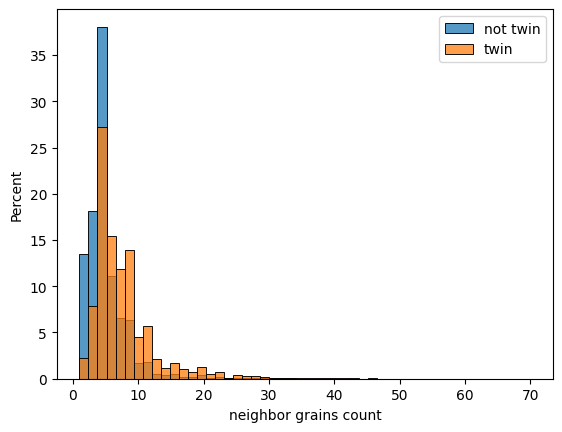

In [276]:
col = "neighbor grains count"
plt.figure()
bin_range = [df_with_y_again[col].min(), df_with_y_again[col].max()]
sns.histplot(data=df_with_y_again[df_with_y_again["twin_or_not"] == 0], x=col, binrange=bin_range, bins=50, stat="percent")
sns.histplot(data=df_with_y_again[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")
plt.legend(["not twin", "twin"])
plt.show()

전체 특징별로 '쌍정', '미쌍정' 데이터 간 분포 차이를 시각화하여 확인해봅니다.

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


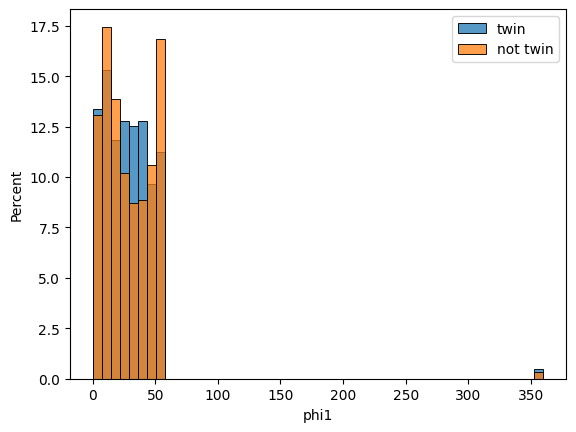

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


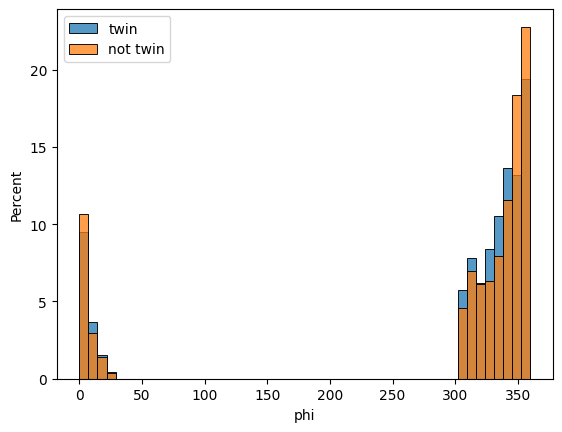

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


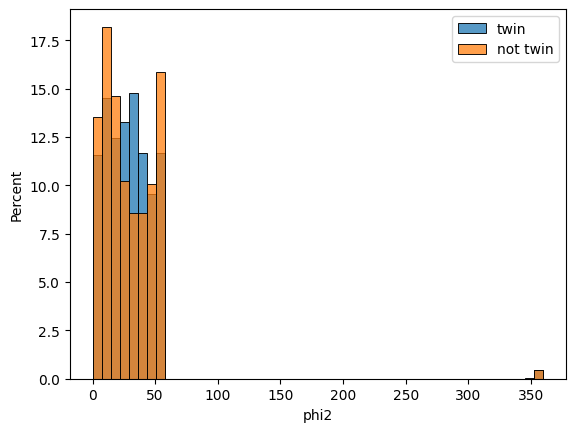

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


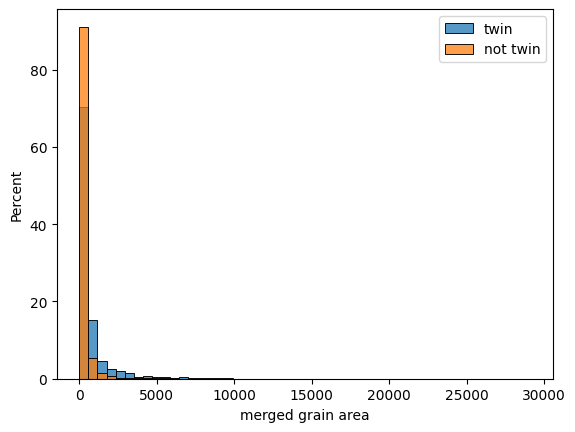

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


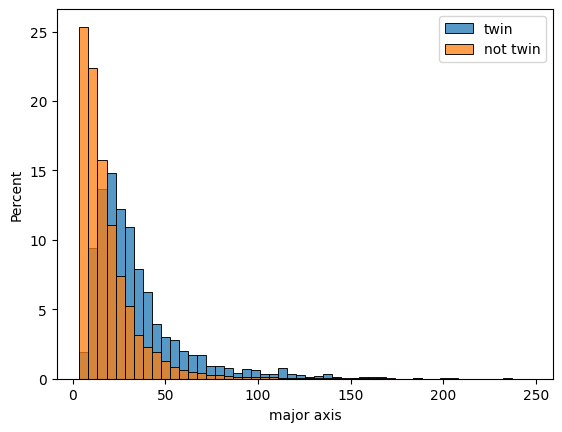

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


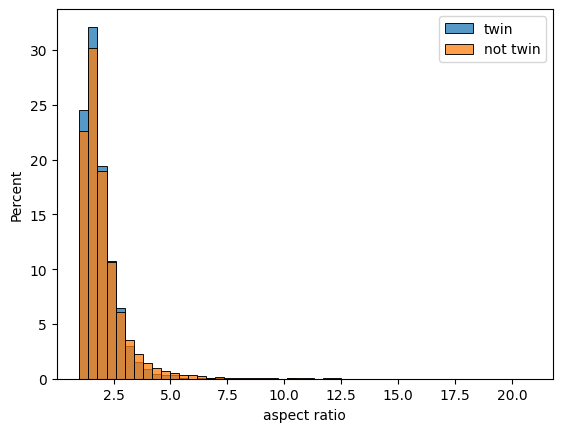

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


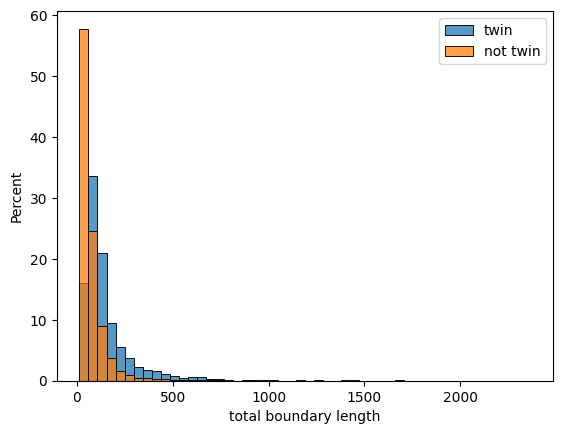

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


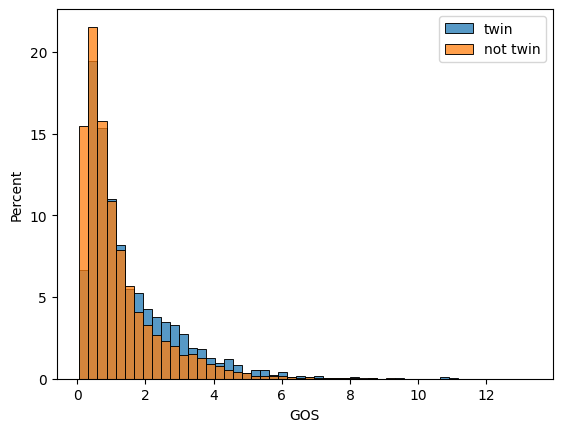

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


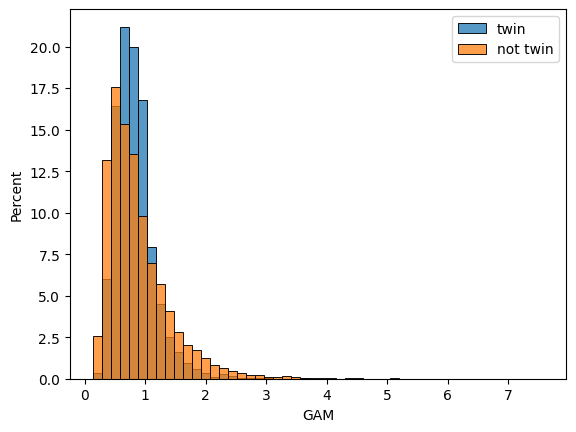

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


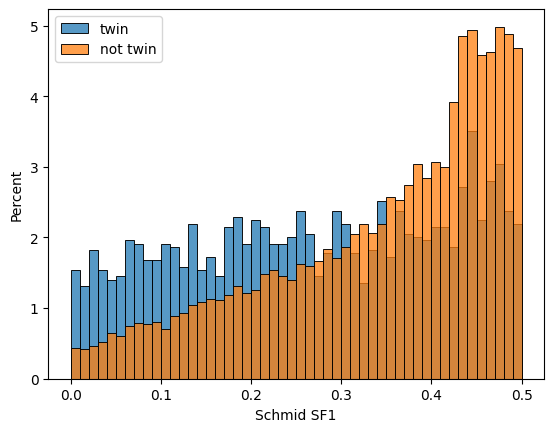

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


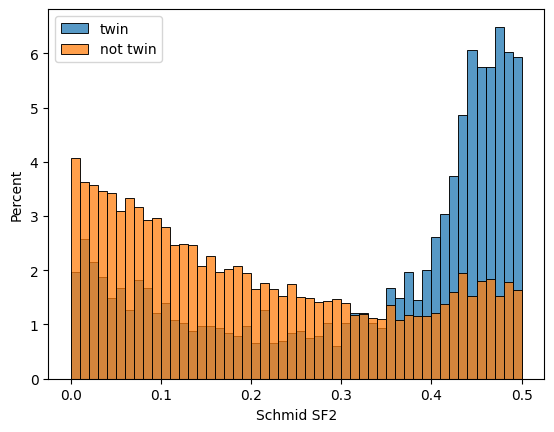

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


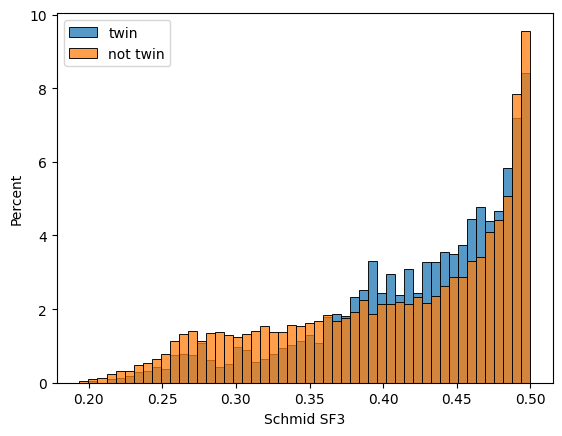

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


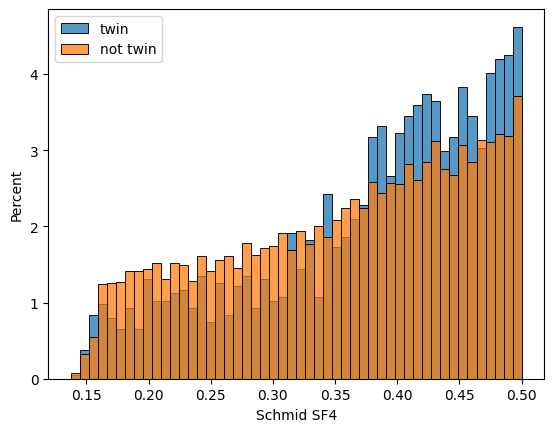

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


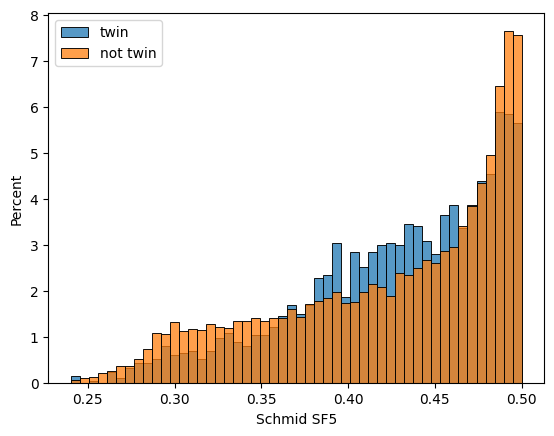

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


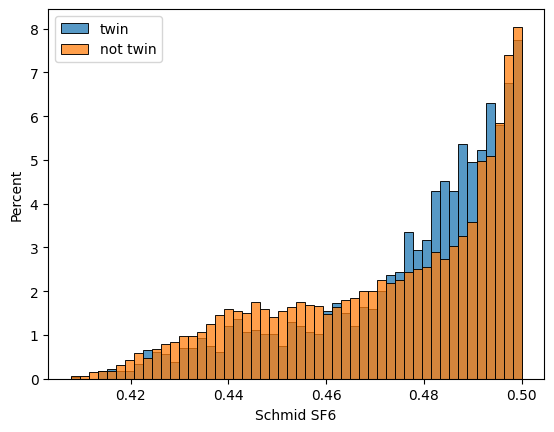

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


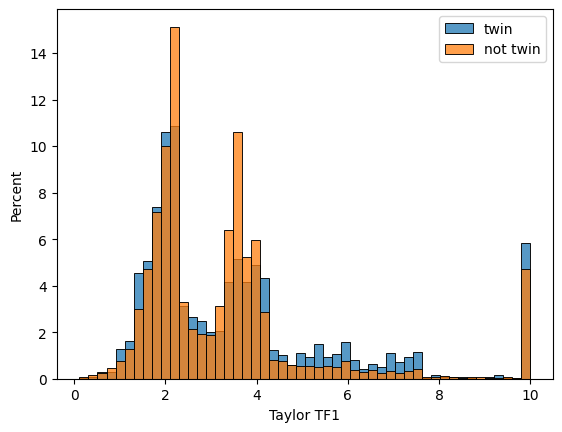

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


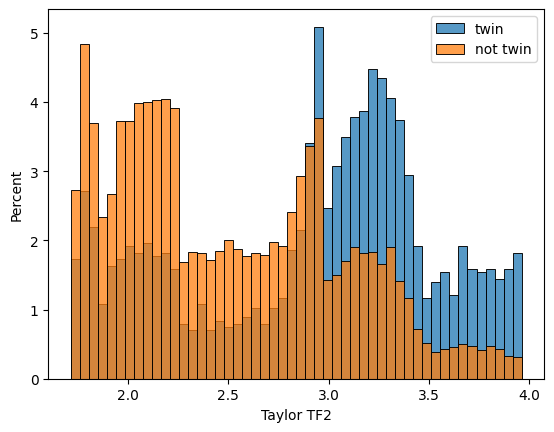

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


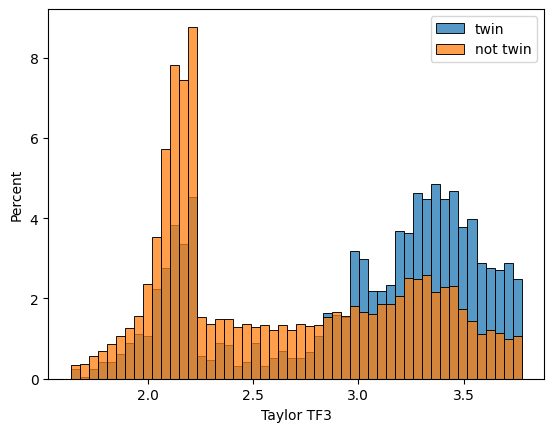

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


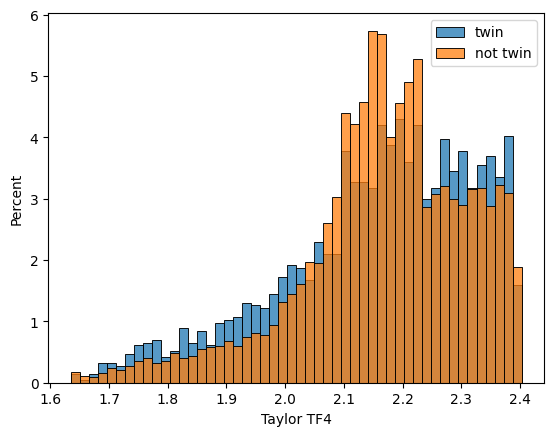

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


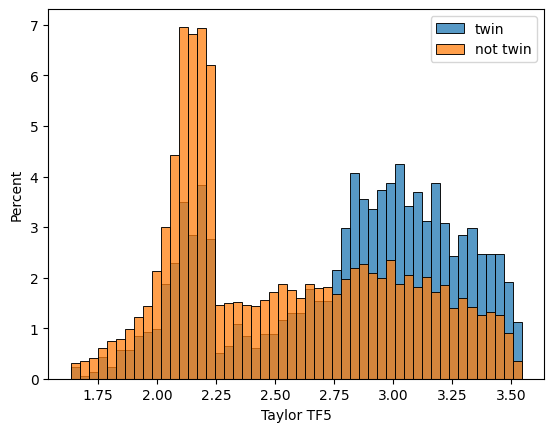

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


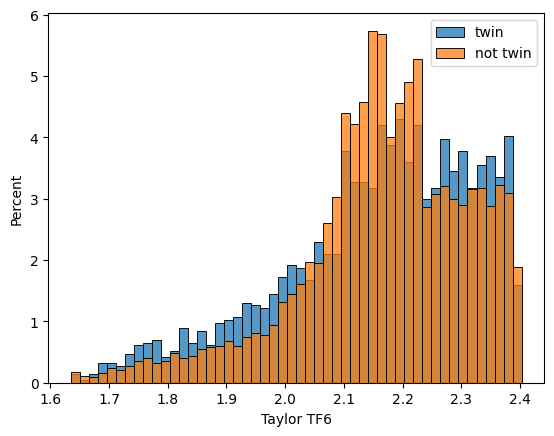

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


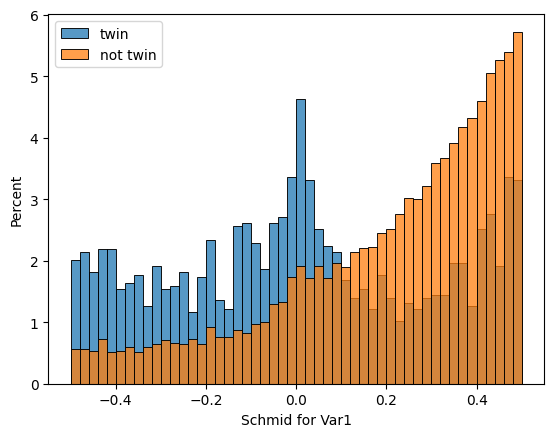

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


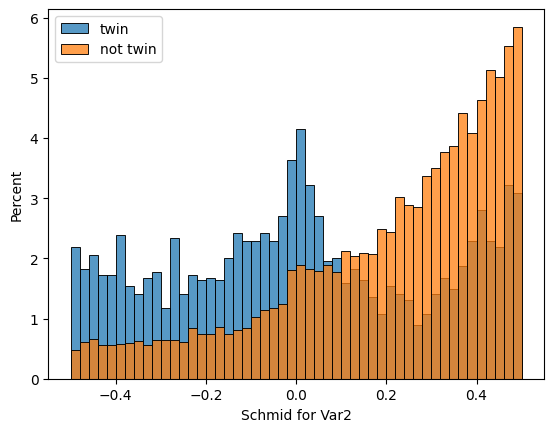

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


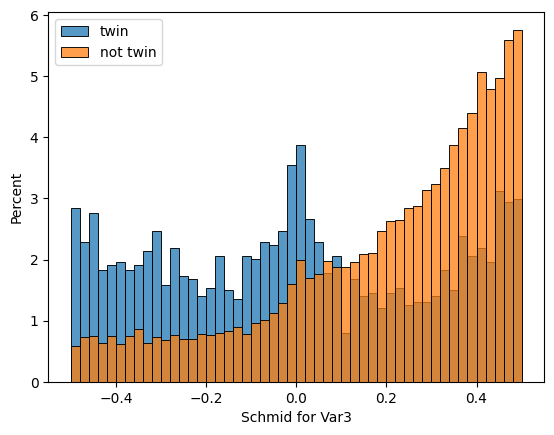

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


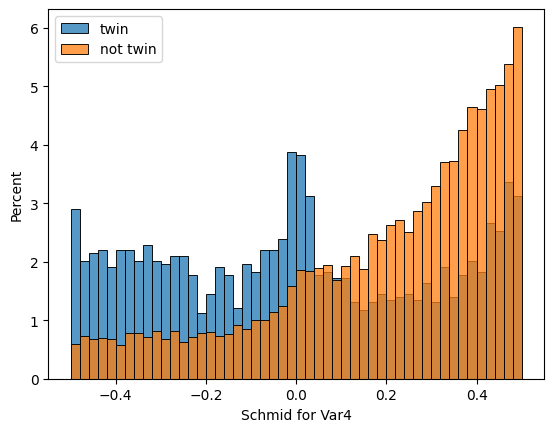

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


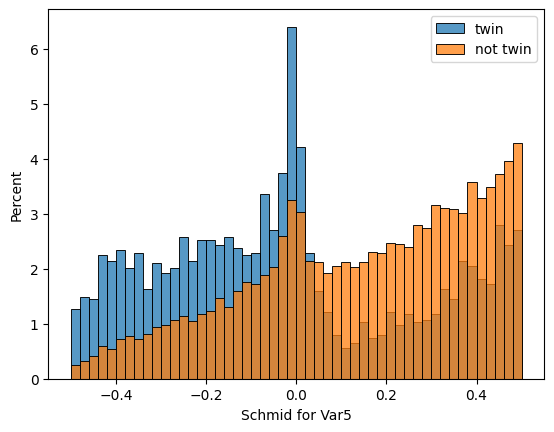

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


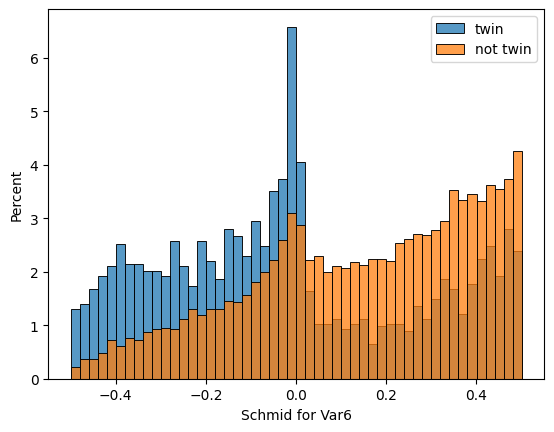

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


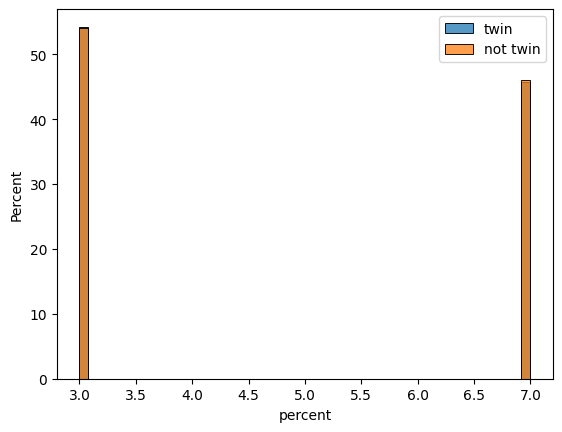

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


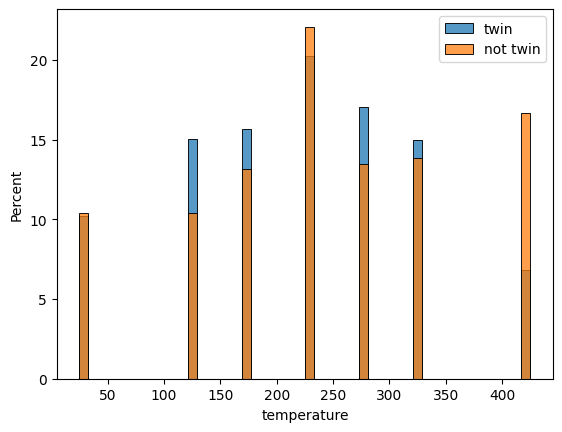

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


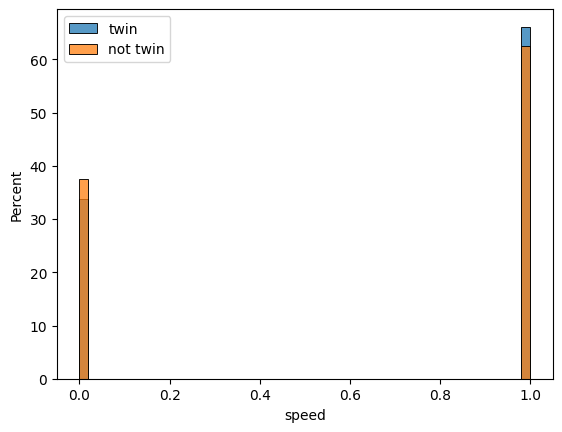

C:\Users\msi\AppData\Local\Temp\ipykernel_16624\1777882576.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")


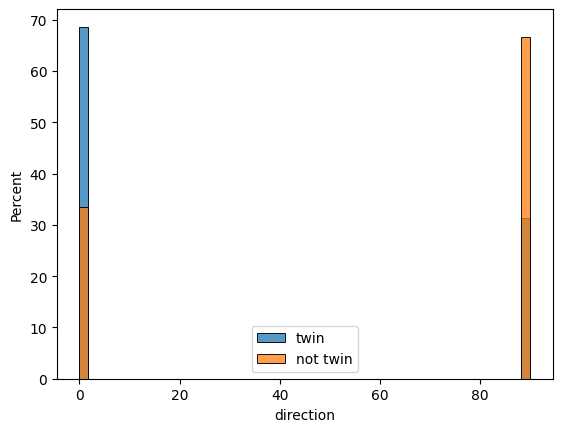

In [277]:
for col in FEATURE_COLS:
    plt.figure()
    bin_range = [df[col].min(), df[col].max()]
    sns.histplot(data=df_train_only[df_with_y_again["twin_or_not"] == 1], x=col, binrange=bin_range, bins=50, stat="percent")
    sns.histplot(data=df[df_with_y_again["twin_or_not"] != 1], x=col, binrange=bin_range, bins=50, stat="percent")
    plt.legend(["twin", "not twin"])
    
    # 이미지를 각각 저장하고 싶으면 아래의 주석을 해제합니다.
    # plt.savefig(f"analysis_2_twin_not_{col}_train_only.png")
    plt.show()

위의 시각화를 통해 몇몇 특징들은 '쌍정'과 '미쌍정'간 분포 차이가 있음을 확인해봤습니다. 해당 특징들에 실제로 '쌍정'과 '미쌍정'이 얼마나 분포해있는지 특징 내 '쌍정', '미쌍정'으로 데이터를 나눠서 시각화 진행 및 확인해봅니다.

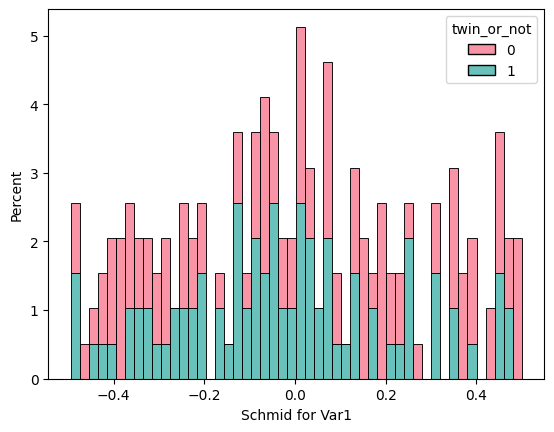

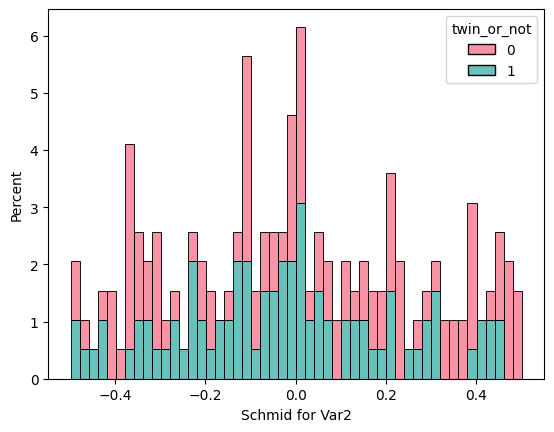

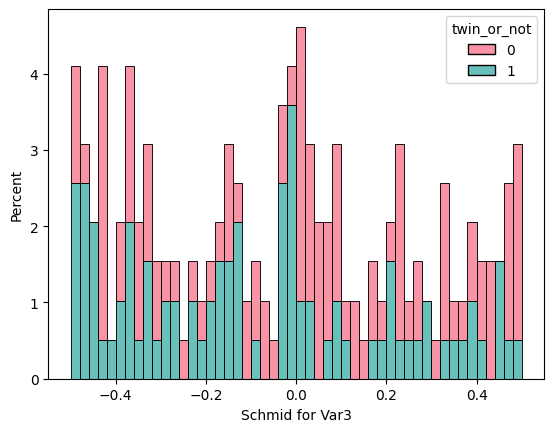

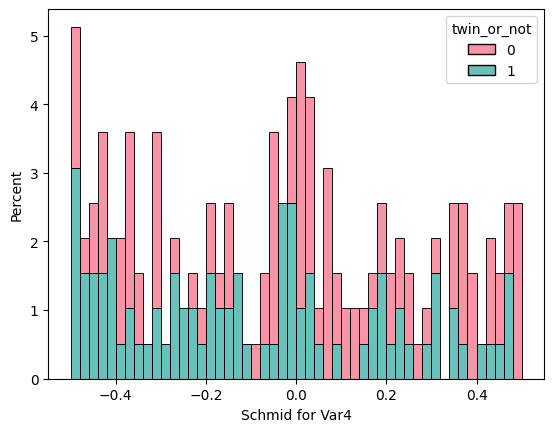

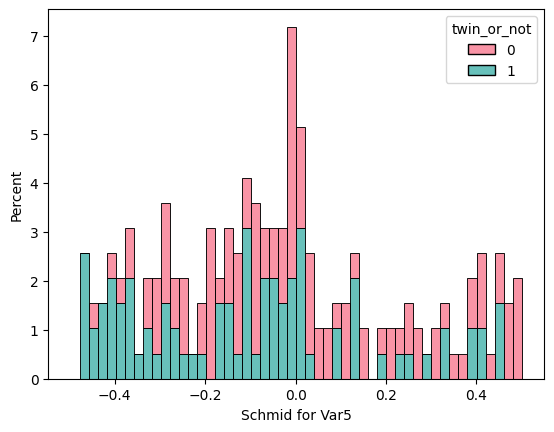

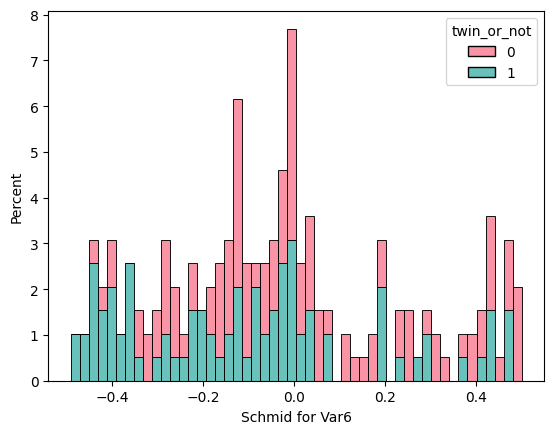

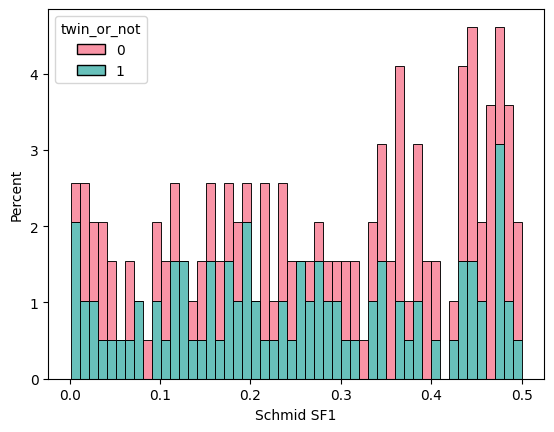

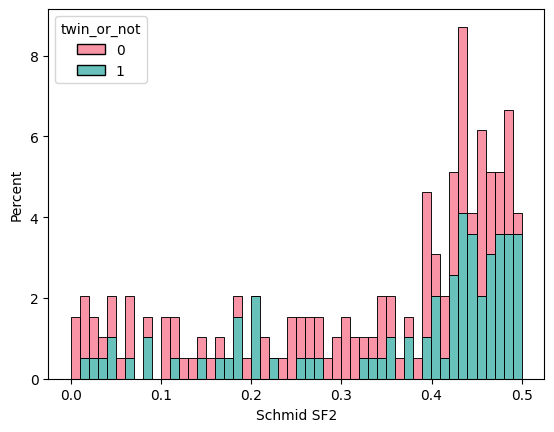

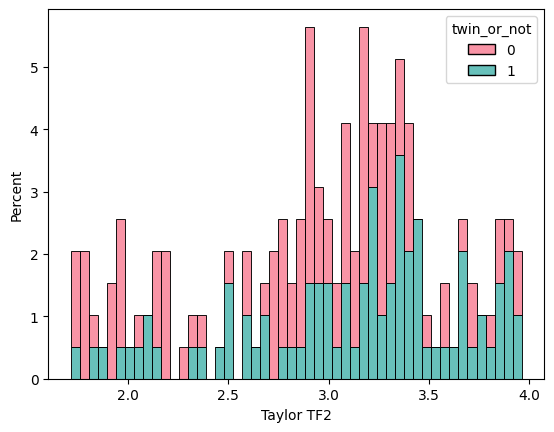

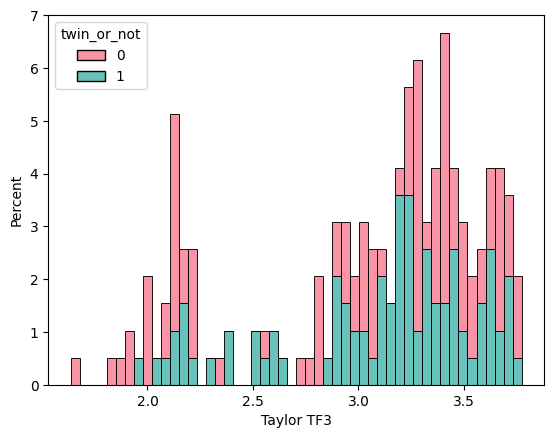

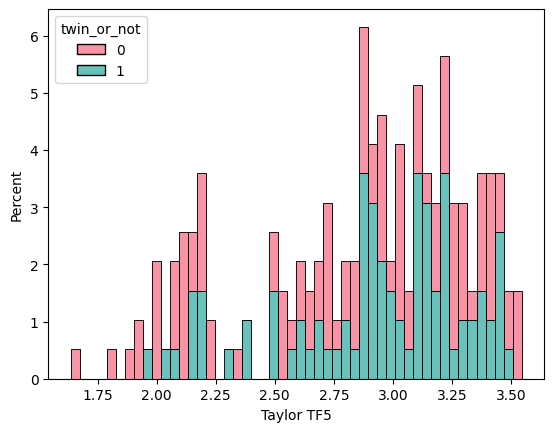

In [278]:
inspection_cols = [
    "Schmid for Var1",
    "Schmid for Var2",
    "Schmid for Var3",
    "Schmid for Var4",
    "Schmid for Var5",
    "Schmid for Var6",
    "Schmid SF1",
    "Schmid SF2",
    "Taylor TF2",
    "Taylor TF3",
    "Taylor TF5",
]
for col in inspection_cols:
    plt.figure()
    bin_range = [df_2[col].min(), df_2[col].max()]
    sns.histplot(data=df_only_gcn_wrong, x=col, bins=50, hue="twin_or_not", multiple="stack", binrange=bin_range, stat="percent", palette="husl")
    plt.savefig(f"analysis_3_twin_not_gcn_wrong_{col}")
    plt.show()

MLP 모델, GCN 모델이 내뱉은 예측 결과들의 `0.5` 기준으로 반올림 전 값들을 확인해봅니다.

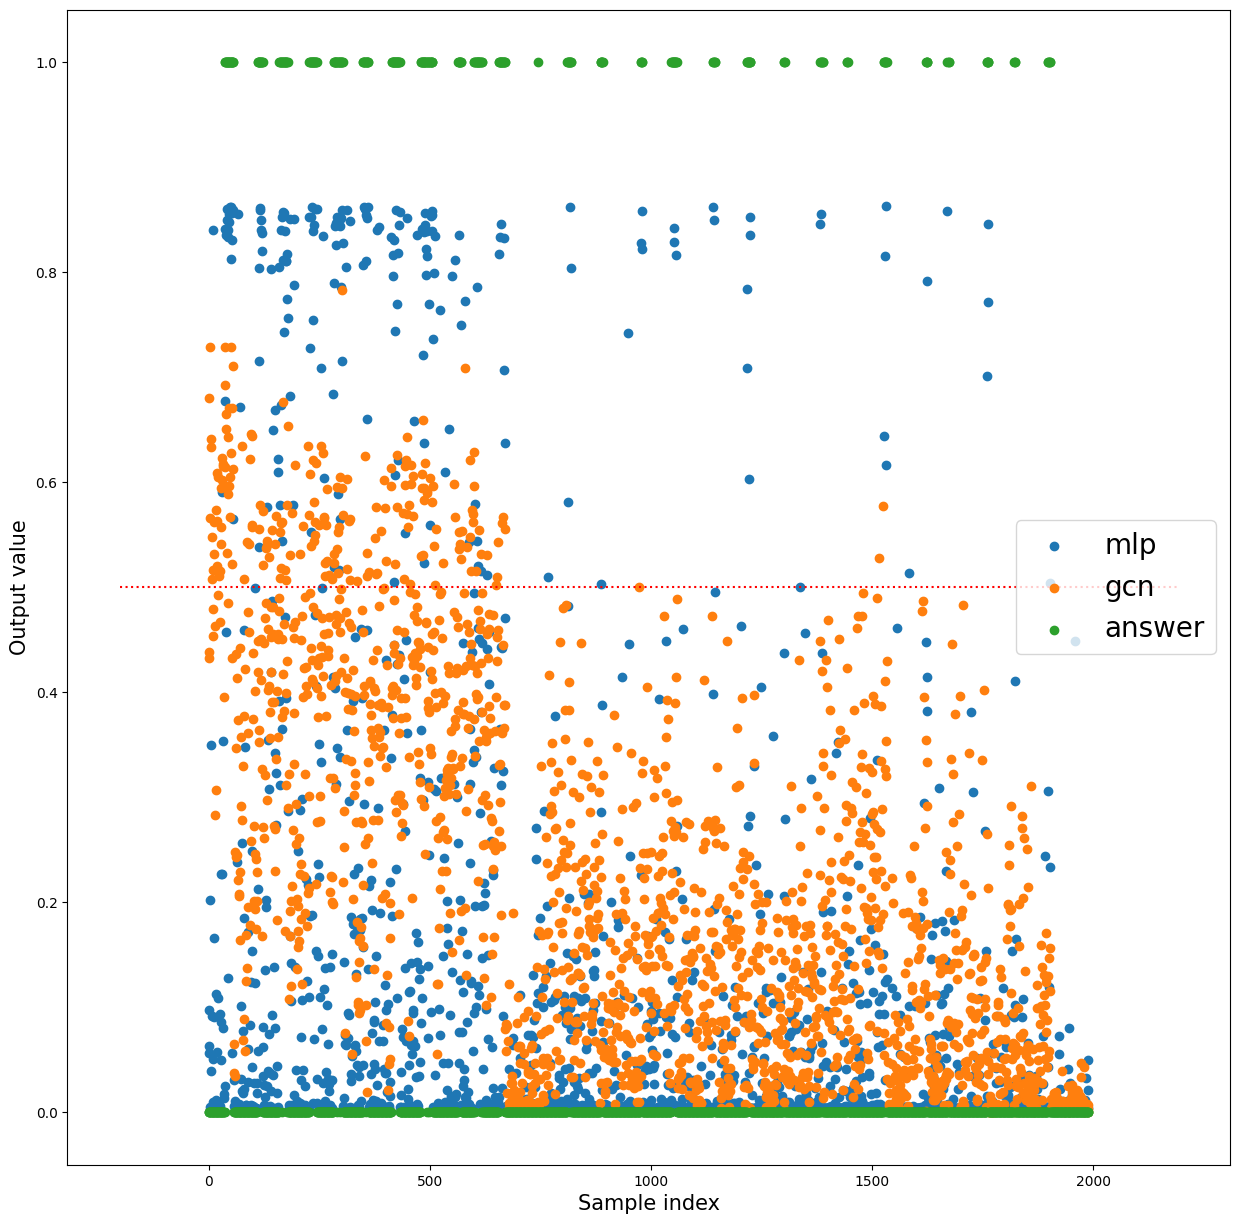

In [279]:
y_mlp = F.sigmoid(out_mlp.squeeze()).numpy()
y_gcn = F.sigmoid(out_gcn[data.test_mask]).numpy()
length = np.arange(len(y_mlp))
plt.figure(figsize=(15, 15))
plt.scatter(x=length, y=y_mlp)
plt.scatter(x=length, y=y_gcn)
plt.scatter(x=length, y=y_true)
plt.hlines(y=0.5, xmin=min(length)-200, xmax=max(length)+200, colors="red", linestyles="dotted")
plt.legend(["mlp", "gcn", "answer"], fontsize=20)
plt.xlabel("Sample index", fontsize=15)
plt.ylabel("Output value", fontsize=15)
plt.show()

`Schmid for Var1` 특징에서 `0` 값을 기준으로 '쌍정', '미쌍정' 간 분포 차이가 나는 것 같습니다. 이를 수치화하여 보고자 합니다. GCN만 틀린 샘플들 중 `Schmid for Var1` 특징 값이 `0` 미만인 샘플들의 '쌍정', '미쌍정' 비율과 테스트 데이터셋 및 훈련 데이터셋 각각의 데이터 중 `Schmid for Var1` 특징 값이 `0` 미만인 샘플들의 '쌍정', '미쌍정' 비율을 확인해봅니다.

결과적으로 GCN만 틀린 샘플들과 테스트 데이터셋 혹은 훈련 데이터셋 간의 '쌍정', '미쌍정' 비율이 `Schmid for Var1` 특징의 `0` 미만 구간에서 어느 정도 차이가 남을 확인할 수 있습니다.

In [280]:
df_only_gcn_wrong[df_only_gcn_wrong["Schmid for Var1"] < 0]["twin_or_not"].value_counts(normalize=True)

twin_or_not
0    0.505051
1    0.494949
Name: proportion, dtype: float64

In [281]:
df_test_only[df_test_only["Schmid for Var1"] < 0]["twin_or_not"].value_counts(normalize=True)

twin_or_not
0    0.717391
1    0.282609
Name: proportion, dtype: float64

In [282]:
df_train_only[df_train_only["Schmid for Var1"] < 0]["twin_or_not"].value_counts(normalize=True)

twin_or_not
0    0.719489
1    0.280511
Name: proportion, dtype: float64